<a href="https://colab.research.google.com/github/AadAriess/CODER/blob/master/Adaptive_LightGBM_with_Anomaly_Detection_and_Multi_Task_Learning_(ALAD_MTL)_untuk_Prediksi_Kunjungan_Wisatawan_Tidak_Wajar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Statistik Ekonomi -> Pariwisata**

## Rata-Rata Pengeluaran Wisatawan Mancanegara (US $)

In [ ]:
# Instalasi library yang diperlukan
!pip install pmdarima
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pmdarima import auto_arima

In [ ]:
# Fungsi untuk membaca dan transformasi data
def read_and_transform(file_path, skip_rows=2):
    df = pd.read_csv(file_path, skiprows=skip_rows, thousands=',', na_values=['-', 'n.a'])
    df.columns = ['Negara'] + [str(col).strip() for col in df.columns[1:]]
    df = df[df['Negara'].notna()]
    return df.melt(id_vars=['Negara'], var_name='Tahun', value_name='Pengeluaran')

# Muat semua data
files = [
    '/content/drive/MyDrive/JURNAL LISTY/DATASET LISTY/Rata-Rata Pengeluaran Wisatawan Mancanegara per Kunjungan Menurut Negara Tempat Tinggal (US $)/Rata-Rata Pengeluaran Wisatawan Mancanegara per Kunjungan Menurut Negara Tempat Tinggal , 2009-2011.csv',
    '/content/drive/MyDrive/JURNAL LISTY/DATASET LISTY/Rata-Rata Pengeluaran Wisatawan Mancanegara per Kunjungan Menurut Negara Tempat Tinggal (US $)/Rata-Rata Pengeluaran Wisatawan Mancanegara per Kunjungan Menurut Negara Tempat Tinggal , 2012-2014.csv',
    '/content/drive/MyDrive/JURNAL LISTY/DATASET LISTY/Rata-Rata Pengeluaran Wisatawan Mancanegara per Kunjungan Menurut Negara Tempat Tinggal (US $)/Rata-Rata Pengeluaran Wisatawan Mancanegara per Kunjungan Menurut Negara Tempat Tinggal , 2015-2018.csv',
    '/content/drive/MyDrive/JURNAL LISTY/DATASET LISTY/Rata-Rata Pengeluaran Wisatawan Mancanegara per Kunjungan Menurut Negara Tempat Tinggal (US $)/Rata-Rata Pengeluaran Wisatawan Mancanegara per Kunjungan Menurut Negara Tempat Tinggal , 2019-2021.csv',
    '/content/drive/MyDrive/JURNAL LISTY/DATASET LISTY/Rata-Rata Pengeluaran Wisatawan Mancanegara per Kunjungan Menurut Negara Tempat Tinggal (US $)/Rata-Rata Pengeluaran Wisatawan Mancanegara per Kunjungan Menurut Negara Tempat Tinggal , 2022-2023.csv'
]

all_data = pd.concat([read_and_transform(f) for f in files], ignore_index=True)

In [ ]:
all_data['Tahun'] = all_data['Tahun'].astype(int)
all_data = all_data.sort_values(['Negara', 'Tahun'])

def interpolate_country(df):
    return df.interpolate(
        method='linear',        # Metode interpolasi linear
        limit_direction='both', # Isi nilai dari kedua arah (forward dan backward)
        limit_area='inside',    # Hanya mengisi NaN di antara nilai yang valid
        order=1                 # Urutan interpolasi (linear)
    )

all_data = all_data.groupby('Negara', group_keys=False).apply(
    lambda x: x.assign(
        Pengeluaran=lambda y: y['Pengeluaran']
        .interpolate(method='linear', limit_direction='both')
        .ffill()  # Mengisi NaN di awal dengan nilai pertama yang valid
        .bfill()  # Mengisi NaN di akhir dengan nilai terakhir yang valid
    )
)

print("Jumlah NaN setelah interpolasi:", all_data['Pengeluaran'].isna().sum())

negara_contoh = 'Mesir'
print("\nContoh data Mesir:")
print(all_data[all_data['Negara'] == negara_contoh].sort_values('Tahun'))

Jumlah NaN setelah interpolasi: 0

Contoh data Mesir:
    Negara  Tahun  Pengeluaran
37   Mesir   2009      1514.73
77   Mesir   2010      1243.69
117  Mesir   2011      1759.55
157  Mesir   2012      1001.88
197  Mesir   2013      1024.50
237  Mesir   2014      1267.22
277  Mesir   2015      1268.50
317  Mesir   2016      1505.54
357  Mesir   2018      2129.40
397  Mesir   2019      1370.70
437  Mesir   2020       685.35
477  Mesir   2021         0.00
517  Mesir   2022         0.00
557  Mesir   2023         0.00


<ipython-input-32-fb179621cffe>:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  all_data = all_data.groupby('Negara', group_keys=False).apply(


In [ ]:
import warnings
from statsmodels.tsa.api import ARIMA

# Suppress warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [ ]:
# Fungsi forecasting manual ARIMA
def manual_arima_forecast(series, order=(1,1,1)):
    try:
        # Handle data konstan
        if series.nunique() == 1:
            return series.iloc[0]

        # Fit model
        model = ARIMA(series, order=order)
        model_fit = model.fit()

        # Forecast
        return model_fit.forecast()[0]
    except:
        # Fallback ke rata-rata bergerak
        return series.rolling(3, min_periods=1).mean().iloc[-1]

# Proses forecasting 2017
forecast_2017_results = []
for negara in all_data['Negara'].unique():
    country_data = all_data[all_data['Negara'] == negara]

    # Data training 2009-2016
    train = country_data[country_data['Tahun'].between(2009, 2016)]
    ts = train.set_index('Tahun')['Pengeluaran']

    # Lakukan forecasting
    forecast = manual_arima_forecast(ts, order=(1,1,1))

    forecast_2017_results.append({
        'Negara': negara,
        'Tahun': 2017,
        'Pengeluaran': forecast
    })

In [ ]:
# Gabungkan hasil forecast 2017
forecast_2017_df = pd.DataFrame(forecast_2017_results)
forecast_2017_df.head()

Negara  Tahun  Pengeluaran
0  Amerika Selatan   2017  1583.313333
1  Amerika Serikat   2017  1628.143333
2   Amerika Tengah   2017  1454.206667
3       Arab Saudi   2017  2015.893333
4        Australia   2017  1611.573333

In [ ]:
combined_data = pd.concat([all_data, forecast_2017_df], ignore_index=True)
combined_data

Negara  Tahun  Pengeluaran
0    Amerika Selatan   2009  1272.080000
1    Amerika Selatan   2010  1831.130000
2    Amerika Selatan   2011  1543.410000
3    Amerika Selatan   2012  1704.920000
4    Amerika Selatan   2013  1633.270000
..               ...    ...          ...
595         Srilanka   2017  1026.770000
596           Swedia   2017  1549.756667
597            Swiss   2017  1794.176667
598           Taiwan   2017   979.383333
599         Thailand   2017   907.476667

[600 rows x 3 columns]

In [ ]:
# Proses forecasting 2024
final_results = []
for negara in combined_data['Negara'].unique():
    country_data = combined_data[combined_data['Negara'] == negara]

    # Data training 2016-2023
    train = country_data[country_data['Tahun'].between(2016, 2023)]
    ts = train.set_index('Tahun')['Pengeluaran']

    # Lakukan forecasting
    forecast = manual_arima_forecast(ts, order=(1,1,1))

    final_results.append({
        'Negara': negara,
        'Forecast 2017': forecast_2017_df[forecast_2017_df['Negara'] == negara]['Pengeluaran'].values[0],
        'Forecast 2024': forecast
    })

In [ ]:
# Hasil akhir
result_df = pd.DataFrame(final_results)
result_df.head()

Negara  Forecast 2017  Forecast 2024
0  Amerika Selatan    1583.313333    1933.964444
1  Amerika Serikat    1628.143333    2062.434444
2   Amerika Tengah    1454.206667     484.735556
3       Arab Saudi    2015.893333    1921.834444
4        Australia    1611.573333    1510.941111

In [ ]:
# Tampilkan hasil
print("Hasil Forecasting dengan ARIMA Manual:")
print(result_df.head(10))

Hasil Forecasting dengan ARIMA Manual:
              Negara  Forecast 2017  Forecast 2024
0    Amerika Selatan    1583.313333    1933.964444
1    Amerika Serikat    1628.143333    2062.434444
2     Amerika Tengah    1454.206667     484.735556
3         Arab Saudi    2015.893333    1921.834444
4          Australia    1611.573333    1510.941111
5            Austria    1669.410000    2903.816667
6         Bangladesh     810.110000     270.036667
7            Belanda    1781.360000    2038.536667
8             Belgia    1671.703333    2184.577778
9  Brunei Darussalam     927.070000     895.593333


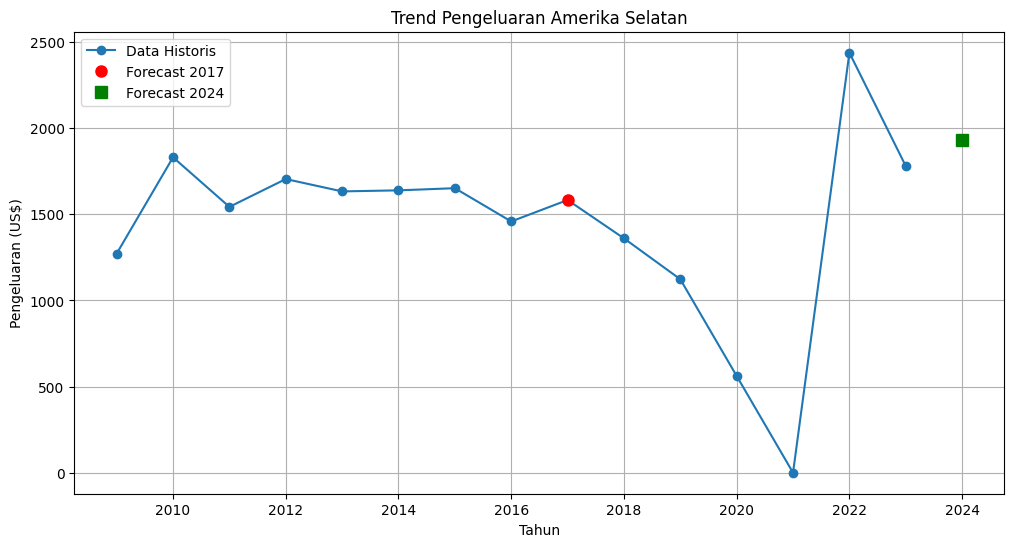

In [ ]:
# Visualisasi contoh
plt.figure(figsize=(12,6))
negara_contoh = 'Amerika Selatan'
data = combined_data[combined_data['Negara'] == negara_contoh].sort_values('Tahun')

plt.plot(data['Tahun'], data['Pengeluaran'], marker='o', label='Data Historis')
plt.plot(2017, result_df[result_df['Negara'] == negara_contoh]['Forecast 2017'].values[0],
         'ro', markersize=8, label='Forecast 2017')
plt.plot(2024, result_df[result_df['Negara'] == negara_contoh]['Forecast 2024'].values[0],
         'gs', markersize=8, label='Forecast 2024')
plt.title(f'Trend Pengeluaran {negara_contoh}')
plt.xlabel('Tahun')
plt.ylabel('Pengeluaran (US$)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Gabungkan forecast 2024 ke data utama
forecast_2024_df = pd.DataFrame({
    'Negara': result_df['Negara'],
    'Tahun': 2024,
    'Pengeluaran': result_df['Forecast 2024']
})

# Gabungkan semua data
full_data = pd.concat([
    all_data,
    forecast_2017_df,
    forecast_2024_df
], ignore_index=True)

# Urutkan dan hapus duplikat
full_data = full_data.sort_values(['Negara', 'Tahun'])
full_data = full_data.drop_duplicates(['Negara', 'Tahun'], keep='last')

# Filter hanya tahun 2017-2024
final_data = full_data[full_data['Tahun'].between(2017, 2024)]

# Simpan ke CSV
final_data.to_csv('forecast_2017-2024.csv', index=False)

# Tampilkan contoh data
print("Contoh Data Final:")
print(final_data[final_data['Negara'] == 'Malaysia'].sort_values('Tahun'))

Contoh Data Final:
       Negara  Tahun  Pengeluaran
583  Malaysia   2017   713.026667
330  Malaysia   2018   843.340000
331  Malaysia   2019   495.160000
332  Malaysia   2020   936.990000
333  Malaysia   2021  1374.650000
334  Malaysia   2022   669.410000
335  Malaysia   2023   591.030000
623  Malaysia   2024   657.822222


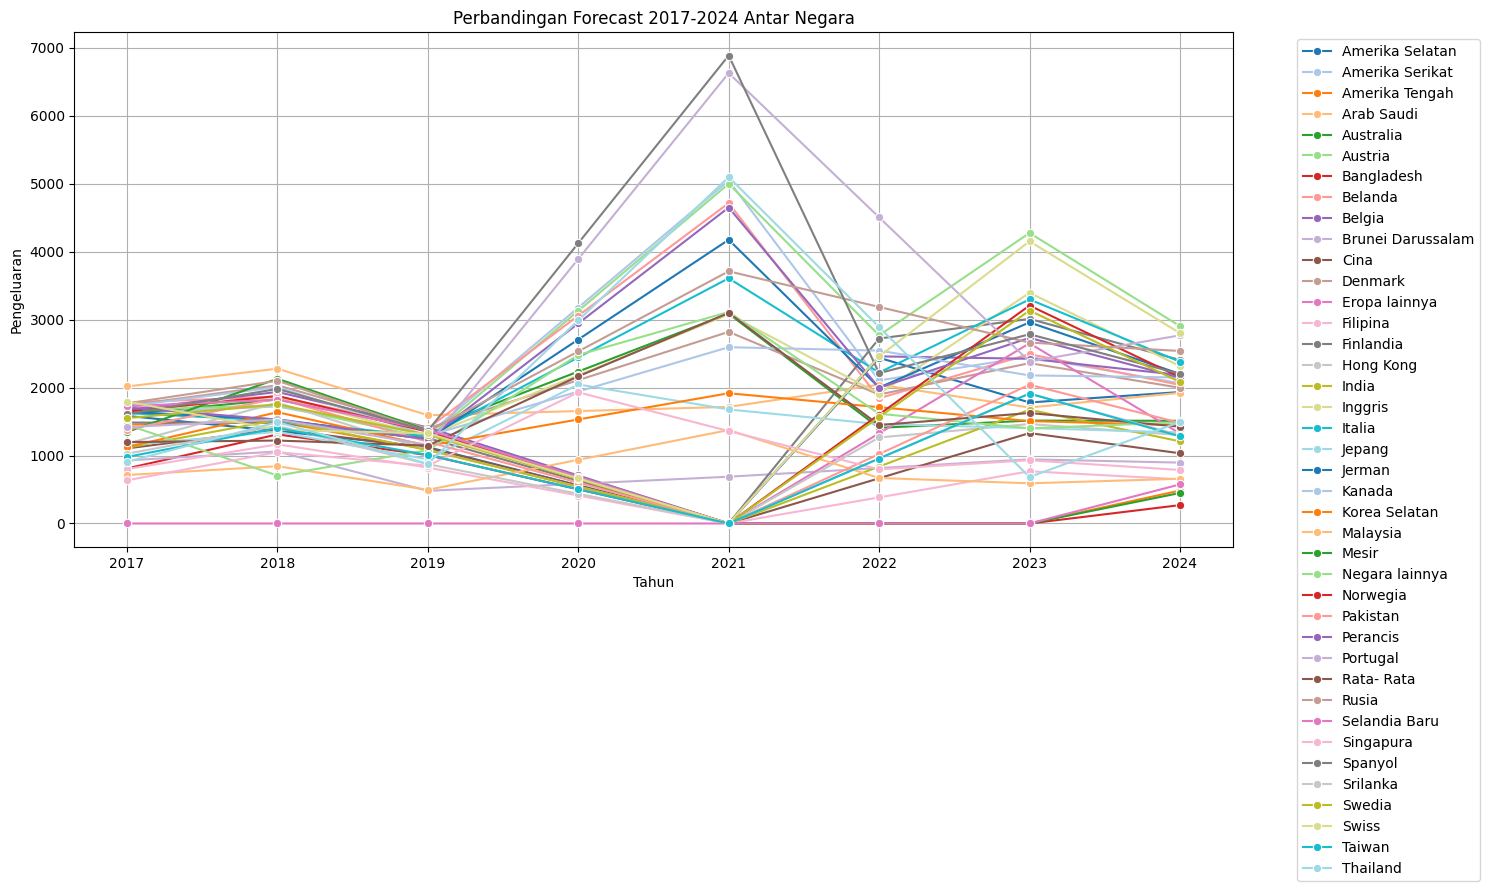

In [ ]:
import seaborn as sns

plt.figure(figsize=(15,8))
sns.lineplot(
    data=final_data,
    x='Tahun',
    y='Pengeluaran',
    hue='Negara',
    marker='o',
    palette='tab20',
    legend='full'
)
plt.title('Perbandingan Forecast 2017-2024 Antar Negara')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(np.arange(2017, 2025, 1))
plt.grid(True)
plt.tight_layout()
plt.show()

## Jumlah Tamu Asing pada Hotel Bintang (Ribu Orang)

In [ ]:
# Instalasi library yang diperlukan
!pip install pmdarima
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pmdarima import auto_arima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 53.5 MB/s eta 0:00:00


In [ ]:
# Fungsi untuk membaca dan transformasi data
def read_and_transform(file_path, skip_rows=2):
    df = pd.read_csv(file_path, skiprows=skip_rows, thousands=',', na_values=['-', 'n.a'])
    df.columns = ['Provinsi'] + [str(col).strip() for col in df.columns[1:]]
    df = df[df['Provinsi'].notna()]
    return df.melt(id_vars=['Provinsi'], var_name='Tahun', value_name='Jumlah')

# Muat semua data
files = [
    '/content/drive/MyDrive/JURNAL LISTY/DATASET LISTY/Jumlah Tamu Asing pada Hotel Bintang (Ribu Orang)/Jumlah Tamu Asing pada Hotel Bintang, 2015-2017.csv',
    '/content/drive/MyDrive/JURNAL LISTY/DATASET LISTY/Jumlah Tamu Asing pada Hotel Bintang (Ribu Orang)/Jumlah Tamu Asing pada Hotel Bintang, 2018-2020.csv',
    '/content/drive/MyDrive/JURNAL LISTY/DATASET LISTY/Jumlah Tamu Asing pada Hotel Bintang (Ribu Orang)/Jumlah Tamu Asing pada Hotel Bintang, 2021-2023.csv'
]

all_data = pd.concat([read_and_transform(f) for f in files], ignore_index=True)

In [ ]:
all_data

Provinsi Tahun   Jumlah
0                ACEH  2015    13.00
1      SUMATERA UTARA  2015   263.10
2      SUMATERA BARAT  2015    38.00
3                RIAU  2015    25.90
4               JAMBI  2015     4.90
..                ...   ...      ...
346             PAPUA  2023     1.25
347     PAPUA SELATAN  2023     0.35
348      PAPUA TENGAH  2023     4.38
349  PAPUA PEGUNUNGAN  2023     0.50
350         INDONESIA  2023  6824.95

[351 rows x 3 columns]

In [ ]:
all_data['Tahun'] = all_data['Tahun'].astype(int)
all_data = all_data.sort_values(['Provinsi', 'Tahun'])

def interpolate_country(df):
    return df.interpolate(
        method='linear',        # Metode interpolasi linear
        limit_direction='both', # Isi nilai dari kedua arah (forward dan backward)
        limit_area='inside',    # Hanya mengisi NaN di antara nilai yang valid
        order=1                 # Urutan interpolasi (linear)
    )

all_data = all_data.groupby('Provinsi', group_keys=False).apply(
    lambda x: x.assign(
        Jumlah=lambda y: y['Jumlah']
        .interpolate(method='linear', limit_direction='both')
        .ffill()  # Mengisi NaN di awal dengan nilai pertama yang valid
        .bfill()  # Mengisi NaN di akhir dengan nilai terakhir yang valid
    )
)

print("Jumlah NaN setelah interpolasi:", all_data['Jumlah'].isna().sum())

Jumlah NaN setelah interpolasi: 0


<ipython-input-4-52541f10afc1>:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  all_data = all_data.groupby('Provinsi', group_keys=False).apply(


In [ ]:
import warnings
from statsmodels.tsa.api import ARIMA

# Suppress warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [ ]:
# Fungsi forecasting manual ARIMA
def manual_arima_forecast(series, order=(1,1,1)):
    try:
        # Handle data konstan
        if series.nunique() == 1:
            return series.iloc[0]

        # Fit model
        model = ARIMA(series, order=order)
        model_fit = model.fit()

        # Forecast
        return model_fit.forecast()[0]
    except:
        # Fallback ke rata-rata bergerak
        return series.rolling(3, min_periods=1).mean().iloc[-1]

# Proses forecasting 2024
forecast_2024_results = []
for provinsi in all_data['Provinsi'].unique():
    country_data = all_data[all_data['Provinsi'] == provinsi]

    # Data training 2016-2023
    train = country_data[country_data['Tahun'].between(2016, 2023)]
    ts = train.set_index('Tahun')['Jumlah']

    # Lakukan forecasting
    forecast = manual_arima_forecast(ts, order=(1,1,1))

    forecast_2024_results.append({
        'Provinsi': provinsi,
        'Tahun': 2024,
        'Jumlah': forecast
    })

In [ ]:
forecast_2024_df = pd.DataFrame(forecast_2024_results)
combined_data = pd.concat([all_data, forecast_2024_df], ignore_index=True)
combined_data

Provinsi  Tahun     Jumlah
0                 ACEH   2015  13.000000
1                 ACEH   2016  24.340000
2                 ACEH   2017  24.590000
3                 ACEH   2018  11.730000
4                 ACEH   2019   9.210000
..                 ...    ...        ...
385  SULAWESI TENGGARA   2024   1.103333
386     SULAWESI UTARA   2024  18.943333
387     SUMATERA BARAT   2024  14.113333
388   SUMATERA SELATAN   2024   5.160000
389     SUMATERA UTARA   2024  50.103333

[390 rows x 3 columns]

In [ ]:
# Filter data untuk tahun 2017-2023 dari data asli
data_2017_2023 = all_data[all_data['Tahun'].between(2017, 2023)]

# Gabungkan dengan forecast 2024
data_2017_2024 = pd.concat([
    data_2017_2023,
    forecast_2024_df
], ignore_index=True)

# Urutkan dan tambahkan status data
data_2017_2024 = data_2017_2024.sort_values(['Provinsi', 'Tahun'])
data_2017_2024['Status'] = np.where(
    data_2017_2024['Tahun'] == 2024,
    'Forecast',
    'Data Aktual'
)

# Simpan ke CSV
data_2017_2024.to_csv('data_2017-2024.csv', index=False)

## Jumlah Tamu Asing pada Hotel Non Bintang (Ribu Orang)

In [ ]:
# Instalasi library yang diperlukan
!pip install pmdarima
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pmdarima import auto_arima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 71.8 MB/s eta 0:00:00


In [ ]:
# Fungsi untuk membaca dan transformasi data
def read_and_transform(file_path, skip_rows=2):
    df = pd.read_csv(file_path, skiprows=skip_rows, thousands=',', na_values=['-', 'n.a'])
    df.columns = ['Provinsi'] + [str(col).strip() for col in df.columns[1:]]
    df = df[df['Provinsi'].notna()]
    return df.melt(id_vars=['Provinsi'], var_name='Tahun', value_name='Jumlah')

# Muat semua data
files = [
    '/content/drive/MyDrive/JURNAL LISTY/DATASET LISTY/Jumlah Tamu Asing pada Hotel Non Bintang (Orang)/Jumlah Tamu Asing pada Hotel Non Bintang , 2015-2017.csv',
    '/content/drive/MyDrive/JURNAL LISTY/DATASET LISTY/Jumlah Tamu Asing pada Hotel Non Bintang (Orang)/Jumlah Tamu Asing pada Hotel Non Bintang , 2018-2020.csv',
    '/content/drive/MyDrive/JURNAL LISTY/DATASET LISTY/Jumlah Tamu Asing pada Hotel Non Bintang (Orang)/Jumlah Tamu Asing pada Hotel Non Bintang , 2021-2023.csv'
]

all_data = pd.concat([read_and_transform(f) for f in files], ignore_index=True)

In [ ]:
all_data['Tahun'] = all_data['Tahun'].astype(int)
all_data = all_data.sort_values(['Provinsi', 'Tahun'])

def interpolate_country(df):
    return df.interpolate(
        method='linear',        # Metode interpolasi linear
        limit_direction='both', # Isi nilai dari kedua arah (forward dan backward)
        limit_area='inside',    # Hanya mengisi NaN di antara nilai yang valid
        order=1                 # Urutan interpolasi (linear)
    )

all_data = all_data.groupby('Provinsi', group_keys=False).apply(
    lambda x: x.assign(
        Jumlah=lambda y: y['Jumlah']
        .interpolate(method='linear', limit_direction='both')
        .ffill()  # Mengisi NaN di awal dengan nilai pertama yang valid
        .bfill()  # Mengisi NaN di akhir dengan nilai terakhir yang valid
    )
)

print("Jumlah NaN setelah interpolasi:", all_data['Jumlah'].isna().sum())

Jumlah NaN setelah interpolasi: 0


<ipython-input-3-52541f10afc1>:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  all_data = all_data.groupby('Provinsi', group_keys=False).apply(


In [ ]:
all_data

Provinsi  Tahun    Jumlah
0              ACEH   2015   5063.22
39             ACEH   2016  29863.00
78             ACEH   2017  20129.16
117            ACEH   2018  10198.00
156            ACEH   2019  10803.00
..              ...    ...       ...
157  SUMATERA UTARA   2019  21104.00
196  SUMATERA UTARA   2020   3912.00
235  SUMATERA UTARA   2021   4486.00
274  SUMATERA UTARA   2022   7031.00
313  SUMATERA UTARA   2023  21938.00

[351 rows x 3 columns]

In [ ]:
import warnings
from statsmodels.tsa.api import ARIMA

# Suppress warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [ ]:
# Fungsi forecasting manual ARIMA
def manual_arima_forecast(series, order=(1,1,1)):
    try:
        # Handle data konstan
        if series.nunique() == 1:
            return series.iloc[0]

        # Fit model
        model = ARIMA(series, order=order)
        model_fit = model.fit()

        # Forecast
        return model_fit.forecast()[0]
    except:
        # Fallback ke rata-rata bergerak
        return series.rolling(3, min_periods=1).mean().iloc[-1]

# Proses forecasting 2024
forecast_2024_results = []
for provinsi in all_data['Provinsi'].unique():
    country_data = all_data[all_data['Provinsi'] == provinsi]

    # Data training 2016-2023
    train = country_data[country_data['Tahun'].between(2016, 2023)]
    ts = train.set_index('Tahun')['Jumlah']

    # Lakukan forecasting
    forecast = manual_arima_forecast(ts, order=(1,1,1))

    forecast_2024_results.append({
        'Provinsi': provinsi,
        'Tahun': 2024,
        'Jumlah': forecast
    })

In [ ]:
forecast_2024_df = pd.DataFrame(forecast_2024_results)
combined_data = pd.concat([all_data, forecast_2024_df], ignore_index=True)
combined_data

Provinsi  Tahun        Jumlah
0                 ACEH   2015   5063.220000
1                 ACEH   2016  29863.000000
2                 ACEH   2017  20129.160000
3                 ACEH   2018  10198.000000
4                 ACEH   2019  10803.000000
..                 ...    ...           ...
385  SULAWESI TENGGARA   2024    721.666667
386     SULAWESI UTARA   2024   1378.333333
387     SUMATERA BARAT   2024   1801.000000
388   SUMATERA SELATAN   2024    413.000000
389     SUMATERA UTARA   2024  11151.666667

[390 rows x 3 columns]

In [ ]:
# Filter data untuk tahun 2017-2023 dari data asli
data_2017_2023 = all_data[all_data['Tahun'].between(2017, 2023)]

# Gabungkan dengan forecast 2024
data_2017_2024 = pd.concat([
    data_2017_2023,
    forecast_2024_df
], ignore_index=True)

# Urutkan dan tambahkan status data
data_2017_2024 = data_2017_2024.sort_values(['Provinsi', 'Tahun'])
data_2017_2024['Status'] = np.where(
    data_2017_2024['Tahun'] == 2024,
    'Forecast',
    'Data Aktual'
)

# Simpan ke CSV
data_2017_2024.to_csv('data_2017-2024.csv', index=False)

## Jumlah Perjalanan Wisatawan Nusantara Menurut Provinsi Asal (Perjalanan)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

In [ ]:
file_path = '/content/drive/MyDrive/JURNAL LISTY/DATASET LISTY/Jumlah Perjalanan Wisatawan Nusantara Menurut Provinsi Asal/Jumlah Perjalanan Wisatawan Nusantara Menurut Provinsi Asal (Perjalanan), 2015-2024.csv'
data = pd.read_csv(file_path)
data.head()

Provinsi       2015       2016       2017        2018        2019  \
0            ACEH  3.023.768  4.306.217  4.410.969   6.518.831  25.523.219   
1  SUMATERA UTARA  9.464.756  9.398.998  9.364.706  10.345.256  63.576.590   
2  SUMATERA BARAT  5.022.693  5.019.290  5.483.028   6.402.187  19.412.170   
3            RIAU  5.517.516  5.076.197  5.149.936   5.552.920  23.132.950   
4           JAMBI  2.019.636  1.774.454  1.906.593   2.242.802  10.721.877   

         2020        2021        2022        2023        2024  
0   4.741.268   5.632.315   7.483.957   8.304.469  13.571.828  
1  13.442.477  16.857.305  21.892.296  25.311.803  42.244.751  
2   7.187.800   8.477.593  10.750.168  12.823.340  17.830.856  
3   5.440.820   6.465.613   9.084.411  11.557.732  19.501.017  
4   2.399.034   3.066.614   3.892.005   4.705.618   9.124.250

In [ ]:
# Fungsi untuk membersihkan angka (menghapus titik dan konversi ke integer)
def clean_number(x):
    if isinstance(x, str):
        return int(x.replace(".", ""))
    return x

# Bersihkan semua kolom tahun
for year in data.columns[1:]:
    data[year] = data[year].apply(clean_number)

# Tahun yang akan diprediksi
years_to_predict = np.array([2009, 2010, 2011, 2012, 2013, 2014]).reshape(-1, 1)

# Menyimpan hasil prediksi untuk setiap provinsi
predictions_per_provinsi = {}

# Melatih model untuk setiap provinsi
for index, row in data.iterrows():
    provinsi = row['Provinsi']
    y = row[1:].values  # Data aktual 2015-2024
    X = np.array(data.columns[1:], dtype=int).reshape(-1, 1)  # Tahun 2015-2024

    model = LinearRegression()
    model.fit(X, y)

    # Prediksi untuk 2009-2014 dan pastikan tidak ada nilai negatif
    predictions = model.predict(years_to_predict)
    predictions = np.where(predictions < 0, 0, predictions).astype(int)  # Ganti nilai negatif dengan 0
    predictions_per_provinsi[provinsi] = predictions

# Membuat DataFrame gabungan (2009-2024)
all_years = [str(year) for year in range(2009, 2025)]

combined_data = []
for index, row in data.iterrows():
    provinsi = row['Provinsi']
    preds = predictions_per_provinsi[provinsi]
    actual = row[1:].values
    combined_row = [provinsi] + preds.tolist() + actual.tolist()
    combined_data.append(combined_row)

columns = ['Provinsi'] + all_years
combined_df = pd.DataFrame(combined_data, columns=columns)

# Format angka dengan titik sebagai pemisah ribuan
def format_number(x):
    return f"{x:,}".replace(",", ".") if isinstance(x, (int, float)) else x

for year in all_years:
    combined_df[year] = combined_df[year].apply(format_number)

# Tampilkan hasil
print("Data Gabungan (2009-2024) dengan Prediksi Non-Negatif:")
print(combined_df.head())

Data Gabungan (2009-2024) dengan Prediksi Non-Negatif:
         Provinsi       2009       2010       2011       2012       2013  \
0            ACEH  1.043.445  1.739.468  2.435.491  3.131.513  3.827.536   
1  SUMATERA UTARA          0          0          0  2.260.367  4.917.637   
2  SUMATERA BARAT          0          0     40.702  1.193.668  2.346.634   
3            RIAU          0          0    584.305  1.650.612  2.716.918   
4           JAMBI          0          0          0    160.955    697.532   

        2014       2015       2016       2017        2018        2019  \
0  4.523.559  3.023.768  4.306.217  4.410.969   6.518.831  25.523.219   
1  7.574.908  9.464.756  9.398.998  9.364.706  10.345.256  63.576.590   
2  3.499.600  5.022.693  5.019.290  5.483.028   6.402.187  19.412.170   
3  3.783.225  5.517.516  5.076.197  5.149.936   5.552.920  23.132.950   
4  1.234.110  2.019.636  1.774.454  1.906.593   2.242.802  10.721.877   

         2020        2021        2022        2023

In [ ]:
combined_df.to_csv('/content/drive/MyDrive/JURNAL LISTY/DATASET LISTY/Jumlah Perjalanan Wisatawan Nusantara Menurut Provinsi Asal/Jumlah Perjalanan Wisatawan Nusantara Menurut Provinsi Asal (Perjalanan), 2009-2024.csv', index=False)

## Jumlah Perjalanan Wisatawan Nusantara Menurut Provinsi Tujuan (Perjalanan)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

In [ ]:
file_path = '/content/drive/MyDrive/JURNAL LISTY/DATASET LISTY/Jumlah Perjalanan Wisatawan Nusantara Menurut Provinsi Tujuan/Jumlah Perjalanan Wisatawan Nusantara Menurut Provinsi Tujuan, 2019-2024.csv'
data = pd.read_csv(file_path)
data.head()

Provinsi        2019        2020        2021        2022        2023  \
0            ACEH  15.660.786   4.142.179   5.534.405   6.954.578   8.943.786   
1  SUMATERA UTARA  47.921.230  14.046.368  17.758.183  23.204.456  27.613.125   
2  SUMATERA BARAT  18.801.652   7.892.822   9.603.912  12.339.263  14.692.245   
3            RIAU  18.505.875   5.505.722   6.143.269   8.404.236  11.147.053   
4           JAMBI   7.219.722   2.684.562   3.047.167   3.780.983   4.783.187   

         2024  
0  12.924.997  
1  42.766.198  
2  19.142.418  
3  17.992.224  
4   8.534.569

In [ ]:
# Fungsi untuk membersihkan angka (menghapus titik dan konversi ke integer)
def clean_number(x):
    if isinstance(x, str):
        return int(x.replace(".", ""))
    return x

# Bersihkan semua kolom tahun
for year in data.columns[1:]:
    data[year] = data[year].apply(clean_number)

# Tahun yang akan diprediksi (2009-2018)
years_to_predict = np.array(range(2009, 2019)).reshape(-1, 1)  # 10 tahun

# Menyimpan hasil prediksi untuk setiap provinsi
predictions_per_provinsi = {}

# Melatih model untuk setiap provinsi
for index, row in data.iterrows():
    provinsi = row['Provinsi']
    y = row[1:].values  # Data aktual 2019-2024 (6 tahun)
    X = np.array(data.columns[1:], dtype=int).reshape(-1, 1)  # Tahun 2019-2024

    model = LinearRegression()
    model.fit(X, y)

    # Prediksi untuk 2009-2018 dan pastikan tidak ada nilai negatif
    predictions = model.predict(years_to_predict)
    predictions = np.where(predictions < 0, 0, predictions).astype(int)
    predictions_per_provinsi[provinsi] = predictions

# Membuat DataFrame gabungan (2009-2024)
all_years = [str(year) for year in range(2009, 2025)]  # 2009-2024 (16 tahun)

# Menyiapkan data untuk DataFrame gabungan
combined_data = []
for index, row in data.iterrows():
    provinsi = row['Provinsi']
    # Ambil prediksi 2009-2018 (10 tahun)
    preds = predictions_per_provinsi[provinsi]
    # Ambil data aktual 2019-2024 (6 tahun)
    actual = row[1:].values
    # Gabungkan prediksi + data aktual
    combined_row = [provinsi] + preds.tolist() + actual.tolist()
    combined_data.append(combined_row)

# Buat DataFrame
columns = ['Provinsi'] + all_years
combined_df = pd.DataFrame(combined_data, columns=columns)

# Format angka dengan titik sebagai pemisah ribuan
def format_number(x):
    return f"{x:,}".replace(",", ".") if isinstance(x, (int, float)) else x

for year in all_years:
    combined_df[year] = combined_df[year].apply(format_number)

# Tampilkan 5 baris pertama
print("Data Gabungan (2009-2024) dengan Prediksi Non-Negatif:")
print(combined_df.head())

Data Gabungan (2009-2024) dengan Prediksi Non-Negatif:
         Provinsi        2009        2010        2011        2012        2013  \
0            ACEH   8.260.342   8.321.658   8.382.973   8.444.289   8.505.605   
1  SUMATERA UTARA  21.609.432  22.191.471  22.773.511  23.355.551  23.937.590   
2  SUMATERA BARAT   4.874.867   5.584.508   6.294.150   7.003.791   7.713.433   
3            RIAU   5.348.525   5.823.288   6.298.051   6.772.814   7.247.577   
4           JAMBI     149.820     538.503     927.187   1.315.870   1.704.554   

         2014        2015        2016        2017        2018        2019  \
0   8.566.920   8.628.236   8.689.552   8.750.867   8.812.183  15.660.786   
1  24.519.630  25.101.669  25.683.709  26.265.748  26.847.788  47.921.230   
2   8.423.074   9.132.716   9.842.357  10.551.998  11.261.640  18.801.652   
3   7.722.340   8.197.103   8.671.866   9.146.629   9.621.392  18.505.875   
4   2.093.238   2.481.921   2.870.605   3.259.288   3.647.972   7.219.722

In [ ]:
output_path = '/content/drive/MyDrive/JURNAL LISTY/DATASET LISTY/combined_data_2009-2024_fixed.csv'
combined_df.to_csv(output_path, index=False)

## Rata-Rata Pengeluaran Wisatawan Mancanegara

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

In [ ]:
file_path = '/content/drive/MyDrive/JURNAL LISTY/DATASET LISTY/Rata-Rata Pengeluaran Wisatawan Mancanegara per Kunjungan Menurut Negara Tempat Tinggal (US $)/Rata-Rata Pengeluaran Wisatawan Mancanegara per Kunjungan Menurut Negara Tempat Tinggal (US $) , full missed.csv'
data = pd.read_csv(file_path)
data.head()

Negara Tempat Tinggal    2009    2010    2011    2012    2013    2014  \
0     Brunei Darussalam     748   891,7     756   956,7   742,5  772,93   
1              Malaysia  684,81   676,6  714,81  727,92  700,59  709,39   
2              Filipina  995,94  854,79  786,06   850,7  836,98  840,71   
3             Singapura  602,81  675,81   700,2  639,01  642,17  658,59   
4              Thailand  858,65  787,05  902,29  964,14  984,06  929,06   

       2015    2016  2017      2018    2019      2020      2021    2022  \
0  1.022,23  986,05   NaN  1.059,37  480,15         0    688,23       0   
1       710  719,69   NaN    843,34  495,16    936,99  1.374,65  669,41   
2    792,75  766,79   NaN  1.164,65  823,05      0,00      0,00       0   
3    658,74  588,53   NaN  1.049,22  849,77  1.929,97  1.359,61  796,59   
4    883,18  910,19   NaN  1.490,58  878,29         0  5.097,13       0   

     2023  2024  
0  943,73   NaN  
1  591,03   NaN  
2  768,43   NaN  
3  929,82   NaN  
4  683,27   NaN

In [ ]:
# Fungsi untuk membersihkan dan memformat angka
def clean_number(x):
    try:
        if isinstance(x, str):
            # Hapus semua karakter non-numerik
            x_clean = x.replace(".", "").replace(",", ".")
            return float(x_clean)
        return float(x)
    except:
        return np.nan

# Bersihkan data dan konversi ke float
for col in data.columns[1:]:
    data[col] = data[col].apply(clean_number)
    data[col] = pd.to_numeric(data[col], errors='coerce').fillna(0)

# Fungsi prediksi dengan penanganan khusus
def predict_missing(year_to_predict, train_years):
    predictions = {}
    for idx, row in data.iterrows():
        negara = row['Negara Tempat Tinggal']

        # Ambil data training
        X = np.array(train_years).reshape(-1, 1)
        y = row[[str(y) for y in train_years]].values.astype(float)

        # Filter data valid (abaikan 0 dan NaN)
        valid_mask = (y > 0) & (~np.isnan(y))
        X_valid = X[valid_mask]
        y_valid = y[valid_mask]

        if len(X_valid) >= 2:  # Minimal 2 data untuk regresi
            model = LinearRegression()
            model.fit(X_valid, y_valid)
            pred = model.predict([[year_to_predict]])[0]
            pred = max(0, pred)  # Pastikan tidak negatif
            predictions[negara] = round(pred, 2)  # 2 desimal
        else:
            predictions[negara] = 0.00  # Default jika data tidak cukup

    return predictions

# Prediksi 2017 (gunakan data 2009-2016)
pred_2017 = predict_missing(2017, range(2009, 2017))
data['2017'] = data['Negara Tempat Tinggal'].map(pred_2017)

# Prediksi 2024 (gunakan data 2018-2023)
pred_2024 = predict_missing(2024, range(2018, 2024))
data['2024'] = data['Negara Tempat Tinggal'].map(pred_2024)

# Format semua kolom ke 2 desimal
for col in data.columns[1:]:
    data[col] = data[col].apply(lambda x: f"{x:.2f}" if isinstance(x, (int, float)) else x)

# Tampilkan hasil
print("Data Final (2017 dan 2024 diformat):")
print(data)

Data Final (2017 dan 2024 diformat):
   Negara Tempat Tinggal     2009     2010     2011     2012     2013  \
0      Brunei Darussalam   748.00   891.70   756.00   956.70   742.50   
1               Malaysia   684.81   676.60   714.81   727.92   700.59   
2               Filipina   995.94   854.79   786.06   850.70   836.98   
3              Singapura   602.81   675.81   700.20   639.01   642.17   
4               Thailand   858.65   787.05   902.29   964.14   984.06   
5              Hong Kong   856.32   962.35  1056.33  1006.95  1059.25   
6                  India  1327.94  1074.89  1135.48  1019.13  1102.52   
7                 Jepang   916.00   978.28  1017.40  1060.17  1136.86   
8          Korea Selatan   847.77   912.92   966.54   931.82  1111.19   
9               Pakistan   846.17  1064.40   831.25  2151.83   989.60   
10            Bangladesh  1122.80  1202.32  1525.38  1119.85   901.84   
11              Srilanka  1112.11  1270.64  1084.37  1122.52   818.05   
12            

In [ ]:
output_path = '/content/drive/MyDrive/JURNAL LISTY/DATASET LISTY/prediksi_rata_rata_pengeluaran.csv'
data.to_csv(output_path, index=False)

## Tingkat Penghunian Kamar Hotel Non Bintang (Persen)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

In [ ]:
file_path = '/content/drive/MyDrive/JURNAL LISTY/DATASET LISTY/Tingkat Penghunian Kamar Hotel (Persen)/Tingkat Penghunian Kamar Hotel Non Bintang (Persen), full missed.csv'
data = pd.read_csv(file_path)
data.head()

Provinsi   2009   2010   2011   2012   2013   2014   2015   2016  \
0            ACEH  38,63  38,99  37,04  36,89  31,14  32,15  29,86  30,46   
1  SUMATERA UTARA  37,07  36,58   38,5  40,64  43,03   37,2  41,41  40,73   
2  SUMATERA BARAT  36,67  40,37  43,62  43,11  36,28  44,19  34,07  33,71   
3            RIAU  58,41  57,99  60,29  54,42  48,75  36,18  41,95  44,54   
4           JAMBI   37,4  35,13  33,53  35,16  34,38  31,87  27,31  30,83   

    2017   2018   2019   2020   2021   2022   2023  2024  
0  29,18  28,26  28,48  18,28  20,97  23,62  20,59   NaN  
1  36,47   35,3  36,54  24,34  26,29  27,56  25,74   NaN  
2  32,86  32,18  24,75  13,11  18,34  19,86  18,32   NaN  
3  39,07   36,7  30,71  22,26  28,76  28,36  27,01   NaN  
4  30,19  33,34  23,13  17,76  21,55  26,66   25,5   NaN

In [ ]:
# Fungsi untuk membersihkan angka (ganti koma dengan titik)
def clean_number(x):
    if isinstance(x, str):
        return float(x.replace(",", "."))  # Ganti koma dengan titik
    return x

# Bersihkan semua kolom tahun
for col in data.columns[1:]:
    data[col] = data[col].apply(clean_number)
    data[col] = pd.to_numeric(data[col], errors="coerce").fillna(0)  # Pastikan tipe data float

# Prediksi 2024 untuk setiap provinsi
predictions = {}
for idx, row in data.iterrows():
    provinsi = row['Provinsi']

    # Ambil data 2009-2023
    years = np.array(range(2009, 2024)).reshape(-1, 1)  # Tahun sebagai fitur
    occupancy = row[['2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016',
                    '2017', '2018', '2019', '2020', '2021', '2022', '2023']].values.astype(float)  # Target

    # Hapus tahun dengan nilai 0 (anggap sebagai data hilang)
    valid_indices = occupancy != 0
    if np.sum(valid_indices) >= 2:  # Minimal 2 data valid
        model = LinearRegression()
        model.fit(years[valid_indices], occupancy[valid_indices])
        pred_2024 = model.predict([[2024]])[0]
        pred_2024 = max(0, min(100, pred_2024))  # Pastikan nilai antara 0-100%
        predictions[provinsi] = round(pred_2024, 2)
    else:
        predictions[provinsi] = 0.00  # Default jika data tidak cukup

# Update kolom 2024
data['2024'] = data['Provinsi'].map(predictions)

# Format semua kolom ke 2 desimal
for col in data.columns[1:]:
    data[col] = data[col].apply(lambda x: f"{x:.2f}")

# Tampilkan hasil
print("Data setelah prediksi 2024:")
print(data)

Data setelah prediksi 2024:
                Provinsi   2009   2010   2011   2012   2013   2014   2015  \
0                   ACEH  38.63  38.99  37.04  36.89  31.14  32.15  29.86   
1         SUMATERA UTARA  37.07  36.58  38.50  40.64  43.03  37.20  41.41   
2         SUMATERA BARAT  36.67  40.37  43.62  43.11  36.28  44.19  34.07   
3                   RIAU  58.41  57.99  60.29  54.42  48.75  36.18  41.95   
4                  JAMBI  37.40  35.13  33.53  35.16  34.38  31.87  27.31   
5       SUMATERA SELATAN  38.15  39.07  32.84  42.33  37.33  36.32  33.51   
6               BENGKULU  30.85  33.45  26.90  25.13  29.38  25.10  23.97   
7                LAMPUNG  43.89  41.61  48.19  45.13  39.91  37.41  35.68   
8   KEP. BANGKA BELITUNG  27.62  28.57  26.66  24.28  20.55  28.12  27.41   
9              KEP. RIAU  27.08  41.51  36.51  35.04  40.79  42.82  34.35   
10           DKI JAKARTA  62.76  61.45  60.93  60.57  60.23  65.38  67.80   
11            JAWA BARAT  28.21  29.12  32.89  3

In [ ]:
output_path = '/content/drive/MyDrive/JURNAL LISTY/DATASET LISTY/prediksi_tingkat_penghunian.csv'
data.to_csv(output_path, index=False)

## Tingkat Penghunian Kamar Hotel Bintang (Persen)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

In [ ]:
file_path = '/content/drive/MyDrive/JURNAL LISTY/DATASET LISTY/Tingkat Penghunian Kamar Hotel (Persen)/Tingkat Penghunian Kamar Hotel Bintang (Persen), full missed.csv'
data = pd.read_csv(file_path)
data.head()

Provinsi   2009   2010   2011   2012   2013   2014   2015   2016  \
0            ACEH  51,18  49,79  49,18  45,03  44,57  50,56  47,95  46,03   
1  SUMATERA UTARA  42,06  42,02  44,62  45,14  45,31  50,59  56,12  54,19   
2  SUMATERA BARAT  47,27  47,89  49,64  50,48  54,05  52,65  49,85  54,32   
3            RIAU  47,07   48,1  47,46  46,52  41,76  43,42  45,09  48,51   
4           JAMBI  48,38  49,13  45,79  47,11  48,39  46,58  44,08   48,2   

    2017   2018   2019   2020   2021   2022   2023  2024  
0  48,58  43,58  43,18  27,38  29,85  32,52  30,44   NaN  
1  55,22  56,87  48,86   30,7  37,65  44,52  47,63   NaN  
2  55,03  56,18     56  35,34  42,13  48,48  49,48   NaN  
3  47,24  48,71  48,69  32,38  39,57  41,62  37,81   NaN  
4   46,1  43,44  45,49   34,4  38,33  48,79   54,3   NaN

In [ ]:
# Fungsi untuk membersihkan angka (ganti koma dengan titik)
def clean_number(x):
    if isinstance(x, str):
        return float(x.replace(",", "."))  # Ganti koma dengan titik
    return x

# Bersihkan semua kolom tahun
for col in data.columns[1:]:
    data[col] = data[col].apply(clean_number)
    data[col] = pd.to_numeric(data[col], errors="coerce").fillna(0)  # Pastikan tipe data float

# Prediksi 2024 untuk setiap provinsi
predictions = {}
for idx, row in data.iterrows():
    provinsi = row['Provinsi']

    # Ambil data 2009-2023
    years = np.array(range(2009, 2024)).reshape(-1, 1)  # Tahun sebagai fitur
    occupancy = row[['2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016',
                    '2017', '2018', '2019', '2020', '2021', '2022', '2023']].values.astype(float)  # Target

    # Hapus tahun dengan nilai 0 (anggap sebagai data hilang)
    valid_indices = occupancy != 0
    if np.sum(valid_indices) >= 2:  # Minimal 2 data valid
        model = LinearRegression()
        model.fit(years[valid_indices], occupancy[valid_indices])
        pred_2024 = model.predict([[2024]])[0]
        pred_2024 = max(0, min(100, pred_2024))  # Pastikan nilai antara 0-100%
        predictions[provinsi] = round(pred_2024, 2)
    else:
        predictions[provinsi] = 0.00  # Default jika data tidak cukup

# Update kolom 2024
data['2024'] = data['Provinsi'].map(predictions)

# Format semua kolom ke 2 desimal
for col in data.columns[1:]:
    data[col] = data[col].apply(lambda x: f"{x:.2f}")

# Tampilkan hasil
print("Data setelah prediksi 2024:")
print(data)

Data setelah prediksi 2024:
                Provinsi   2009   2010   2011   2012   2013   2014   2015  \
0                   ACEH  51.18  49.79  49.18  45.03  44.57  50.56  47.95   
1         SUMATERA UTARA  42.06  42.02  44.62  45.14  45.31  50.59  56.12   
2         SUMATERA BARAT  47.27  47.89  49.64  50.48  54.05  52.65  49.85   
3                   RIAU  47.07  48.10  47.46  46.52  41.76  43.42  45.09   
4                  JAMBI  48.38  49.13  45.79  47.11  48.39  46.58  44.08   
5       SUMATERA SELATAN  48.51  56.05  56.98  51.41  47.46  46.90  51.57   
6               BENGKULU  37.44  41.93  40.07  40.74  46.56  48.71  53.20   
7                LAMPUNG  51.67  50.82  53.66  58.37  54.03  57.11  48.83   
8   KEP. BANGKA BELITUNG  43.37  41.73  48.01  44.86  41.71  40.19  39.21   
9              KEP. RIAU  46.55  47.58  46.95  48.42  49.17  48.18  49.42   
10           DKI JAKARTA  50.69  51.76  56.05  56.37  55.68  58.27  62.47   
11            JAWA BARAT  41.40  43.49  45.78  4

In [ ]:
output_path = '/content/drive/MyDrive/JURNAL LISTY/DATASET LISTY/prediksi_tingkat_penghunian.csv'
data.to_csv(output_path, index=False)

## Jumlah Tamu Asing pada Hotel Non Bintang

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

In [ ]:
file_path = '/content/drive/MyDrive/JURNAL LISTY/DATASET LISTY/Jumlah Tamu Asing pada Hotel/Jumlah Tamu Asing pada Hotel Non Bintang (Orang), full missed.csv'
data = pd.read_csv(file_path)
data.head()

Provinsi     2009    2010    2011     2012       2013       2014  \
0            ACEH    2.042   1.537   1.851    1.547   2.303,69   8.065,92   
1  SUMATERA UTARA   16.481  11.531  25.970  122.004  63.627,22  37.778,80   
2  SUMATERA BARAT   14.162   7.535  41.298   21.796   9.005,98   7.421,73   
3            RIAU    1.298   1.693   1.348      251   1.245,77   2.020,60   
4           JAMBI  103.000      90     225       93     126,48     516,71   

        2015    2016       2017     2018    2019     2020     2021     2022  \
0   5.063,22  29.863  20.129,16   10.198  10.803   24.806  834.000  369.000   
1  19.135,61  67.499  99.006,44   97.445  21.104    3.912    4.486    7.031   
2   3.515,58  11.606   8.717,92    3.616   3.786    6.193    1.310  794.000   
3     204,39   1.379   1.797,43  198.852  65.845    3.342  389.000  233.000   
4     117,14     507   1.281,31      848   2.391  102.000   74.000   82.000   

     2023  2024  
0   1.715   NaN  
1  21.938   NaN  
2   3.299   NaN  
3     244   NaN  
4     773   NaN

In [ ]:
# Fungsi untuk membersihkan angka (hapus titik dan ganti koma dengan titik)
def clean_number(x):
    if isinstance(x, str):
        return float(x.replace(".", "").replace(",", "."))
    return x

# Bersihkan semua kolom tahun
for col in data.columns[1:]:
    data[col] = data[col].apply(clean_number)
    data[col] = pd.to_numeric(data[col], errors="coerce").fillna(0)

# Prediksi 2024 untuk setiap provinsi
predictions = {}
for idx, row in data.iterrows():
    provinsi = row['Provinsi']

    # Ambil data 2009-2023 (15 tahun: indeks 1 sampai 15)
    years = np.array(range(2009, 2024)).reshape(-1, 1)  # Tahun sebagai fitur (15 data)
    occupancy = row[1:16].values.astype(float)  # Target dari 2009 hingga 2023 (15 kolom)

    # Hapus tahun dengan nilai 0 (anggap sebagai data hilang)
    valid_indices = occupancy != 0
    if np.sum(valid_indices) >= 2:  # Minimal 2 data valid
        model = LinearRegression()
        model.fit(years[valid_indices], occupancy[valid_indices])
        pred_2024 = model.predict([[2024]])[0]
        pred_2024 = max(0, pred_2024)  # Pastikan tidak negatif
        predictions[provinsi] = round(pred_2024, 2)
    else:
        predictions[provinsi] = 0.00  # Default jika data tidak cukup

# Update kolom 2024
data['2024'] = data['Provinsi'].map(predictions)

# Format semua kolom ke 2 desimal
for col in data.columns[1:]:
    data[col] = data[col].apply(lambda x: f"{x:.2f}")

# Tampilkan hasil
print("Data setelah prediksi 2024:")
print(data)

Data setelah prediksi 2024:
                Provinsi    2009        2010        2011        2012  \
0                   ACEH    2.04     1537.00     1851.00     1547.00   
1         SUMATERA UTARA   16.48    11531.00    25970.00   122004.00   
2         SUMATERA BARAT   14.16     7535.00    41298.00    21796.00   
3                   RIAU    1.30     1693.00     1348.00      251.00   
4                  JAMBI  103.00       90.00      225.00       93.00   
5       SUMATERA SELATAN  233.00     3623.00      406.00      248.00   
6               BENGKULU  140.00      132.00      435.00      422.00   
7                LAMPUNG  356.00      388.00     4004.00      548.00   
8   KEP. BANGKA BELITUNG   60.00       86.00      163.00       89.00   
9              KEP. RIAU   39.34    29963.00    41278.00   122411.00   
10           DKI JAKARTA   12.40    11932.00    54724.00    43258.00   
11            JAWA BARAT   45.43    90765.00    41084.00    50390.00   
12           JAWA TENGAH   11.53    

In [ ]:
output_path = '/content/drive/MyDrive/JURNAL LISTY/DATASET LISTY/prediksi_jumlah_tamu_asing.csv'
data.to_csv(output_path, index=False)

## Jumlah Tamu Asing pada Hotel Bintang

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

In [ ]:
file_path = '/content/drive/MyDrive/JURNAL LISTY/DATASET LISTY/Jumlah Tamu Asing pada Hotel/Jumlah Tamu Asing pada Hotel Bintang (Orang), full missed.csv'
data = pd.read_csv(file_path)
data.head()

Provinsi   2009  2010   2011   2012   2013   2014   2015    2016  \
0            ACEH    9,2     9    6,3    4,3      7   11,8     13   24,34   
1  SUMATERA UTARA  139,8   124  125,6  197,4  292,3  453,2  263,1  311,48   
2  SUMATERA BARAT   34,7  18,7   20,6   36,9     59   63,8     38   81,27   
3            RIAU   17,1  18,5   19,3   16,2   64,6   88,7   25,9   33,13   
4           JAMBI    2,6   3,8    2,4    1,2    1,3    2,1    4,9    4,05   

     2017    2018    2019   2020  2021   2022    2023  2024  
0   24,59   11,73    9,21   2,49  0,12   0,88     7,3   NaN  
1  314,78  346,94  201,88  33,25  4,93  32,05  113,33   NaN  
2   75,86   43,08   51,83  10,32  2,37   9,91   30,06   NaN  
3   35,19   30,54   35,33   7,77  5,41  10,34   14,93   NaN  
4    7,89    5,66    6,02   1,44  0,81   2,08    3,37   NaN

In [ ]:
# Fungsi untuk membersihkan angka (hapus titik dan ganti koma dengan titik)
def clean_number(x):
    if isinstance(x, str):
        return float(x.replace(".", "").replace(",", "."))
    return x

# Bersihkan semua kolom tahun
for col in data.columns[1:]:
    data[col] = data[col].apply(clean_number)
    data[col] = pd.to_numeric(data[col], errors="coerce").fillna(0)

# Prediksi 2024 untuk setiap provinsi
predictions = {}
for idx, row in data.iterrows():
    provinsi = row['Provinsi']

    # Ambil data 2009-2023 (15 tahun: indeks 1 sampai 15)
    years = np.array(range(2009, 2024)).reshape(-1, 1)  # Tahun sebagai fitur (15 data)
    occupancy = row[1:16].values.astype(float)  # Target dari 2009 hingga 2023 (15 kolom)

    # Hapus tahun dengan nilai 0 (anggap sebagai data hilang)
    valid_indices = occupancy != 0
    if np.sum(valid_indices) >= 2:  # Minimal 2 data valid
        model = LinearRegression()
        model.fit(years[valid_indices], occupancy[valid_indices])
        pred_2024 = model.predict([[2024]])[0]
        pred_2024 = max(0, pred_2024)  # Pastikan tidak negatif
        predictions[provinsi] = round(pred_2024, 2)
    else:
        predictions[provinsi] = 0.00  # Default jika data tidak cukup

# Update kolom 2024
data['2024'] = data['Provinsi'].map(predictions)

# Format semua kolom ke 2 desimal
for col in data.columns[1:]:
    data[col] = data[col].apply(lambda x: f"{x:.2f}")

# Tampilkan hasil
print("Data setelah prediksi 2024:")
print(data)

Data setelah prediksi 2024:
                Provinsi     2009     2010     2011     2012     2013  \
0                   ACEH     9.20     9.00     6.30     4.30     7.00   
1         SUMATERA UTARA   139.80   124.00   125.60   197.40   292.30   
2         SUMATERA BARAT    34.70    18.70    20.60    36.90    59.00   
3                   RIAU    17.10    18.50    19.30    16.20    64.60   
4                  JAMBI     2.60     3.80     2.40     1.20     1.30   
5       SUMATERA SELATAN     5.40     7.40    25.30    11.10    17.30   
6               BENGKULU     0.20     0.10     0.20     0.60     0.90   
7                LAMPUNG     2.70     2.10     5.00    14.90    35.40   
8   KEP. BANGKA BELITUNG     0.70     0.60     1.40     1.70     2.00   
9              KEP. RIAU   788.10   717.40   961.30   860.70  1490.20   
10           DKI JAKARTA   651.20   882.90  1013.20  1190.30  1114.80   
11            JAWA BARAT   159.60   156.60   178.10   243.90   310.00   
12           JAWA TENGA

In [ ]:
output_path = '/content/drive/MyDrive/JURNAL LISTY/DATASET LISTY/prediksi_jumlah_tamu_asing.csv'
data.to_csv(output_path, index=False)

## Penggabungan Seluruh Domain Statistik Ekonomi -> Pariwisata

In [ ]:
import pandas as pd

In [ ]:
# Membaca file CSV
file_path = '/content/drive/MyDrive/JURNAL LISTY/DATASET LISTY/Statistik Ekonomi-Pariwisata.csv'
data = pd.read_csv(file_path)
# Mengatur tampilan untuk menampilkan semua baris dan kolom
pd.set_option('display.max_rows', None)  # Menampilkan semua baris
pd.set_option('display.max_columns', None)  # Menampilkan semua kolom
# Menampilkan isi DataFrame
data

Kategori Data  \
0                      Kunjungan Wisman per Kebangsaan   
1                                                  NaN   
2                                                  NaN   
3                                                  NaN   
4                                                  NaN   
5                                                  NaN   
6                                                  NaN   
7    Kunjungan Wisatawan Mancanegara Menurut Pintu ...   
8                                                  NaN   
9                                                  NaN   
10                                                 NaN   
11                                                 NaN   
12   Perjalanan Wisatawan Nusantara Menurut Provins...   
13                                                 NaN   
14                                                 NaN   
15                                                 NaN   
16                                                 NaN   
17                                                 NaN   
18                                                 NaN   
19                                                 NaN   
20                                                 NaN   
21                                                 NaN   
22                                                 NaN   
23                                                 NaN   
24                                                 NaN   
25                                                 NaN   
26                                                 NaN   
27                                                 NaN   
28                                                 NaN   
29                                                 NaN   
30                                                 NaN   
31                                                 NaN   
32                                                 NaN   
33                                                 NaN   
34                                                 NaN   
35                                                 NaN   
36                                                 NaN   
37                                                 NaN   
38                                                 NaN   
39                                                 NaN   
40                                                 NaN   
41                                                 NaN   
42                                                 NaN   
43                                                 NaN   
44                                                 NaN   
45                                                 NaN   
46                                                 NaN   
47                                                 NaN   
48                                                 NaN   
49                                                 NaN   
50   Perjalanan Wisatawan Nusantara Menurut Provins...   
51                                                 NaN   
52                                                 NaN   
53                                                 NaN   
54                                                 NaN   
55                                                 NaN   
56                                                 NaN   
57                                                 NaN   
58                                                 NaN   
59                                                 NaN   
60                                                 NaN   
61                                                 NaN   
62                                                 NaN   
63                                                 NaN   
64                                                 NaN   
65                                                 NaN   
66                                                 NaN   
67                                                 NaN   
68                                     

# **Statistik Ekonomi -> Statistik Makroekonomi**

## Total Ekonomi - Neraca Institusi Terintegrasi (triliun rupiah)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

In [ ]:
file_path = '/content/drive/MyDrive/JURNAL LISTY/DATASET LISTY/Total Ekonomi - Neraca Institusi Terintegrasi ( triliun rupiah)/Total Ekonomi - Neraca Institusi Terintegrasi ( triliun rupiah) FINAL.csv'
data = pd.read_csv(file_path)
data

Kode                                  Klasifikasi 2016 (Penggunaan)  \
0   P.1                                       Output              0,00   
1  B.1g                           Nilai tambah bruto         12.401,73   
2   D.1                      Kompensasi tenaga kerja          5.032,24   
3  D.21                            Pajak atas produk              0,00   
4   P.3                   Pengeluaran konsumsi akhir          8.353,14   
5   D.5              Pajak pendapatan, kekayaan, dll            661,67   
6   D.8  Penyesuaian atas perubahan pada hak pensiun             31,79   
7   D.4                       Pendapatan kepemilikan          1.931,50   

  2016 (Sumber) 2017 (Penggunaan) 2017 (Sumber) 2018 (Penggunaan)  \
0     23.453,49              0,00     25.588,66              0,00   
1          0,00         13.589,83          0,00         14.838,76   
2          0,00          5.635,98          0,00          5.932,23   
3        587,56              0,00        652,78              0,00   
4          0,00          9.023,12          0,00          9.793,75   
5        704,90            637,01        687,93            736,73   
6         31,79             22,63         22,63              8,41   
7      1.560,46          1.991,70      1.572,49          2.214,83   

  2018 (Sumber) 2019 (Penggunaan) 2019 (Sumber) 2020 (Penggunaan)  \
0     28.004,99              0,00     29.889,12              0,00   
1          0,00         15.832,66          0,00         15.443,35   
2          0,00          6.214,68          0,00          5.761,10   
3        780,47              0,00        840,40              0,00   
4          0,00         10.566,55          0,00         10.592,54   
5        795,59            762,88        817,93            592,16   
6          8,41             21,85         21,85             23,58   
7      1.810,48          2.499,44      2.017,48          2.358,98   

  2020 (Sumber) 2021 (Penggunaan) 2021 (Sumber) 2022 (Penggunaan)  \
0     29.044,86              0,00     31.741,60              0,00   
1          0,00         16.976,75          0,00         19.588,09   
2          0,00          6.329,59          0,00          6.944,57   
3        711,58              0,00        866,38              0,00   
4          0,00         11.013,80          0,00         11.895,74   
5        645,70            680,94        747,22            980,73   
6         23,58             24,69         24,69             25,84   
7      1.910,62          2.438,63      1.968,86          2.872,03   

  2022 (Sumber) 2023 (Penggunaan) 2023 (Sumber) 2024 (Penggunaan)  \
0     36.409,10              0,00     39.123,63              0,00   
1          0,00         20.892,38          0,00         21.227,20   
2          0,00          7.306,09          0,00          7.346,69   
3      1.069,59              0,00      1.131,67              0,00   
4          0,00         12.925,82          0,00         13.648,60   
5      1.051,68          1.033,65      1.115,72            928,08   
6         25,84             26,40         26,40             23,15   
7      2.486,41          3.164,06      2.487,02          3.250,81   

  2024 (Sumber)  
0     40.725,39  
1          0,00  
2          0,00  
3      1.079,23  
4          0,00  
5        997,15  
6         23,15  
7      2.392,47

In [ ]:
# Fungsi untuk membersihkan angka (ganti koma dengan titik dan hapus separator ribuan)
def clean_number(x):
    if isinstance(x, str):
        return float(x.replace(".", "").replace(",", "."))
    return x

# Bersihkan semua kolom numerik
numeric_cols = [col for col in data.columns if any(char.isdigit() for char in col)]
for col in numeric_cols:
    data[col] = data[col].apply(clean_number)
    data[col] = pd.to_numeric(data[col], errors="coerce").fillna(0)

In [ ]:
# Tahun yang akan diprediksi (2009-2015)
years_to_predict = np.array(range(2009, 2016)).reshape(-1, 1)

# Simpan hasil prediksi
predicted_data = []

for index, row in data.iterrows():
    klasifikasi = row['Klasifikasi']

    # Data untuk "Penggunaan" (2016-2024)
    penggunaan_years = np.array(range(2016, 2025)).reshape(-1, 1)
    penggunaan_values = row[[col for col in data.columns if "(Penggunaan)" in col]].values.astype(float)

    # Data untuk "Sumber" (2016-2024)
    sumber_years = np.array(range(2016, 2025)).reshape(-1, 1)
    sumber_values = row[[col for col in data.columns if "(Sumber)" in col]].values.astype(float)

    # Prediksi "Penggunaan" untuk 2009-2015
    if np.sum(penggunaan_values) > 0:
        model_penggunaan = LinearRegression()
        model_penggunaan.fit(penggunaan_years, penggunaan_values)
        pred_penggunaan = model_penggunaan.predict(years_to_predict)
    else:
        pred_penggunaan = np.zeros(len(years_to_predict))

    # Prediksi "Sumber" untuk 2009-2015
    if np.sum(sumber_values) > 0:
        model_sumber = LinearRegression()
        model_sumber.fit(sumber_years, sumber_values)
        pred_sumber = model_sumber.predict(years_to_predict)
    else:
        pred_sumber = np.zeros(len(years_to_predict))

    # Format hasil prediksi ke DataFrame
    for i, year in enumerate(years_to_predict.flatten()):
        predicted_data.append({
            "Kode": row["Kode"],
            "Klasifikasi": klasifikasi,
            "Tahun": year,
            "Penggunaan": max(0, pred_penggunaan[i]),
            "Sumber": max(0, pred_sumber[i])
        })

# Gabungkan hasil prediksi ke DataFrame
predicted_df = pd.DataFrame(predicted_data)

In [ ]:
# Ubah format data asli ke long format
data_long = data.melt(
    id_vars=["Kode", "Klasifikasi"],
    var_name="Tahun_Type",
    value_name="Nilai"
)

# Pisahkan tahun dan tipe (Penggunaan/Sumber)
data_long[["Tahun", "Type"]] = data_long["Tahun_Type"].str.extract(r"(\d+) \((.*)\)")
data_long["Tahun"] = data_long["Tahun"].astype(int)
data_long = data_long.pivot_table(
    index=["Kode", "Klasifikasi", "Tahun"],
    columns="Type",
    values="Nilai",
    aggfunc="first"
).reset_index()

# Gabungkan data asli dan prediksi
final_df = pd.concat([
    data_long,
    predicted_df[["Kode", "Klasifikasi", "Tahun", "Penggunaan", "Sumber"]]
], ignore_index=True)

# Urutkan berdasarkan Kode dan Tahun
final_df = final_df.sort_values(["Kode", "Tahun"]).reset_index(drop=True)

In [ ]:
# Format ke 2 desimal
final_df["Penggunaan"] = final_df["Penggunaan"].apply(lambda x: f"{x:.2f}")
final_df["Sumber"] = final_df["Sumber"].apply(lambda x: f"{x:.2f}")

print("Data Final (2009-2024):")
print(final_df)

Data Final (2009-2024):
     Kode                 Klasifikasi  Tahun Penggunaan Sumber
0    B.1g          Nilai tambah bruto   2009    4314.94   0.00
1    B.1g          Nilai tambah bruto   2010    5445.81   0.00
2    B.1g          Nilai tambah bruto   2011    6576.69   0.00
3    B.1g          Nilai tambah bruto   2012    7707.56   0.00
4    B.1g          Nilai tambah bruto   2013    8838.43   0.00
..    ...                         ...    ...        ...    ...
123   P.3  Pengeluaran konsumsi akhir   2020   10592.54   0.00
124   P.3  Pengeluaran konsumsi akhir   2021   11013.80   0.00
125   P.3  Pengeluaran konsumsi akhir   2022   11895.74   0.00
126   P.3  Pengeluaran konsumsi akhir   2023   12925.82   0.00
127   P.3  Pengeluaran konsumsi akhir   2024   13648.60   0.00

[128 rows x 5 columns]


In [ ]:
output_path = '/content/drive/MyDrive/JURNAL LISTY/DATASET LISTY/prediksi_neraca_ekonomi.csv'
final_df.to_csv(output_path, index=False)

## Indeks Tendensi Bisnis (ITB) dan Indeks Tendensi Konsumen (ITK)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

In [ ]:
file_path = '/content/drive/MyDrive/JURNAL LISTY/DATASET LISTY/Indeks Tendensi Bisnis (ITB) dan Indeks Tendensi Konsumen (ITK)/Indeks Tendensi Bisnis (ITB) dan Indeks Tendensi Konsumen (ITK), 2009-2024.csv'
data = pd.read_csv(file_path)
data.head()

Indeks Tendensi    2009    2010    2011    2012    2013  \
0    Indeks Tendensi Bisnis (ITB)  107,16  105,39  105,67  105,21  104,27   
1  Indeks Tendensi Konsumen (ITK)  106,28  104,92  106,87  108,77   108,6   

     2014    2015    2016    2017    2018    2019  2020  2021  2022  2023  \
0  104,82  103,26  106,07  109,62  107,97  105,27   NaN   NaN   NaN   NaN   
1  110,21  104,47  105,38  108,65  110,26  109,73   NaN   NaN   NaN   NaN   

   2024  
0   NaN  
1   NaN

In [ ]:
# Fungsi untuk membersihkan angka
def clean_number(x):
    if isinstance(x, str):
        return float(x.replace(",", "."))
    return x

# Bersihkan data
for year in data.columns[1:]:
    data[year] = data[year].apply(clean_number)

# Prediksi untuk 2020-2024
years_to_predict = np.array([2020, 2021, 2022, 2023, 2024]).reshape(-1, 1)

for idx, row in data.iterrows():
    # Ambil data historis (2009-2019)
    historical_years = np.array(range(2009, 2020)).reshape(-1, 1)
    historical_values = row[['2009','2010','2011','2012','2013','2014','2015','2016','2017','2018','2019']].values.astype(float)

    # Latih model
    model = LinearRegression()
    model.fit(historical_years, historical_values)

    # Prediksi
    predictions = model.predict(years_to_predict)

    # Update data
    for i, year in enumerate(years_to_predict.flatten()):
        data.at[idx, str(year)] = round(predictions[i], 2)

# Format output
data = data.applymap(lambda x: f"{x:.2f}" if isinstance(x, (int, float)) else x)

print("Data dengan Prediksi 2020-2024:")
print(data)

Data dengan Prediksi 2020-2024:
                  Indeks Tendensi    2009    2010    2011    2012    2013  \
0    Indeks Tendensi Bisnis (ITB)  107.16  105.39  105.67  105.21  104.27   
1  Indeks Tendensi Konsumen (ITK)  106.28  104.92  106.87  108.77  108.60   

     2014    2015    2016    2017    2018    2019    2020    2021    2022  \
0  104.82  103.26  106.07  109.62  107.97  105.27  106.62  106.74  106.86   
1  110.21  104.47  105.38  108.65  110.26  109.73  109.45  109.75  110.05   

     2023    2024  
0  106.98  107.10  
1  110.35  110.65  


<ipython-input-41-e3c1fe1c4bf7>:31: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  data = data.applymap(lambda x: f"{x:.2f}" if isinstance(x, (int, float)) else x)


In [ ]:
output_path = '/content/drive/MyDrive/JURNAL LISTY/DATASET LISTY/itk dan itb.csv'
data.to_csv(output_path, index=False)

# **Statistik Ekonomi -> Transportasi**

## Jumlah Penumpang Pesawat (Angkutan Udara) Domestik di 5 Bandara Utama (Orang)

In [ ]:
import pandas as pd

# Data untuk setiap bandara
data = [
    {   # Kualanamu-Medan
        "Bandara Utama Domestik": "Kualanamu-Medan",
        "2017 (Keberangkatan Domestik)": sum([294629, 280475, 384004, 309004, 305698, 307834, 301136, 318806]),
        "2017 (Keberangkatan Internasional)": sum([84349, 76546, 78018, 82936, 78022, 88652, 86533, 69973, 76299, 76728, 77147, 107683]),
        "2018 (Keberangkatan Domestik)": sum([372984, 290832, 312516, 324330, 275394, 336870, 361523, 317360, 292582, 307051, 272602, 257567]),
        "2018 (Keberangkatan Internasional)": sum([96121, 85572, 94560, 89633, 78120, 106025, 92083, 84111, 79141, 78238, 84112, 101781]),
        "2019 (Keberangkatan Domestik)": sum([280839, 198871, 202298, 195395, 155731, 245820, 236009, 225363, 214364, 225484, 229840, 220846]),
        "2019 (Keberangkatan Internasional)": sum([93545, 91941, 88223, 90421, 79875, 97553, 100076, 85780, 81069, 88726, 90653, 103042]),
        "2020 (Keberangkatan Domestik)": 1313501,
        "2020 (Keberangkatan Internasional)": 188473,
        "2021 (Keberangkatan Domestik)": 1358551,
        "2021 (Keberangkatan Internasional)": 3150,
        "2022 (Keberangkatan Domestik)": 2349151,
        "2022 (Keberangkatan Internasional)": 415270,
        "2023 (Keberangkatan Domestik)": 2543261,
        "2023 (Keberangkatan Internasional)": 924956,
        "2024 (Keberangkatan Domestik)": sum([225772, 178374, 158265, 230344, 191394, 190287, 216423, 190270, 205372, 177282, 167498]),
        "2024 (Keberangkatan Internasional)": sum([91868, 92782, 77563, 100796, 90322, 100076, 88189, 90201, 95557, 88873, 89206])
    },
    {   # Soekarno Hatta-Jakarta
        "Bandara Utama Domestik": "Soekarno Hatta-Jakarta",
        "2017 (Keberangkatan Domestik)": sum([1704606, 1479097, 1756665, 1802960, 1805970, 1788098, 2109734, 1891326, 1787086, 1841654, 1855288, 2108796]),
        "2017 (Keberangkatan Internasional)": sum([579253, 556814, 650897, 642422, 591403, 577780, 581229, 609355, 594239, 572199, 651125, 766806]),
        "2018 (Keberangkatan Domestik)": sum([1751059, 1698478, 1931117, 1949487, 1768565, 1998533, 2132360, 1932013, 1852076, 1916452, 1796523, 1883165]),
        "2018 (Keberangkatan Internasional)": sum([614156, 585772, 701434, 661213, 584468, 643547, 644069, 677179, 625313, 651209, 654378, 749542]),
        "2019 (Keberangkatan Domestik)": sum([1569630, 1427000, 1538314, 1403186, 1276006, 1568669, 1749777, 1714643, 1630312, 1738571, 1778862, 1870092]),
        "2019 (Keberangkatan Internasional)": sum([624311, 577299, 695729, 635388, 579636, 645915, 675415, 667553, 648081, 699038, 682847, 767612]),
        "2020 (Keberangkatan Domestik)": 8621796,
        "2020 (Keberangkatan Internasional)": 1517922,
        "2021 (Keberangkatan Domestik)": 7945377,
        "2021 (Keberangkatan Internasional)": 612230,
        "2022 (Keberangkatan Domestik)": 16065900,
        "2022 (Keberangkatan Internasional)": 3751993,
        "2023 (Keberangkatan Domestik)": 18538674,
        "2023 (Keberangkatan Internasional)": 6783267,
        "2024 (Keberangkatan Domestik)": sum([1377314, 1346856, 1362594, 1606572, 1560672, 1584802, 1767891, 1643381, 1614542, 1576731, 1473972]),
        "2024 (Keberangkatan Internasional)": sum([650043, 623149, 609907, 653900, 652622, 653964, 660180, 774041, 750773, 726088, 717749])
    },
    {   # Juanda-Surabaya
        "Bandara Utama Domestik": "Juanda-Surabaya",
        "2017 (Keberangkatan Domestik)": sum([672153, 546280, 613925, 615053, 618375, 539747, 889548, 676016, 696308, 655005, 666423, 735560]),
        "2017 (Keberangkatan Internasional)": sum([76162, 72852, 77381, 70694, 69750, 64102, 88245, 75571, 76091, 73603, 86459, 107000]),
        "2018 (Keberangkatan Domestik)": sum([689756, 597290, 660707, 671763, 592835, 706372, 856010, 720669, 706926, 688559, 634151, 642080]),
        "2018 (Keberangkatan Internasional)": sum([95096, 76779, 94044, 84798, 72560, 85175, 101424, 86919, 88481, 78428, 93862, 112532]),
        "2019 (Keberangkatan Domestik)": sum([560242, 473070, 481147, 443457, 378933, 607024, 620237, 541273, 516321, 543876, 549010, 574001]),
        "2019 (Keberangkatan Internasional)": sum([95023, 87859, 99910, 91459, 76965, 96241, 130138, 95313, 89222, 96924, 105504, 116099]),
        "2020 (Keberangkatan Domestik)": 2747248,
        "2020 (Keberangkatan Internasional)": 199102,
        "2021 (Keberangkatan Domestik)": 2471367,
        "2021 (Keberangkatan Internasional)": 8552,
        "2022 (Keberangkatan Domestik)": 4316508,
        "2022 (Keberangkatan Internasional)": 478325,
        "2023 (Keberangkatan Domestik)": 5201166,
        "2023 (Keberangkatan Internasional)": 1067398,
        "2024 (Keberangkatan Domestik)": sum([407656, 357400, 356325, 498901, 498862, 448073, 519012, 431557, 435594, 441084, 39984]),
        "2024 (Keberangkatan Internasional)": sum([100725, 94571, 84187, 94411, 89035, 75692, 83210, 112990, 104265, 95116, 93615])
    },
    {   # Hasanudin-Makassar
        "Bandara Utama Domestik": "Hasanudin-Makassar",
        "2017 (Keberangkatan Domestik)": sum([352303, 277667, 324880, 321736, 339579, 295404, 437365, 339820, 363580, 355451, 344065, 366189]),
        "2017 (Keberangkatan Internasional)": 0,
        "2018 (Keberangkatan Domestik)": sum([369341, 309966, 344360, 358725, 329273, 378082, 431134, 361641, 364450, 376212, 338239, 359634]),
        "2018 (Keberangkatan Internasional)": 0,
        "2019 (Keberangkatan Domestik)": sum([299845, 242539, 261757, 246228, 221716, 306475, 307516, 291482, 289609, 295343, 299358, 291897]),
        "2019 (Keberangkatan Internasional)": 0,
        "2020 (Keberangkatan Domestik)": 1797572,
        "2020 (Keberangkatan Internasional)": 0,
        "2021 (Keberangkatan Domestik)": 1763972,
        "2021 (Keberangkatan Internasional)": 0,
        "2022 (Keberangkatan Domestik)": 2553138,
        "2022 (Keberangkatan Internasional)": 0,
        "2023 (Keberangkatan Domestik)": 2786001,
        "2023 (Keberangkatan Internasional)": 0,
        "2024 (Keberangkatan Domestik)": sum([226312, 197691, 196465, 267090, 232896, 233781, 279344, 242746, 237863, 229525, 208352]),
        "2024 (Keberangkatan Internasional)": 0
    },
    {   # Ngurah Rai-Bali
        "Bandara Utama Domestik": "Ngurah Rai-Bali",
        "2017 (Keberangkatan Domestik)": sum([449607, 357173, 378507, 420640, 442834, 393120, 547576, 506510, 456201, 414066, 367584, 394869]),
        "2017 (Keberangkatan Internasional)": sum([468463, 420785, 418326, 454946, 474471, 495216, 565919, 621580, 553183, 494242, 384869, 276983]),
        "2018 (Keberangkatan Domestik)": sum([449389, 401856, 427958, 467257, 433394, 479185, 546118, 509763, 464489, 481774, 440613, 475739]),
        "2018 (Keberangkatan Internasional)": sum([399263, 459067, 488917, 535876, 558321, 558866, 618276, 631774, 580105, 600169, 479765, 493943]),
        "2019 (Keberangkatan Domestik)": sum([428629, 357076, 369930, 364220, 289400, 460273, 459284, 480603, 424781, 435861, 435288, 450458]),
        "2019 (Keberangkatan Internasional)": sum([541448, 500785, 513587, 538691, 574330, 581191, 633137, 674291, 625912, 634562, 562609, 557946]),
        "2020 (Keberangkatan Domestik)": 1775528,
        "2020 (Keberangkatan Internasional)": 1354682,
        "2021 (Keberangkatan Domestik)": 1825064,
        "2021 (Keberangkatan Internasional)": 3021,
        "2022 (Keberangkatan Domestik)": 3878209,
        "2022 (Keberangkatan Internasional)": 2212531,
        "2023 (Keberangkatan Domestik)": 4721260,
        "2023 (Keberangkatan Internasional)": 5712649,
        "2024 (Keberangkatan Domestik)": sum([404413, 355648, 302332, 386965, 413208, 395723, 456189, 450506, 423374, 386797, 343317]),
        "2024 (Keberangkatan Internasional)": sum([525077, 491204, 487215, 549136, 605275, 615636, 659161, 687823, 649636, 651246, 558811])
    }
]

# Membuat DataFrame
df = pd.DataFrame(data)

# Mengatur urutan kolom
columns = [
    "Bandara Utama Domestik",
    "2017 (Keberangkatan Domestik)", "2017 (Keberangkatan Internasional)",
    "2018 (Keberangkatan Domestik)", "2018 (Keberangkatan Internasional)",
    "2019 (Keberangkatan Domestik)", "2019 (Keberangkatan Internasional)",
    "2020 (Keberangkatan Domestik)", "2020 (Keberangkatan Internasional)",
    "2021 (Keberangkatan Domestik)", "2021 (Keberangkatan Internasional)",
    "2022 (Keberangkatan Domestik)", "2022 (Keberangkatan Internasional)",
    "2023 (Keberangkatan Domestik)", "2023 (Keberangkatan Internasional)",
    "2024 (Keberangkatan Domestik)", "2024 (Keberangkatan Internasional)"
]

df = df[columns]

# Format angka dengan titik sebagai pemisah ribuan
def format_number(x):
    return f"{x:,}".replace(",", ".")

for col in columns[1:]:
    df[col] = df[col].apply(lambda x: format_number(x) if pd.notnull(x) else x)

# Tampilkan data
df.head()

Bandara Utama Domestik 2017 (Keberangkatan Domestik)  \
0         Kualanamu-Medan                     2.501.586   
1  Soekarno Hatta-Jakarta                    21.931.280   
2         Juanda-Surabaya                     7.924.393   
3      Hasanudin-Makassar                     4.118.039   
4         Ngurah Rai-Bali                     5.128.687   

  2017 (Keberangkatan Internasional) 2018 (Keberangkatan Domestik)  \
0                            982.886                     3.721.611   
1                          7.373.522                    22.609.828   
2                            937.910                     8.167.118   
3                                  0                     4.321.057   
4                          5.628.983                     5.577.535   

  2018 (Keberangkatan Internasional) 2019 (Keberangkatan Domestik)  \
0                          1.069.497                     2.630.860   
1                          7.792.280                    19.265.062   
2                          1.070.098                     6.288.591   
3                                  0                     3.353.765   
4                          6.404.342                     4.955.803   

  2019 (Keberangkatan Internasional) 2020 (Keberangkatan Domestik)  \
0                          1.090.904                     1.313.501   
1                          7.898.824                     8.621.796   
2                          1.180.657                     2.747.248   
3                                  0                     1.797.572   
4                          6.938.489                     1.775.528   

  2020 (Keberangkatan Internasional) 2021 (Keberangkatan Domestik)  \
0                            188.473                     1.358.551   
1                          1.517.922                     7.945.377   
2                            199.102                     2.471.367   
3                                  0                     1.763.972   
4                          1.354.682                     1.825.064   

  2021 (Keberangkatan Internasional) 2022 (Keberangkatan Domestik)  \
0                              3.150                     2.349.151   
1                            612.230                    16.065.900   
2                              8.552                     4.316.508   
3                                  0                     2.553.138   
4                              3.021                     3.878.209   

  2022 (Keberangkatan Internasional) 2023 (Keberangkatan Domestik)  \
0                            415.270                     2.543.261   
1                          3.751.993                    18.538.674   
2                            478.325                     5.201.166   
3                                  0                     2.786.001   
4                          2.212.531                     4.721.260   

  2023 (Keberangkatan Internasional) 2024 (Keberangkatan Domestik)  \
0                            924.956                     2.131.281   
1                          6.783.267                    16.915.327   
2                          1.067.398                     4.434.448   
3                                  0                     2.552.065   
4                          5.712.649                     4.318.472   

  2024 (Keberangkatan Internasional)  
0                          1.005.433  
1                          7.472.416  
2                          1.027.817  
3                                  0  
4                          6.480.220

In [ ]:
from google.colab import files
df.to_csv('data_bandara.csv', index=False)
files.download('data_bandara.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import requests
import pandas as pd

# Ganti dengan kunci API Anda
api_key = 'b8602eee8e90443c85adf5a51f89c5ba'  # Ganti dengan kunci API yang valid
url = f'https://webapi.bps.go.id/v1/api/list/model/data/lang/ind/domain/0000/var/173/key/{api_key}'

# Melakukan permintaan GET ke API
response = requests.get(url)

# Memeriksa status kode dari respons
if response.status_code == 200:
    # Jika berhasil, ambil data
    data = response.json()

    # Tampilkan data
    print("Data berhasil diambil:")

    # Menampilkan informasi variabel
    if 'var' in data:
        print("\nInformasi Variabel:")
        for var in data['var']:
            print(f"Label: {var['label']}, Value: {var['val']}")

    # Menampilkan informasi turvar
    if 'turvar' in data:
        print("\nInformasi Turvar:")
        for turvar in data['turvar']:
            print(f"Label: {turvar['label']}, Value: {turvar['val']}")

    # Menampilkan data konten
    if 'datacontent' in data:
        print("\nData Konten:")
        for key, value in data['datacontent'].items():
            print(f"{key}: {value}")
else:
    # Jika gagal, tampilkan pesan error
    print(f'Error: {response.status_code}')

Data berhasil diambil:

Informasi Variabel:
Label: Jumlah Kerusakan Rumah yang Diakibatkan Bencana Alam Menurut Provinsi, Value: 173

Informasi Turvar:
Label: Rusak Total, Value: 368
Label: Rusak Sedang, Value: 369
Label: Rusak Ringan, Value: 370

Data Konten:
99991733681110: 11664
99991733681120: 6880
99991733681130: 12585
99991733681140: 6961
99991733681150: 5188
99991733681160: 9086
99991733691110: 2098
99991733691120: 4826
99991733691130: 9077
99991733691140: 3513
99991733691150: 3768
99991733691160: 9984
99991733701110: 31068
99991733701120: 16698
99991733701130: 32661
99991733701140: 7786
99991733701150: 16291
99991733701160: 29293
11001733681110: 737
11001733681120: 288
11001733681130: 7428
11001733681140: 51
11001733681150: 390
11001733681160: 2758
11001733691120: 81
11001733691130: 3826
11001733691140: 38
11001733691150: 107
11001733691160: 2830
11001733701110: 1175
11001733701120: 916
11001733701130: 8944
11001733701140: 103
11001733701150: 1281
11001733701160: 5946
120017336

## Jumlah Kendaraan Bermotor Menurut Provinsi dan Jenis Kendaraan (unit)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

In [ ]:
file_path = '/content/drive/MyDrive/JURNAL LISTY/DATASET LISTY/Jumlah Kendaraan Bermotor Menurut Provinsi dan Jenis Kendaraan (unit)/Jumlah Kendaraan Bermotor Menurut Provinsi (unit), full missed.csv'
data = pd.read_csv(file_path)
data.head()

Provinsi  2009  2010  2011  2012  2013  2014     2015     2016  \
0            Aceh   NaN   NaN   NaN   NaN   NaN   NaN  1677691  1800552   
1  Sumatera Utara   NaN   NaN   NaN   NaN   NaN   NaN  5430866  5706756   
2  Sumatera Barat   NaN   NaN   NaN   NaN   NaN   NaN  1907852  2021827   
3            Riau   NaN   NaN   NaN   NaN   NaN   NaN  2939865  3097414   
4           Jambi   NaN   NaN   NaN   NaN   NaN   NaN  1817749  1900208   

      2017     2018     2019     2020     2021     2022     2023  2024  
0  1908368  2034233  2157852  2205305  2322330  2426809  2606048   NaN  
1  5996387  6337005  6637388  6746979  7046088  7339034  7798125   NaN  
2  2143974  2267804  2374526  2421828  2540728  2656691  2979897   NaN  
3  3295647  3519078  3707460  3784031  3993750  4230607  4526046   NaN  
4  2019310  2157310  2272956  2318983  2441636  2572804  2726756   NaN

In [ ]:
# Fungsi untuk membersihkan data
def clean_number(x):
    if isinstance(x, str):
        return float(x.replace(".", ""))  # Hapus titik sebagai separator ribuan
    return x

# Bersihkan kolom tahun
for year in data.columns[1:]:
    data[year] = data[year].apply(clean_number)
    data[year] = pd.to_numeric(data[year], errors="coerce").fillna(0)

# Tahun yang akan diprediksi (2009-2014 dan 2024)
years_to_predict = np.array([2009, 2010, 2011, 2012, 2013, 2014, 2024]).reshape(-1, 1)

# Prediksi untuk setiap provinsi
for idx, row in data.iterrows():
    provinsi = row['Provinsi']

    # Ambil data yang tersedia (2015-2023)
    available_years = np.array(range(2015, 2024)).reshape(-1, 1)
    available_values = row[['2015','2016','2017','2018','2019','2020','2021','2022','2023']].values.astype(float)

    # Hanya gunakan data yang valid (tidak 0)
    valid_indices = available_values != 0
    if np.sum(valid_indices) >= 2:  # Minimal 2 data valid
        model = LinearRegression()
        model.fit(available_years[valid_indices], available_values[valid_indices])

        # Prediksi untuk tahun yang hilang
        predictions = model.predict(years_to_predict)
        predictions = np.where(predictions < 0, 0, predictions)  # Pastikan tidak negatif

        # Update data
        for i, year in enumerate(years_to_predict.flatten()):
            data.at[idx, str(year)] = int(round(predictions[i]))
    else:
        # Jika data tidak cukup, isi dengan 0
        for year in years_to_predict.flatten():
            data.at[idx, str(year)] = 0

# Format output tanpa desimal
for col in data.columns[1:]:
    data[col] = data[col].astype(int)

print("Data dengan Prediksi 2009-2014 dan 2024:")
print(data.head())

Data dengan Prediksi 2009-2014 dan 2024:
         Provinsi     2009     2010     2011     2012     2013     2014  \
0            Aceh  1028044  1137897  1247750  1357604  1467457  1577310   
1  Sumatera Utara  3747307  4028561  4309815  4591069  4872323  5153577   
2  Sumatera Barat  1178297  1297302  1416307  1535312  1654317  1773322   
3            Riau  1776189  1966280  2156372  2346463  2536554  2726645   
4           Jambi  1137500  1248502  1359505  1470507  1581509  1692512   

      2015     2016     2017     2018     2019     2020     2021     2022  \
0  1677691  1800552  1908368  2034233  2157852  2205305  2322330  2426809   
1  5430866  5706756  5996387  6337005  6637388  6746979  7046088  7339034   
2  1907852  2021827  2143974  2267804  2374526  2421828  2540728  2656691   
3  2939865  3097414  3295647  3519078  3707460  3784031  3993750  4230607   
4  1817749  1900208  2019310  2157310  2272956  2318983  2441636  2572804   

      2023     2024  
0  2606048  2675843  
1

In [ ]:
output_path = '/content/drive/MyDrive/JURNAL LISTY/DATASET LISTY/jumlah kendaraan motor menurut provinsi.csv'
data.to_csv(output_path, index=False)

# **Statistik Lingkungan Hidup dan Multi-domain -> Lingkungan**

## Jumlah Kerusakan Rumah yang Diakibatkan Bencana Alam Menurut Provinsi

In [ ]:
import pandas as pd
import numpy as np
import glob
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.arima.model import ARIMA

In [ ]:
def process_old_data(df, year):
    # Rename kolom
    df = df.rename(columns={
        'Jumlah Kerusakan Rumah Bencana Alam - Rusak Berat': 'Rusak Berat',
        'Jumlah Kerusakan Rumah Bencana Alam - Rusak Sedang': 'Rusak Sedang',
        'Jumlah Kerusakan Rumah Bencana Alam - Rusak Ringan': 'Rusak Ringan',
        'Jumlah Kerusakan Rumah Bencana Alam - Terendam': 'Terendam'
    })

    # Clean data
    for col in ['Rusak Berat', 'Rusak Sedang', 'Rusak Ringan', 'Terendam']:
        df[col] = df[col].replace(['–', '-', ' ', 'na'], '0')  # Ganti karakter non-numerik
        df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)

    df['Tahun'] = year
    return df[['Provinsi', 'Tahun', 'Rusak Berat', 'Rusak Sedang', 'Rusak Ringan', 'Terendam']]

def process_new_data(df, year):
    # Kumpulkan kolom
    berat_cols = [col for col in df.columns if 'Rusak Berat' in col]
    sedang_cols = [col for col in df.columns if 'Rusak Sedang' in col]
    ringan_cols = [col for col in df.columns if 'Rusak Ringan' in col]
    terendam_cols = [col for col in df.columns if 'Terendam' in col]

    # Clean semua kolom numerik
    for col in berat_cols + sedang_cols + ringan_cols + terendam_cols:
        df[col] = df[col].replace(['–', '-', ' ', 'na'], '0')
        df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)

    # Buat dataframe
    processed = pd.DataFrame({
        'Provinsi': df['Provinsi'],
        'Rusak Berat': df[berat_cols].sum(axis=1),
        'Rusak Sedang': df[sedang_cols].sum(axis=1),
        'Rusak Ringan': df[ringan_cols].sum(axis=1),
        'Terendam': df[terendam_cols].sum(axis=1),
        'Tahun': year
    })

    return processed

In [ ]:
# Proses semua file
all_data = []

for year in range(2011, 2017):
    file_path = f'/content/drive/MyDrive/JURNAL LISTY/DATASET LISTY/Jumlah Kerusakan Rumah yang Diakibatkan Bencana Alam Menurut Provinsi/Jumlah Kerusakan Rumah yang Diakibatkan Bencana Alam Menurut Provinsi, {year}.csv'
    try:
        df = pd.read_csv(file_path)

        # Clean awal: hapus spasi di kolom
        df.columns = df.columns.str.strip()

        if year <= 2020:
            processed_df = process_old_data(df, year)
        else:
            processed_df = process_new_data(df, year)

        all_data.append(processed_df)
        print(f"Tahun {year} berhasil diproses")

    except FileNotFoundError:
        print(f"File untuk tahun {year} tidak ditemukan")
    except Exception as e:
        print(f"Error processing {year}: {str(e)}")
        print(f"Kolom yang ada: {df.columns.tolist()}")  # Debug kolom

# Gabungkan data
final_df = pd.concat(all_data, ignore_index=True)

Tahun 2011 berhasil diproses
Tahun 2012 berhasil diproses
Tahun 2013 berhasil diproses
Tahun 2014 berhasil diproses
Tahun 2015 berhasil diproses
Tahun 2016 berhasil diproses


In [ ]:
final_df[['Rusak Berat', 'Rusak Sedang', 'Rusak Ringan', 'Terendam']] = final_df[
    ['Rusak Berat', 'Rusak Sedang', 'Rusak Ringan', 'Terendam']
].astype(int)

In [ ]:
# Atur agar semua baris dan kolom ditampilkan
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# Tampilkan seluruh data
final_df

Provinsi  Tahun  Rusak Berat  Rusak Sedang  Rusak Ringan  Terendam
0                         Aceh   2011          737             0             1         0
1               Sumatera Utara   2011          580           202             3         0
2               Sumatera Barat   2011          131             0           350         0
3                         Riau   2011           49             1           523         0
4                        Jambi   2011           18            10           511         0
5             Sumatera Selatan   2011           65            12           213         0
6                     Bengkulu   2011            6             0           132         0
7                      Lampung   2011           25             5            75         0
8    Kepulauan Bangka Belitung   2011            0             0             5         0
9               Kepulauan Riau   2011            1             0            40         0
10                 DKI Jakarta   2011            0             0           229         0
11                  Jawa Barat   2011            1           380             5         0
12                 Jawa Tengah   2011            1           271             4         0
13               DI Yogyakarta   2011           99             1           107         0
14                  Jawa Timur   2011            1           354             6         0
15                      Banten   2011           78             8           401         0
16                        Bali   2011           55            25           162         0
17         Nusa Tenggara Barat   2011          717            52           745         0
18         Nusa Tenggara Timur   2011            1            15           732         0
19            Kalimantan Barat   2011           71             0           252         0
20           Kalimantan Tengah   2011           14             0           129         0
21          Kalimantan Selatan   2011          100            27           458         0
22            Kalimantan Timur   2011           47             0            22         0
23            Kalimantan Utara   2011            0             0             0         0
24              Sulawesi Utara   2011          473           319             1         0
25             Sulawesi Tengah   2011          535            80           307         0
26            Sulawesi Selatan   2011          374           175           636         0
27           Sulawesi Tenggara   2011          341           119           511         0
28                   Gorontalo   2011          494             0           527         0
29              Sulawesi Barat   2011          211             5           900         0
30                      Maluku   2011          145             8           272         0
31                Maluku Utara   2011           66            29           199         0
32                 Papua Barat   2011            3             0            25         0
33                       Papua   2011          997             0           348         0
34                        Aceh   2012          288            81           916         0
35              Sumatera Utara   2012           86            68           572         0
36              Sumatera Barat   2012          177           151             1         0
37                        Riau   2012           28             0           300         0
38                       Jambi   2012            4             0             7         0
39            Sumatera Selatan   2012           51             0           118         0
40                    Bengkulu   2012            0             0             0         0
41                     Lampung   2012            4             0            23         0
42   Kepulauan Bangka Belitung   2012            0             0             0         0
43              Kepulauan Riau   2012           10            69            21         0
44               

In [ ]:
# Membuat list untuk menyimpan hasil prediksi
predictions_2017 = []

# Iterasi setiap provinsi
for province in final_df['Provinsi'].unique():
    subset = final_df[final_df['Provinsi'] == province]
    X = subset[['Tahun']].values  # Tahun sebagai fitur
    pred_entry = {'Provinsi': province, 'Tahun': 2017}

    # Prediksi untuk setiap kategori kerusakan
    for category in ['Rusak Berat', 'Rusak Sedang', 'Rusak Ringan', 'Terendam']:
        y = subset[category].values
        model = LinearRegression()
        model.fit(X, y)
        pred_value = model.predict([[2017]])[0]
        pred_entry[category] = max(0, round(pred_value))  # Pastikan non-negatif

    predictions_2017.append(pred_entry)

# Membuat DataFrame dari hasil prediksi
predicted_df = pd.DataFrame(predictions_2017)
predicted_df = predicted_df
predicted_df

Provinsi  Tahun  Rusak Berat  Rusak Sedang  Rusak Ringan  Terendam
0                        Aceh   2017            0            51             0         0
1              Sumatera Utara   2017          326           229           187         0
2              Sumatera Barat   2017          215           499           287         0
3                        Riau   2017           76           221             8         0
4                       Jambi   2017           93            63            23         0
5            Sumatera Selatan   2017          159            20           177         0
6                    Bengkulu   2017          106            77           253         0
7                     Lampung   2017           26            64           805         0
8   Kepulauan Bangka Belitung   2017           14            48            87         0
9              Kepulauan Riau   2017           20            38            56         0
10                DKI Jakarta   2017            0             1            94         0
11                 Jawa Barat   2017          262           255             2         0
12                Jawa Tengah   2017          507           588           143         0
13              DI Yogyakarta   2017            0             0            82         0
14                 Jawa Timur   2017          437           682             0         0
15                     Banten   2017          175           103             0         0
16                       Bali   2017           27            18            56         0
17        Nusa Tenggara Barat   2017          270           393             0         0
18        Nusa Tenggara Timur   2017          219             2           296         0
19           Kalimantan Barat   2017            1            84            99         0
20          Kalimantan Tengah   2017            0             0             0         0
21         Kalimantan Selatan   2017          108            23           123         0
22           Kalimantan Timur   2017           69             9            77         0
23           Kalimantan Utara   2017            1             0             0         0
24             Sulawesi Utara   2017           10             0           164         0
25            Sulawesi Tengah   2017            0             0             0         0
26           Sulawesi Selatan   2017            0           187           269         0
27          Sulawesi Tenggara   2017            0            28             0         0
28                  Gorontalo   2017            0             6             0         0
29             Sulawesi Barat   2017            0            47             0         0
30                     Maluku   2017           25            85           100         0
31               Maluku Utara   2017           99           174           293         0
32                Papua Barat   2017          136           159            59         0
33                      Papua   2017            0             0             0         0

In [ ]:
predicted_df.to_csv("prediksi_kerusakan_2017.csv", index=False)

In [ ]:
# Proses semua file
all_data = []

for year in range(2011, 2024):
    file_path = f'/content/drive/MyDrive/JURNAL LISTY/DATASET LISTY/Jumlah Kerusakan Rumah yang Diakibatkan Bencana Alam Menurut Provinsi/Jumlah Kerusakan Rumah yang Diakibatkan Bencana Alam Menurut Provinsi, {year}.csv'
    try:
        df = pd.read_csv(file_path)

        # Clean awal: hapus spasi di kolom
        df.columns = df.columns.str.strip()

        if year <= 2020:
            processed_df = process_old_data(df, year)
        else:
            processed_df = process_new_data(df, year)

        all_data.append(processed_df)
        print(f"Tahun {year} berhasil diproses")

    except FileNotFoundError:
        print(f"File untuk tahun {year} tidak ditemukan")
    except Exception as e:
        print(f"Error processing {year}: {str(e)}")
        print(f"Kolom yang ada: {df.columns.tolist()}")  # Debug kolom

# Gabungkan data
final_df = pd.concat(all_data, ignore_index=True)

Tahun 2011 berhasil diproses
Tahun 2012 berhasil diproses
Tahun 2013 berhasil diproses
Tahun 2014 berhasil diproses
Tahun 2015 berhasil diproses
Tahun 2016 berhasil diproses
Tahun 2017 berhasil diproses
Tahun 2018 berhasil diproses
Tahun 2019 berhasil diproses
Tahun 2020 berhasil diproses
Tahun 2021 berhasil diproses
Tahun 2022 berhasil diproses
Tahun 2023 berhasil diproses


In [ ]:
final_df[['Rusak Berat', 'Rusak Sedang', 'Rusak Ringan', 'Terendam']] = final_df[
    ['Rusak Berat', 'Rusak Sedang', 'Rusak Ringan', 'Terendam']
].astype(int)

In [ ]:
# Atur agar semua baris dan kolom ditampilkan
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# Tampilkan seluruh data
final_df

Provinsi  Tahun  Rusak Berat  Rusak Sedang  Rusak Ringan  Terendam
0                         Aceh   2011          737             0             1         0
1               Sumatera Utara   2011          580           202             3         0
2               Sumatera Barat   2011          131             0           350         0
3                         Riau   2011           49             1           523         0
4                        Jambi   2011           18            10           511         0
5             Sumatera Selatan   2011           65            12           213         0
6                     Bengkulu   2011            6             0           132         0
7                      Lampung   2011           25             5            75         0
8    Kepulauan Bangka Belitung   2011            0             0             5         0
9               Kepulauan Riau   2011            1             0            40         0
10                 DKI Jakarta   2011            0             0           229         0
11                  Jawa Barat   2011            1           380             5         0
12                 Jawa Tengah   2011            1           271             4         0
13               DI Yogyakarta   2011           99             1           107         0
14                  Jawa Timur   2011            1           354             6         0
15                      Banten   2011           78             8           401         0
16                        Bali   2011           55            25           162         0
17         Nusa Tenggara Barat   2011          717            52           745         0
18         Nusa Tenggara Timur   2011            1            15           732         0
19            Kalimantan Barat   2011           71             0           252         0
20           Kalimantan Tengah   2011           14             0           129         0
21          Kalimantan Selatan   2011          100            27           458         0
22            Kalimantan Timur   2011           47             0            22         0
23            Kalimantan Utara   2011            0             0             0         0
24              Sulawesi Utara   2011          473           319             1         0
25             Sulawesi Tengah   2011          535            80           307         0
26            Sulawesi Selatan   2011          374           175           636         0
27           Sulawesi Tenggara   2011          341           119           511         0
28                   Gorontalo   2011          494             0           527         0
29              Sulawesi Barat   2011          211             5           900         0
30                      Maluku   2011          145             8           272         0
31                Maluku Utara   2011           66            29           199         0
32                 Papua Barat   2011            3             0            25         0
33                       Papua   2011          997             0           348         0
34                        Aceh   2012          288            81           916         0
35              Sumatera Utara   2012           86            68           572         0
36              Sumatera Barat   2012          177           151             1         0
37                        Riau   2012           28             0           300         0
38                       Jambi   2012            4             0             7         0
39            Sumatera Selatan   2012           51             0           118         0
40                    Bengkulu   2012            0             0             0         0
41                     Lampung   2012            4             0            23         0
42   Kepulauan Bangka Belitung   2012            0             0             0         0
43              Kepulauan Riau   2012           10            69            21         0
44               

In [ ]:
final_df['Tahun'] = final_df['Tahun'].astype(int)

In [ ]:
def fill_terendam(group):
    # Ambil data tahun 2018-2023
    known_data = group[group['Tahun'] >= 2018]

    # Skip jika data kurang dari 2 tahun
    if len(known_data) < 2:
        return group

    # Latih model regresi linear
    X_known = known_data[['Tahun']].values
    y_known = known_data['Terendam'].values
    model = LinearRegression()
    model.fit(X_known, y_known)

    # Prediksi nilai untuk 2011-2017
    years_to_predict = np.arange(2011, 2018).reshape(-1, 1)
    predicted = model.predict(years_to_predict)
    predicted = np.maximum(predicted, 0)  # Hindari nilai negatif

    # Update nilai di dataframe
    mask = (group['Tahun'] >= 2011) & (group['Tahun'] <= 2017)
    group.loc[mask, 'Terendam'] = predicted

    return group

In [ ]:
final_df = final_df.groupby('Provinsi', group_keys=False).apply(fill_terendam)

<ipython-input-7-546b8b323276>:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[    0.             0.             0.             0.
     0.          5599.63809524 14964.86666667]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  group.loc[mask, 'Terendam'] = predicted
<ipython-input-7-546b8b323276>:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[   0.            0.            0.            0.            0.
    0.         2983.53333333]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  group.loc[mask, 'Terendam'] = predicted
<ipython-input-7-546b8b323276>:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[   0.            0.            0.            0.       

In [ ]:
final_df

Provinsi  Tahun  Rusak Berat  Rusak Sedang  Rusak Ringan       Terendam
0                         Aceh   2011          737             0             1       0.000000
1               Sumatera Utara   2011          580           202             3       0.000000
2               Sumatera Barat   2011          131             0           350       0.000000
3                         Riau   2011           49             1           523       0.000000
4                        Jambi   2011           18            10           511       0.000000
5             Sumatera Selatan   2011           65            12           213       0.000000
6                     Bengkulu   2011            6             0           132       0.000000
7                      Lampung   2011           25             5            75    7241.390476
8    Kepulauan Bangka Belitung   2011            0             0             5    2373.923810
9               Kepulauan Riau   2011            1             0            40       0.000000
10                 DKI Jakarta   2011            0             0           229    2126.933333
11                  Jawa Barat   2011            1           380             5   30968.828571
12                 Jawa Tengah   2011            1           271             4       0.000000
13               DI Yogyakarta   2011           99             1           107       0.000000
14                  Jawa Timur   2011            1           354             6       0.000000
15                      Banten   2011           78             8           401       0.000000
16                        Bali   2011           55            25           162       0.000000
17         Nusa Tenggara Barat   2011          717            52           745       0.000000
18         Nusa Tenggara Timur   2011            1            15           732       0.000000
19            Kalimantan Barat   2011           71             0           252       0.000000
20           Kalimantan Tengah   2011           14             0           129       0.000000
21          Kalimantan Selatan   2011          100            27           458       0.000000
22            Kalimantan Timur   2011           47             0            22       0.000000
23            Kalimantan Utara   2011            0             0             0       0.000000
24              Sulawesi Utara   2011          473           319             1    4250.180952
25             Sulawesi Tengah   2011          535            80           307       0.000000
26            Sulawesi Selatan   2011          374           175           636   60222.571429
27           Sulawesi Tenggara   2011          341           119           511    8503.980952
28                   Gorontalo   2011          494             0           527    2287.695238
29              Sulawesi Barat   2011          211             5           900       0.000000
30                      Maluku   2011          145             8           272       0.000000
31                Maluku Utara   2011           66            29           199    3075.485714
32                 Papua Barat   2011            3             0            25    4314.104762
33                       Papua   2011          997             0           348    2612.742857
34                        Aceh   2012          288            81           916       0.000000
35              Sumatera Utara   2012           86            68           572       0.000000
36              Sumatera Barat   2012          177           151             1       0.000000
37                        Riau   2012           28             0           300       0.000000
38                       Jambi   2012            4             0             7       0.000000
39            Sumatera Selatan   2012           51             0           118       0.000000
40                    Bengkulu   2012            0             0             0       0.000000
41                     Lampung   2012            4             0          

In [ ]:
final_df['Terendam'] = final_df['Terendam'].astype(int)
final_df

Provinsi  Tahun  Rusak Berat  Rusak Sedang  Rusak Ringan  Terendam
0                         Aceh   2011          737             0             1         0
1               Sumatera Utara   2011          580           202             3         0
2               Sumatera Barat   2011          131             0           350         0
3                         Riau   2011           49             1           523         0
4                        Jambi   2011           18            10           511         0
5             Sumatera Selatan   2011           65            12           213         0
6                     Bengkulu   2011            6             0           132         0
7                      Lampung   2011           25             5            75      7241
8    Kepulauan Bangka Belitung   2011            0             0             5      2373
9               Kepulauan Riau   2011            1             0            40         0
10                 DKI Jakarta   2011            0             0           229      2126
11                  Jawa Barat   2011            1           380             5     30968
12                 Jawa Tengah   2011            1           271             4         0
13               DI Yogyakarta   2011           99             1           107         0
14                  Jawa Timur   2011            1           354             6         0
15                      Banten   2011           78             8           401         0
16                        Bali   2011           55            25           162         0
17         Nusa Tenggara Barat   2011          717            52           745         0
18         Nusa Tenggara Timur   2011            1            15           732         0
19            Kalimantan Barat   2011           71             0           252         0
20           Kalimantan Tengah   2011           14             0           129         0
21          Kalimantan Selatan   2011          100            27           458         0
22            Kalimantan Timur   2011           47             0            22         0
23            Kalimantan Utara   2011            0             0             0         0
24              Sulawesi Utara   2011          473           319             1      4250
25             Sulawesi Tengah   2011          535            80           307         0
26            Sulawesi Selatan   2011          374           175           636     60222
27           Sulawesi Tenggara   2011          341           119           511      8503
28                   Gorontalo   2011          494             0           527      2287
29              Sulawesi Barat   2011          211             5           900         0
30                      Maluku   2011          145             8           272         0
31                Maluku Utara   2011           66            29           199      3075
32                 Papua Barat   2011            3             0            25      4314
33                       Papua   2011          997             0           348      2612
34                        Aceh   2012          288            81           916         0
35              Sumatera Utara   2012           86            68           572         0
36              Sumatera Barat   2012          177           151             1         0
37                        Riau   2012           28             0           300         0
38                       Jambi   2012            4             0             7         0
39            Sumatera Selatan   2012           51             0           118         0
40                    Bengkulu   2012            0             0             0         0
41                     Lampung   2012            4             0            23      6994
42   Kepulauan Bangka Belitung   2012            0             0             0      2218
43              Kepulauan Riau   2012           10            69            21         0
44               

In [ ]:
def predict_2024_arima(provinsi_data):
    # Reset index ke numerik (0,1,2,...)
    provinsi_data = provinsi_data.reset_index(drop=True)

    # Set 'Tahun' sebagai index numeric
    provinsi_data = provinsi_data.set_index('Tahun')

    # Daftar kolom yang akan diprediksi
    kolom = ['Rusak Berat', 'Rusak Sedang', 'Rusak Ringan', 'Terendam']

    # Simpan hasil prediksi
    prediksi = {
        'Provinsi': provinsi_data['Provinsi'].iloc[0],  # Ambil nama provinsi dari kolom
        'Tahun': 2024
    }

    for col in kolom:
        # Bangun model ARIMA
        model = ARIMA(provinsi_data[col], order=(1,1,1))
        model_fit = model.fit()
        # Prediksi 2024
        forecast = model_fit.forecast(steps=1)
        prediksi[col] = round(forecast.iloc[0])  # Ambil nilai pertama hasil prediksi

    return prediksi

In [ ]:
def predict_2024_arima(provinsi_data):
    # Pastikan kolom 'Provinsi' tetap ada
    nama_provinsi = provinsi_data['Provinsi'].iloc[0]

    # Set index ke Tahun (pastikan tipe numerik)
    provinsi_data = provinsi_data.set_index('Tahun')

    # Daftar kolom yang akan diprediksi
    kolom = ['Rusak Berat', 'Rusak Sedang', 'Rusak Ringan', 'Terendam']

    # Simpan hasil prediksi
    prediksi = {'Provinsi': nama_provinsi, 'Tahun': 2024}

    for col in kolom:
        try:
            # Bangun model ARIMA(1,1,1)
            model = ARIMA(provinsi_data[col], order=(1,1,1))
            model_fit = model.fit()
            # Prediksi 2024
            forecast = model_fit.forecast(steps=1)
            prediksi[col] = round(forecast.iloc[0])
        except:
            # Jika error, beri nilai default (misal: rata-rata)
            prediksi[col] = round(provinsi_data[col].mean())

    return prediksi

prediksi_2024 = []

for provinsi in final_df['Provinsi'].unique():
    provinsi_data = final_df[final_df['Provinsi'] == provinsi]

    # Minimal 3 data untuk training ARIMA
    if len(provinsi_data) >= 3:
        pred = predict_2024_arima(provinsi_data)
        prediksi_2024.append(pred)
    else:
        print(f"Data {provinsi} tidak cukup untuk prediksi.")

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be give

In [ ]:
df_prediksi_2024 = pd.DataFrame(prediksi_2024)
final_df_with_2024 = pd.concat([final_df, df_prediksi_2024], ignore_index=True)
final_df_with_2024

Provinsi  Tahun  Rusak Berat  Rusak Sedang  Rusak Ringan  Terendam
0                         Aceh   2011          737             0             1         0
1               Sumatera Utara   2011          580           202             3         0
2               Sumatera Barat   2011          131             0           350         0
3                         Riau   2011           49             1           523         0
4                        Jambi   2011           18            10           511         0
5             Sumatera Selatan   2011           65            12           213         0
6                     Bengkulu   2011            6             0           132         0
7                      Lampung   2011           25             5            75      7241
8    Kepulauan Bangka Belitung   2011            0             0             5      2373
9               Kepulauan Riau   2011            1             0            40         0
10                 DKI Jakarta   2011            0             0           229      2126
11                  Jawa Barat   2011            1           380             5     30968
12                 Jawa Tengah   2011            1           271             4         0
13               DI Yogyakarta   2011           99             1           107         0
14                  Jawa Timur   2011            1           354             6         0
15                      Banten   2011           78             8           401         0
16                        Bali   2011           55            25           162         0
17         Nusa Tenggara Barat   2011          717            52           745         0
18         Nusa Tenggara Timur   2011            1            15           732         0
19            Kalimantan Barat   2011           71             0           252         0
20           Kalimantan Tengah   2011           14             0           129         0
21          Kalimantan Selatan   2011          100            27           458         0
22            Kalimantan Timur   2011           47             0            22         0
23            Kalimantan Utara   2011            0             0             0         0
24              Sulawesi Utara   2011          473           319             1      4250
25             Sulawesi Tengah   2011          535            80           307         0
26            Sulawesi Selatan   2011          374           175           636     60222
27           Sulawesi Tenggara   2011          341           119           511      8503
28                   Gorontalo   2011          494             0           527      2287
29              Sulawesi Barat   2011          211             5           900         0
30                      Maluku   2011          145             8           272         0
31                Maluku Utara   2011           66            29           199      3075
32                 Papua Barat   2011            3             0            25      4314
33                       Papua   2011          997             0           348      2612
34                        Aceh   2012          288            81           916         0
35              Sumatera Utara   2012           86            68           572         0
36              Sumatera Barat   2012          177           151             1         0
37                        Riau   2012           28             0           300         0
38                       Jambi   2012            4             0             7         0
39            Sumatera Selatan   2012           51             0           118         0
40                    Bengkulu   2012            0             0             0         0
41                     Lampung   2012            4             0            23      6994
42   Kepulauan Bangka Belitung   2012            0             0             0      2218
43              Kepulauan Riau   2012           10            69            21         0
44               

In [ ]:
def backcast_years(provinsi_data, target_years=[2009, 2010]):
    # Filter data 2011-2024
    train_data = provinsi_data[provinsi_data['Tahun'] >= 2011]

    # Inisialisasi hasil backcast
    backcast = []

    for col in ['Rusak Berat', 'Rusak Sedang', 'Rusak Ringan', 'Terendam']:
        # Latih model regresi linear
        X = train_data[['Tahun']].values
        y = train_data[col].values
        model = LinearRegression()
        model.fit(X, y)

        # Prediksi mundur untuk 2009-2010
        X_predict = np.array(target_years).reshape(-1, 1)
        y_predict = model.predict(X_predict)

        # Ganti nilai negatif dengan 0
        y_predict = np.maximum(y_predict, 0)

        # Simpan hasil
        for year, value in zip(target_years, y_predict):
            backcast.append({
                'Provinsi': provinsi_data['Provinsi'].iloc[0],
                'Tahun': year,
                'Rusak Berat': round(value) if col == 'Rusak Berat' else None,
                'Rusak Sedang': round(value) if col == 'Rusak Sedang' else None,
                'Rusak Ringan': round(value) if col == 'Rusak Ringan' else None,
                'Terendam': round(value) if col == 'Terendam' else None
            })

    # Gabungkan hasil per kolom
    df_backcast = pd.DataFrame(backcast)
    df_backcast = df_backcast.groupby(['Provinsi', 'Tahun']).max().reset_index()

    return df_backcast

backcast_data = []

for provinsi in final_df_with_2024['Provinsi'].unique():
    provinsi_data = final_df_with_2024[final_df_with_2024['Provinsi'] == provinsi]
    df_backcast = backcast_years(provinsi_data)
    backcast_data.append(df_backcast)

df_backcast_all = pd.concat(backcast_data, ignore_index=True)
df_backcast_all

Provinsi  Tahun  Rusak Berat  Rusak Sedang  Rusak Ringan  Terendam
0                        Aceh   2009        273.0           0.0           0.0       0.0
1                        Aceh   2010        270.0           0.0          39.0       0.0
2              Sumatera Utara   2009        306.0         130.0           0.0       0.0
3              Sumatera Utara   2010        300.0         132.0           0.0       0.0
4              Sumatera Barat   2009          0.0           2.0           0.0       0.0
5              Sumatera Barat   2010          0.0          33.0           0.0       0.0
6                        Riau   2009         43.0          96.0           0.0       0.0
7                        Riau   2010         45.0          91.0           0.0       0.0
8                       Jambi   2009          3.0          10.0         220.0       0.0
9                       Jambi   2010          8.0          12.0         210.0       0.0
10           Sumatera Selatan   2009         99.0           0.0         146.0       0.0
11           Sumatera Selatan   2010        103.0           0.0         167.0       0.0
12                   Bengkulu   2009         32.0          18.0         113.0       0.0
13                   Bengkulu   2010         34.0          25.0         122.0       0.0
14                    Lampung   2009          0.0           0.0           0.0    7627.0
15                    Lampung   2010          9.0           0.0          36.0    7398.0
16  Kepulauan Bangka Belitung   2009          0.0           0.0           0.0    2618.0
17  Kepulauan Bangka Belitung   2010          0.0           0.0           0.0    2474.0
18             Kepulauan Riau   2009          0.0          50.0          44.0       0.0
19             Kepulauan Riau   2010          0.0          48.0          45.0       0.0
20                DKI Jakarta   2009         26.0          69.0         374.0    2146.0
21                DKI Jakarta   2010         26.0          64.0         347.0    2092.0
22                 Jawa Barat   2009          0.0           0.0           0.0   16904.0
23                 Jawa Barat   2010          0.0           0.0           0.0   27646.0
24                Jawa Tengah   2009        409.0          67.0           0.0       0.0
25                Jawa Tengah   2010        418.0         120.0           0.0       0.0
26              DI Yogyakarta   2009        261.0          25.0           0.0       0.0
27              DI Yogyakarta   2010        239.0          26.0           0.0       0.0
28                 Jawa Timur   2009          0.0           0.0           0.0       0.0
29                 Jawa Timur   2010          0.0           0.0           0.0       0.0
30                     Banten   2009         56.0           0.0         100.0       0.0
31                     Banten   2010         87.0           0.0         157.0       0.0
32                       Bali   2009          0.0          85.0           2.0       0.0
33                       Bali   2010          0.0          84.0          18.0       0.0
34        Nusa Tenggara Barat   2009       3321.0        1266.0        4413.0       0.0
35        Nusa Tenggara Barat   2010       3645.0        1484.0        4982.0       0.0
36        Nusa Tenggara Timur   2009          0.0           0.0           0.0       0.0
37        Nusa Tenggara Timur   2010          0.0           0.0           0.0       0.0
38           Kalimantan Barat   2009         30.0          23.0         172.0       0.0
39           Kalimantan Barat   2010         32.0          24.0         169.0       0.0
40          Kalimantan Tengah   2009          0.0           0.0          71.0       0.0
41          Kalimantan Tengah   2010          0.0           0.0          66.0       0.0
42         Kalimantan Selatan   2009        163.0          44.0           0.0       0.0
43         Kalimantan Selatan   2010        162.0          46.0           0.0       0.0
44           Kalimantan Timur   2009         52.0           0

In [ ]:
final_df_with_backcast = pd.concat([final_df_with_2024, df_backcast_all], ignore_index=True)
final_df_with_backcast = final_df_with_backcast.sort_values(by=['Provinsi', 'Tahun'])
final_df_with_backcast

Provinsi  Tahun  Rusak Berat  Rusak Sedang  Rusak Ringan  Terendam
476                       Aceh   2009        273.0           0.0           0.0       0.0
477                       Aceh   2010        270.0           0.0          39.0       0.0
0                         Aceh   2011        737.0           0.0           1.0       0.0
34                        Aceh   2012        288.0          81.0         916.0       0.0
68                        Aceh   2013          7.0           3.0           8.0       0.0
102                       Aceh   2014         51.0          38.0         103.0       0.0
136                       Aceh   2015        390.0         107.0           1.0       0.0
170                       Aceh   2016          2.0           2.0           5.0    5599.0
204                       Aceh   2017          0.0          51.0           0.0   14964.0
238                       Aceh   2018        203.0         115.0         643.0   26019.0
272                       Aceh   2019        150.0          81.0         488.0    5290.0
306                       Aceh   2020        544.0         139.0         363.0   56961.0
340                       Aceh   2021        278.0          80.0         189.0   61173.0
374                       Aceh   2022        385.0         226.0         421.0  107772.0
408                       Aceh   2023        163.0         311.0        1215.0   29244.0
442                       Aceh   2024        233.0         271.0         575.0   86208.0
508                       Bali   2009          0.0          85.0           2.0       0.0
509                       Bali   2010          0.0          84.0          18.0       0.0
16                        Bali   2011         55.0          25.0         162.0       0.0
50                        Bali   2012         11.0          75.0           5.0       0.0
84                        Bali   2013          9.0         361.0          12.0       0.0
118                       Bali   2014         19.0          39.0           0.0       0.0
152                       Bali   2015          1.0           2.0          44.0       0.0
186                       Bali   2016         61.0           2.0         134.0       0.0
220                       Bali   2017         27.0          18.0          56.0       0.0
254                       Bali   2018         78.0          79.0         202.0     458.0
288                       Bali   2019         14.0           3.0          79.0       9.0
322                       Bali   2020         11.0           3.0          18.0      17.0
356                       Bali   2021        689.0         345.0         750.0     115.0
390                       Bali   2022         56.0          56.0         290.0    4192.0
424                       Bali   2023         25.0          35.0          14.0    1682.0
458                       Bali   2024        110.0          81.0         114.0    1965.0
506                     Banten   2009         56.0           0.0         100.0       0.0
507                     Banten   2010         87.0           0.0         157.0       0.0
15                      Banten   2011         78.0           8.0         401.0       0.0
49                      Banten   2012        163.0           0.0         919.0       0.0
83                      Banten   2013         64.0           0.0         126.0       0.0
117                     Banten   2014          5.0           0.0           8.0       0.0
151                     Banten   2015         66.0          20.0         171.0       0.0
185                     Banten   2016        280.0         145.0         206.0       0.0
219                     Banten   2017        175.0         103.0           0.0    2983.0
253                     Banten   2018       1167.0         189.0        1240.0    4022.0
287                     Banten   2019        325.0         141.0         992.0    2825.0
321                     Banten   2020       1150.0         378.0         402.0   21749.0
355              

In [ ]:
final_df_with_backcast.to_csv('data_kerusakan_2009-2024.csv', index=False)

## Jumlah Korban yang Diakibatkan Bencana Alam Menurut Provinsi

In [ ]:
import pandas as pd
import numpy as np
import glob
from statsmodels.tsa.arima.model import ARIMA
from sklearn.linear_model import LinearRegression

### Forecast 2009 dan 2024

In [ ]:
# Fungsi untuk memproses setiap file tahunan
def process_year(file_path, year):
    # Baca data
    df = pd.read_csv(file_path)

    # Clean column names
    df.columns = df.columns.str.strip()

    # Kategorisasi
    categories = {
        'Meninggal dan Hilang': ['Meninggal dan Hilang'],
        'Luka-luka': ['Luka-luka'],
        'Terdampak dan Mengungsi': ['Terdampak dan Mengungsi']
    }

    processed = pd.DataFrame()
    processed['Provinsi'] = df['Provinsi']

    for category, keywords in categories.items():
        # Cari semua kolom yang mengandung keyword
        cols = [col for col in df.columns if any(kwd in col for kwd in keywords)]

        # Jumlahkan dan konversi ke numeric
        processed[category] = df[cols].replace('-', 0).apply(pd.to_numeric, errors='coerce').sum(axis=1)

    # Tambahkan tahun
    processed['Tahun'] = year

    return processed

# Proses semua file
all_data = []

# for year in range(2018, 2024):
for year in range(2010, 2024):
    # file_path = f'/content/drive/MyDrive/JURNAL LISTY/DATASET LISTY/Jumlah Korban yang Diakibatkan Bencana Alam Menurut Provinsi/Jumlah Korban yang Diakibatkan Bencana Alam Menurut Provinsi, {year}.csv'
    file_path = f'/content/drive/MyDrive/JURNAL LISTY/DATASET LISTY/Jumlah Korban yang Diakibatkan Bencana Alam Menurut Provinsi/Jumlah Korban Manusia yang Diakibatkan Bencana Alam Menurut Provinsi (Orang), {year}.csv'

    try:
        df_year = process_year(file_path, year)
        all_data.append(df_year)
        print(f"Data {year} berhasil diproses")
    except Exception as e:
        print(f"Error processing {year}: {str(e)}")

# Gabungkan semua data
final_df = pd.concat(all_data, ignore_index=True)

# Urutkan dan rapihkan
final_df = final_df[['Provinsi', 'Tahun', 'Meninggal dan Hilang', 'Luka-luka', 'Terdampak dan Mengungsi']]
final_df = final_df.sort_values(['Provinsi', 'Tahun'])

Data 2010 berhasil diproses
Data 2011 berhasil diproses
Data 2012 berhasil diproses
Data 2013 berhasil diproses
Data 2014 berhasil diproses
Data 2015 berhasil diproses
Data 2016 berhasil diproses
Data 2017 berhasil diproses
Data 2018 berhasil diproses
Data 2019 berhasil diproses
Data 2020 berhasil diproses
Data 2021 berhasil diproses
Data 2022 berhasil diproses
Data 2023 berhasil diproses


In [ ]:
final_df

Provinsi  Tahun  Meninggal dan Hilang  Luka-luka  \
0              Aceh   2010                  19.0     69.000   
34             Aceh   2011                  14.0      2.000   
68             Aceh   2012                  18.0     28.000   
102            Aceh   2013                  50.0      2.548   
136            Aceh   2014                   6.0      4.000   
..              ...    ...                   ...        ...   
307  Sumatera Utara   2019                   9.0      6.000   
341  Sumatera Utara   2020                  29.0     36.000   
375  Sumatera Utara   2021                  31.0     27.000   
409  Sumatera Utara   2022                  11.0     34.000   
443  Sumatera Utara   2023                  29.0    138.000   

     Terdampak dan Mengungsi  
0                        0.0  
34                       0.0  
68                       0.0  
102                      0.0  
136                      0.0  
..                       ...  
307                  26517.0  
341                 280435.0  
375                 557210.0  
409                 519376.0  
443                 167202.0  

[476 rows x 5 columns]

In [ ]:
def forecast_year(provinsi_data, target_year):
    # Filter data yang tersedia (2010-2023)
    train_data = provinsi_data[provinsi_data['Tahun'].between(2010, 2023)]

    # Jika data kurang dari 2 tahun, return NaN
    if len(train_data) < 2:
        return pd.Series([np.nan] * 3, index=['Meninggal dan Hilang', 'Luka-luka', 'Terdampak dan Mengungsi'])

    # Latih model untuk setiap kolom
    forecasts = {}
    X = train_data[['Tahun']].values
    for col in ['Meninggal dan Hilang', 'Luka-luka', 'Terdampak dan Mengungsi']:
        y = train_data[col].values
        model = LinearRegression()
        model.fit(X, y)
        # Prediksi tahun target
        forecast = model.predict([[target_year]])
        forecasts[col] = max(0, round(forecast[0]))  # Pastikan tidak negatif

    return pd.Series(forecasts)

In [ ]:
forecast_2009_data = []

for provinsi in final_df['Provinsi'].unique():
    provinsi_data = final_df[final_df['Provinsi'] == provinsi]
    forecast = forecast_year(provinsi_data, 2009)
    forecast_2009_data.append({
        'Provinsi': provinsi,
        'Tahun': 2009,
        'Meninggal dan Hilang': forecast['Meninggal dan Hilang'],
        'Luka-luka': forecast['Luka-luka'],
        'Terdampak dan Mengungsi': forecast['Terdampak dan Mengungsi']
    })

df_forecast_2009 = pd.DataFrame(forecast_2009_data)
df_forecast_2009

Provinsi  Tahun  Meninggal dan Hilang  Luka-luka  \
0                        Aceh   2009                    34        138   
1                        Bali   2009                     7         18   
2                      Banten   2009                    10        242   
3                    Bengkulu   2009                     4          3   
4               DI Yogyakarta   2009                    84         70   
5                 DKI Jakarta   2009                    12         77   
6                   Gorontalo   2009                     6          3   
7                       Jambi   2009                     6        153   
8                  Jawa Barat   2009                    38          0   
9                 Jawa Tengah   2009                   123        165   
10                 Jawa Timur   2009                    37          0   
11           Kalimantan Barat   2009                     8          0   
12         Kalimantan Selatan   2009                    10         46   
13          Kalimantan Tengah   2009                     0          0   
14           Kalimantan Timur   2009                     9         39   
15           Kalimantan Utara   2009                     0          0   
16  Kepulauan Bangka Belitung   2009                     4          0   
17             Kepulauan Riau   2009                     0          2   
18                    Lampung   2009                    10        126   
19                     Maluku   2009                    27         27   
20               Maluku Utara   2009                     5          5   
21        Nusa Tenggara Barat   2009                    21         71   
22        Nusa Tenggara Timur   2009                     0          0   
23                      Papua   2009                    15         82   
24                Papua Barat   2009                    83         10   
25                       Riau   2009                     4          9   
26             Sulawesi Barat   2009                     0          0   
27           Sulawesi Selatan   2009                     9         11   
28            Sulawesi Tengah   2009                   115        297   
29          Sulawesi Tenggara   2009                    28         85   
30             Sulawesi Utara   2009                    19          7   
31             Sumatera Barat   2009                   162          0   
32           Sumatera Selatan   2009                     9         50   
33             Sumatera Utara   2009                    33        237   

    Terdampak dan Mengungsi  
0                         0  
1                         0  
2                         0  
3                         0  
4                         0  
5                         0  
6                         0  
7                         0  
8                         0  
9                         0  
10                        0  
11                        0  
12                        0  
13                        0  
14                        0  
15                        0  
16                        0  
17                        0  
18                        0  
19                        0  
20                        0  
21                        0  
22                        0  
23                        0  
24                        0  
25                        0  
26                        0  
27                        0  
28                        0  
29                        0  
30                        0  
31                        0  
32                        0  
33                        0

In [ ]:
forecast_2024_data = []

for provinsi in final_df['Provinsi'].unique():
    provinsi_data = final_df[final_df['Provinsi'] == provinsi]
    forecast = forecast_year(provinsi_data, 2024)
    forecast_2024_data.append({
        'Provinsi': provinsi,
        'Tahun': 2024,
        'Meninggal dan Hilang': forecast['Meninggal dan Hilang'],
        'Luka-luka': forecast['Luka-luka'],
        'Terdampak dan Mengungsi': forecast['Terdampak dan Mengungsi']
    })

df_forecast_2024 = pd.DataFrame(forecast_2024_data)
df_forecast_2024

Provinsi  Tahun  Meninggal dan Hilang  Luka-luka  \
0                        Aceh   2024                    18         93   
1                        Bali   2024                     7         35   
2                      Banten   2024                    49       1230   
3                    Bengkulu   2024                    11          2   
4               DI Yogyakarta   2024                     0          0   
5                 DKI Jakarta   2024                     8          0   
6                   Gorontalo   2024                     0          0   
7                       Jambi   2024                     5          0   
8                  Jawa Barat   2024                   195       2018   
9                 Jawa Tengah   2024                     5         37   
10                 Jawa Timur   2024                    31        265   
11           Kalimantan Barat   2024                     8          6   
12         Kalimantan Selatan   2024                    10        143   
13          Kalimantan Tengah   2024                     6         12   
14           Kalimantan Timur   2024                     1         22   
15           Kalimantan Utara   2024                     4          2   
16  Kepulauan Bangka Belitung   2024                     3          4   
17             Kepulauan Riau   2024                    16          5   
18                    Lampung   2024                    21        472   
19                     Maluku   2024                     0        238   
20               Maluku Utara   2024                     1         23   
21        Nusa Tenggara Barat   2024                    72        245   
22        Nusa Tenggara Timur   2024                    54         57   
23                      Papua   2024                    31        146   
24                Papua Barat   2024                     0          7   
25                       Riau   2024                     1          0   
26             Sulawesi Barat   2024                    26       2426   
27           Sulawesi Selatan   2024                    32         62   
28            Sulawesi Tengah   2024                   590        478   
29          Sulawesi Tenggara   2024                     0          0   
30             Sulawesi Utara   2024                    12          4   
31             Sumatera Barat   2024                     0       1657   
32           Sumatera Selatan   2024                     2          0   
33             Sumatera Utara   2024                    26          0   

    Terdampak dan Mengungsi  
0                    461071  
1                     30190  
2                    233907  
3                     43275  
4                     70183  
5                     43850  
6                     62729  
7                     51888  
8                   1874615  
9                   1494973  
10                   496615  
11                   455194  
12                   421338  
13                   295137  
14                   115680  
15                    57076  
16                    19963  
17                     8909  
18                    63694  
19                    54828  
20                    22731  
21                   660767  
22                   460176  
23                    67778  
24                     6393  
25                   181941  
26                    77575  
27                   294025  
28                    77537  
29                    63882  
30                    43614  
31                    80570  
32                    66683  
33                   378273

In [ ]:
final_df_with_forecast = pd.concat([final_df, df_forecast_2009, df_forecast_2024], ignore_index=True)
final_df_with_forecast = final_df_with_forecast.sort_values(['Provinsi', 'Tahun'])
final_df_with_forecast

Provinsi  Tahun  Meninggal dan Hilang  Luka-luka  \
476            Aceh   2009                  34.0    138.000   
0              Aceh   2010                  19.0     69.000   
1              Aceh   2011                  14.0      2.000   
2              Aceh   2012                  18.0     28.000   
3              Aceh   2013                  50.0      2.548   
..              ...    ...                   ...        ...   
472  Sumatera Utara   2020                  29.0     36.000   
473  Sumatera Utara   2021                  31.0     27.000   
474  Sumatera Utara   2022                  11.0     34.000   
475  Sumatera Utara   2023                  29.0    138.000   
543  Sumatera Utara   2024                  26.0      0.000   

     Terdampak dan Mengungsi  
476                      0.0  
0                        0.0  
1                        0.0  
2                        0.0  
3                        0.0  
..                       ...  
472                 280435.0  
473                 557210.0  
474                 519376.0  
475                 167202.0  
543                 378273.0  

[544 rows x 5 columns]

In [ ]:
final_df_with_forecast.to_csv('data_korban_2009-2024.csv', index=False)

### Forecast 2017

In [ ]:
def forecast_2017(provinsi_data):
    # Filter data 2010-2016
    train_data = provinsi_data[provinsi_data['Tahun'].between(2010, 2016)]

    # Jika data kurang dari 2 tahun, return NaN
    if len(train_data) < 2:
        return pd.Series([np.nan] * 3, index=['Meninggal dan Hilang', 'Luka-luka', 'Terdampak dan Mengungsi'])

    # Latih model untuk setiap kolom
    forecasts = {}
    X = train_data[['Tahun']].values
    for col in ['Meninggal dan Hilang', 'Luka-luka', 'Terdampak dan Mengungsi']:
        y = train_data[col].values
        model = LinearRegression()
        model.fit(X, y)
        # Prediksi 2017
        forecast = model.predict([[2017]])
        forecasts[col] = max(0, round(forecast[0]))  # Pastikan tidak negatif

    return pd.Series(forecasts)

forecast_2017_data = []

for provinsi in final_df['Provinsi'].unique():
    provinsi_data = final_df[final_df['Provinsi'] == provinsi]
    forecast = forecast_2017(provinsi_data)
    forecast_2017_data.append({
        'Provinsi': provinsi,
        'Tahun': 2017,
        'Meninggal dan Hilang': forecast['Meninggal dan Hilang'],
        'Luka-luka': forecast['Luka-luka'],
        'Terdampak dan Mengungsi': forecast['Terdampak dan Mengungsi']
    })

In [ ]:
df_forecast_2017 = pd.DataFrame(forecast_2017_data)
df_forecast_2017

Provinsi  Tahun  Meninggal dan Hilang  Luka-luka  \
0                        Aceh   2017                    72        525   
1                        Bali   2017                     2          0   
2                      Banten   2017                     6          0   
3                    Bengkulu   2017                    16          2   
4               DI Yogyakarta   2017                     0          0   
5                 DKI Jakarta   2017                    16          0   
6                   Gorontalo   2017                     2          0   
7                       Jambi   2017                    14          0   
8                  Jawa Barat   2017                    80          0   
9                 Jawa Tengah   2017                    57          0   
10                 Jawa Timur   2017                    19         18   
11           Kalimantan Barat   2017                    16          0   
12         Kalimantan Selatan   2017                     0          0   
13          Kalimantan Tengah   2017                     2          0   
14           Kalimantan Timur   2017                     4         69   
15           Kalimantan Utara   2017                     1          0   
16  Kepulauan Bangka Belitung   2017                     6          3   
17             Kepulauan Riau   2017                     3          4   
18                    Lampung   2017                     0          0   
19                     Maluku   2017                     0          0   
20               Maluku Utara   2017                     0          3   
21        Nusa Tenggara Barat   2017                     0          4   
22        Nusa Tenggara Timur   2017                     0          0   
23                      Papua   2017                     6          3   
24                Papua Barat   2017                     0         26   
25                       Riau   2017                     4          0   
26             Sulawesi Barat   2017                     0          0   
27           Sulawesi Selatan   2017                     0         14   
28            Sulawesi Tengah   2017                     0          0   
29          Sulawesi Tenggara   2017                     0          0   
30             Sulawesi Utara   2017                    27          0   
31             Sumatera Barat   2017                     0          0   
32           Sumatera Selatan   2017                     6          0   
33             Sumatera Utara   2017                    27          0   

    Terdampak dan Mengungsi  
0                         0  
1                         0  
2                         0  
3                         0  
4                         0  
5                         0  
6                         0  
7                         0  
8                         0  
9                         0  
10                        0  
11                        0  
12                        0  
13                        0  
14                        0  
15                        0  
16                        0  
17                        0  
18                        0  
19                        0  
20                        0  
21                        0  
22                        0  
23                        0  
24                        0  
25                        0  
26                        0  
27                        0  
28                        0  
29                        0  
30                        0  
31                        0  
32                        0  
33                        0

In [ ]:
df_forecast_2017.to_csv('prediksi_korban_2017.csv', index=False)

## Jumlah Kejadian Bencana Alam Menurut Provinsi

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.arima.model import ARIMA

### Forecast 2017 dan 2024

In [ ]:
# Fungsi untuk memproses data per tahun
def process_year(file_path, year):
    df = pd.read_csv(file_path)
    df = df.replace('-', 0)

    # Daftar kolom bencana
    bencana_cols = [col for col in df.columns if 'Jumlah Bencana Alam - ' in col]

    # Konversi ke numerik
    for col in bencana_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)

    df['Tahun'] = year
    return df[['Provinsi', 'Tahun'] + bencana_cols]

# Fungsi forecasting
def forecast_bencana(series, steps=1, backcast=False):
    try:
        if backcast:
            reversed_series = series[::-1]
            model = ARIMA(reversed_series, order=(0,1,0))
            model_fit = model.fit()
            return max(0, round(model_fit.forecast(steps)[-1]))
        else:
            model = ARIMA(series, order=(0,1,0))
            model_fit = model.fit()
            return max(0, round(model_fit.forecast(steps)[0]))
    except:
        return series.iloc[0] if backcast else series.iloc[-1]

# Proses data 2018-2023
all_data = []
for year in range(2018, 2024):
    file_path = f'/content/drive/MyDrive/JURNAL LISTY/DATASET LISTY/Jumlah Kejadian Bencana Alam Menurut Provinsi/Jumlah Kejadian Bencana Alam Menurut Provinsi, {year}.csv'
    df_year = process_year(file_path, year)
    all_data.append(df_year)

df_main = pd.concat(all_data, ignore_index=True)

In [ ]:
df_main

Provinsi  Tahun  Jumlah Bencana Alam - Gempa Bumi  \
0                Aceh   2018                               1.0   
1      Sumatera Utara   2018                               0.0   
2      Sumatera Barat   2018                               2.0   
3                Riau   2018                               0.0   
4               Jambi   2018                               0.0   
..                ...    ...                               ...   
209             Papua   2023                               2.0   
210     Papua Selatan   2023                               0.0   
211      Papua Tengah   2023                               0.0   
212  Papua Pegunungan   2023                               0.0   
213         Indonesia   2023                              31.0   

     Jumlah Bencana Alam - Tsunami  \
0                              0.0   
1                              0.0   
2                              0.0   
3                              0.0   
4                              0.0   
..                             ...   
209                            0.0   
210                            0.0   
211                            0.0   
212                            0.0   
213                            0.0   

     Jumlah Bencana Alam - Gempa Bumi dan Tsunami  \
0                                             0.0   
1                                             0.0   
2                                             0.0   
3                                             0.0   
4                                             0.0   
..                                            ...   
209                                           0.0   
210                                           0.0   
211                                           0.0   
212                                           0.0   
213                                           0.0   

     Jumlah Bencana Alam - Letusan Gunung Api  \
0                                         0.0   
1                                        16.0   
2                                         2.0   
3                                         0.0   
4                                         0.0   
..                                        ...   
209                                       0.0   
210                                       0.0   
211                                       0.0   
212                                       0.0   
213                                       4.0   

     Jumlah Bencana Alam - Tanah Longsor  Jumlah Bencana Alam - Banjir  \
0                                    5.0                          92.0   
1                                    7.0                          32.0   
2                                   14.0                          50.0   
3                                    5.0                          15.0   
4                                    4.0                           7.0   
..                                   ...                           ...   
209                                  2.0                           4.0   
210                                  0.0                           2.0   
211                                  0.0                           0.0   
212                                  1.0                           1.0   
213                                591.0                        1255.0   

     Jumlah Bencana Alam - Kekeringan  \
0                                 0.0   
1                                 1.0   
2                                 0.0   
3                                 0.0   
4                                 0.0   
..                                ...   
209                               0.0   
210                               0.0   
211                               1.0   
212                               0.0   
213                             174.0   

     Jumlah Bencana Alam - Kebakaran Hutan dan Lahan  \
0                                               57.0   
1                                          

In [ ]:
def linear_backcast(series):
    if len(series) < 2:
        return series.iloc[0] if len(series) > 0 else 0

    X = np.array(range(1, len(series)+1)).reshape(-1,1)  # Tahun relatif (1,2,3,...)
    y = series.values

    model = LinearRegression()
    model.fit(X, y)

    # Backcast ke tahun 0 (sebelum data pertama)
    return max(0, round(model.predict([[0]])[0]))

def arima_forecast(series):
    if len(series) < 3:
        return series.iloc[-1] if len(series) > 0 else 0

    # Tentukan parameter ARIMA manual
    # (p,d,q) = (1,1,0) berdasarkan ACF/PACF
    model = ARIMA(series, order=(1,1,0))
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=1)
    return max(0, round(forecast.iloc[0]))

# Proses backcast 2017
backcast_2017 = []
for province in df_main['Provinsi'].unique():
    province_data = df_main[df_main['Provinsi'] == province].sort_values('Tahun')
    entry = {'Provinsi': province, 'Tahun': 2017}

    for col in bencana_cols:
        series = province_data[col]
        entry[col] = linear_backcast(series)

    backcast_2017.append(entry)

backcast_2017

[{'Provinsi': 'Aceh',
  'Tahun': 2017,
  'Jumlah Bencana Alam - Gempa Bumi': 1,
  'Jumlah Bencana Alam - Tsunami': 0,
  'Jumlah Bencana Alam - Gempa Bumi dan Tsunami': 0,
  'Jumlah Bencana Alam - Letusan Gunung Api': 0,
  'Jumlah Bencana Alam - Tanah Longsor': 8,
  'Jumlah Bencana Alam - Banjir': 72,
  'Jumlah Bencana Alam - Kekeringan': 0,
  'Jumlah Bencana Alam - Kebakaran Hutan dan Lahan': 56,
  'Jumlah Bencana Alam - Cuaca Ekstrem': 68,
  'Jumlah Bencana Alam - Gelombang Pasang/Abrasi': 5},
 {'Provinsi': 'Sumatera Utara',
  'Tahun': 2017,
  'Jumlah Bencana Alam - Gempa Bumi': 0,
  'Jumlah Bencana Alam - Tsunami': 0,
  'Jumlah Bencana Alam - Gempa Bumi dan Tsunami': 0,
  'Jumlah Bencana Alam - Letusan Gunung Api': 12,
  'Jumlah Bencana Alam - Tanah Longsor': 5,
  'Jumlah Bencana Alam - Banjir': 4,
  'Jumlah Bencana Alam - Kekeringan': 1,
  'Jumlah Bencana Alam - Kebakaran Hutan dan Lahan': 0,
  'Jumlah Bencana Alam - Cuaca Ekstrem': 28,
  'Jumlah Bencana Alam - Gelombang Pasang/Abra

In [ ]:
# Gabungkan data 2017-2023
backcast_df = pd.DataFrame(backcast_2017)
full_df = pd.concat([backcast_df, df_main], ignore_index=True).sort_values(['Provinsi', 'Tahun'])

# Fungsi ARIMA tradisional untuk forecasting 2024
def manual_arima(series):
    try:
        # Differencing orde 1
        diff = series.diff().dropna()

        # Tentukan parameter manual
        p = 1  # Lihat PACF cutoff di lag 1
        d = 1  # Sudah dilakukan differencing
        q = 0  # ACF menunjukkan trailing off

        model = ARIMA(series, order=(p,d,q))
        model_fit = model.fit()
        forecast = model_fit.forecast(steps=1)
        return max(0, round(forecast.iloc[0]))
    except:
        # Fallback ke rata-rata 3 tahun terakhir
        return max(0, round(series.tail(3).mean()))

# Lakukan forecasting 2024
forecast_2024 = []
for province in full_df['Provinsi'].unique():
    province_data = full_df[full_df['Provinsi'] == province].sort_values('Tahun')
    entry = {'Provinsi': province, 'Tahun': 2024}

    for col in bencana_cols:
        series = province_data[col]
        if len(series) >= 3:
            entry[col] = manual_arima(series)
        else:
            # Jika data kurang dari 3 tahun, gunakan nilai terakhir
            entry[col] = series.iloc[-1] if len(series) > 0 else 0

    forecast_2024.append(entry)

# Gabungkan semua data
final_df = pd.concat([full_df, pd.DataFrame(forecast_2024)], ignore_index=True)
final_df

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be give

Provinsi  Tahun  Jumlah Bencana Alam - Gempa Bumi  \
0                 Aceh   2017                               1.0   
1                 Aceh   2018                               1.0   
2                 Aceh   2019                               0.0   
3                 Aceh   2020                               2.0   
4                 Aceh   2021                               0.0   
..                 ...    ...                               ...   
287  Sulawesi Tenggara   2024                               1.0   
288     Sulawesi Utara   2024                               1.0   
289     Sumatera Barat   2024                               3.0   
290   Sumatera Selatan   2024                               0.0   
291     Sumatera Utara   2024                               2.0   

     Jumlah Bencana Alam - Tsunami  \
0                              0.0   
1                              0.0   
2                              0.0   
3                              0.0   
4                              0.0   
..                             ...   
287                            0.0   
288                            0.0   
289                            0.0   
290                            0.0   
291                            0.0   

     Jumlah Bencana Alam - Gempa Bumi dan Tsunami  \
0                                             0.0   
1                                             0.0   
2                                             0.0   
3                                             0.0   
4                                             0.0   
..                                            ...   
287                                           0.0   
288                                           0.0   
289                                           0.0   
290                                           0.0   
291                                           0.0   

     Jumlah Bencana Alam - Letusan Gunung Api  \
0                                         0.0   
1                                         0.0   
2                                         0.0   
3                                         0.0   
4                                         0.0   
..                                        ...   
287                                       0.0   
288                                       1.0   
289                                       1.0   
290                                       0.0   
291                                       0.0   

     Jumlah Bencana Alam - Tanah Longsor  Jumlah Bencana Alam - Banjir  \
0                                    8.0                          72.0   
1                                    5.0                          92.0   
2                                    8.0                          65.0   
3                                   16.0                          79.0   
4                                   11.0                         100.0   
..                                   ...                           ...   
287                                  0.0                           6.0   
288                                  4.0                          15.0   
289                                 11.0                          35.0   
290                                  8.0                          26.0   
291                                  9.0                         105.0   

     Jumlah Bencana Alam - Kekeringan  \
0                                 0.0   
1                                 0.0   
2                                 0.0   
3                                 1.0   
4                                 0.0   
..                                ...   
287                               2.0   
288                               1.0   
289                               0.0   
290                               0.0   
291                               0.0   

     Jumlah Bencana Alam - Kebakaran Hutan dan Lahan  \
0                                               56.0   
1                               

In [ ]:
# Urutkan data berdasarkan provinsi (A-Z) dan tahun
final_df = final_df.sort_values(['Provinsi', 'Tahun'], ascending=[True, True]).reset_index(drop=True)

# Simpan hasil
final_df.to_csv('Data_Kejadian_Bencana_2017-2024_Final.csv', index=False)

# Tampilkan contoh data terurut
print("Data Terurut A-Z Provinsi:")
print(final_df[['Provinsi', 'Tahun'] + bencana_cols].head(10))

Data Terurut A-Z Provinsi:
  Provinsi  Tahun  Jumlah Bencana Alam - Gempa Bumi  \
0     Aceh   2017                               1.0   
1     Aceh   2018                               1.0   
2     Aceh   2019                               0.0   
3     Aceh   2020                               2.0   
4     Aceh   2021                               0.0   
5     Aceh   2022                               0.0   
6     Aceh   2023                               0.0   
7     Aceh   2024                               0.0   
8     Bali   2017                               8.0   
9     Bali   2018                              12.0   

   Jumlah Bencana Alam - Tsunami  \
0                            0.0   
1                            0.0   
2                            0.0   
3                            0.0   
4                            0.0   
5                            0.0   
6                            0.0   
7                            0.0   
8                            0.0   
9      

### Forecast 2009 - 2016

In [ ]:
# Path file CSV
file_path = '/content/drive/MyDrive/JURNAL LISTY/DATASET LISTY/Jumlah Kejadian Bencana Alam Menurut Provinsi/Jumlah Kejadian Bencana Alam Menurut Provinsi, 2017-2024.csv'

# Baca data
df = pd.read_csv(file_path)

# Tampilkan 5 baris pertama
df

Provinsi  Tahun  Jumlah Bencana Alam - Gempa Bumi  \
0              Aceh   2017                               1.0   
1              Aceh   2018                               1.0   
2              Aceh   2019                               0.0   
3              Aceh   2020                               2.0   
4              Aceh   2021                               0.0   
..              ...    ...                               ...   
279  Sumatera Utara   2020                               1.0   
280  Sumatera Utara   2021                               0.0   
281  Sumatera Utara   2022                               2.0   
282  Sumatera Utara   2023                               1.0   
283  Sumatera Utara   2024                               2.0   

     Jumlah Bencana Alam - Tsunami  \
0                              0.0   
1                              0.0   
2                              0.0   
3                              0.0   
4                              0.0   
..                             ...   
279                            0.0   
280                            0.0   
281                            0.0   
282                            0.0   
283                            0.0   

     Jumlah Bencana Alam - Gempa Bumi dan Tsunami  \
0                                             0.0   
1                                             0.0   
2                                             0.0   
3                                             0.0   
4                                             0.0   
..                                            ...   
279                                           0.0   
280                                           0.0   
281                                           0.0   
282                                           0.0   
283                                           0.0   

     Jumlah Bencana Alam - Letusan Gunung Api  \
0                                         0.0   
1                                         0.0   
2                                         0.0   
3                                         0.0   
4                                         0.0   
..                                        ...   
279                                       2.0   
280                                       0.0   
281                                       0.0   
282                                       0.0   
283                                       0.0   

     Jumlah Bencana Alam - Tanah Longsor  Jumlah Bencana Alam - Banjir  \
0                                    8.0                          72.0   
1                                    5.0                          92.0   
2                                    8.0                          65.0   
3                                   16.0                          79.0   
4                                   11.0                         100.0   
..                                   ...                           ...   
279                                  8.0                          53.0   
280                                 23.0                          83.0   
281                                  6.0                          71.0   
282                                 19.0                         112.0   
283                                  9.0                         105.0   

     Jumlah Bencana Alam - Kekeringan  \
0                                 0.0   
1                                 0.0   
2                                 0.0   
3                                 1.0   
4                                 0.0   
..                                ...   
279                               0.0   
280                               0.0   
281                               0.0   
282                               0.0   
283                               0.0   

     Jumlah Bencana Alam - Kebakaran Hutan dan Lahan  \
0                                               56.0   
1                                               57.0   
2        

In [ ]:
def backcast_years(provinsi_data, target_years):
    # Filter data 2017-2024
    train_data = provinsi_data[provinsi_data['Tahun'].between(2017, 2024)]

    # Jika data kurang dari 2 tahun, return NaN
    if len(train_data) < 2:
        return pd.DataFrame()

    # Latih model untuk setiap kolom
    backcasts = []
    X = train_data[['Tahun']].values
    for year in target_years:
        row = {'Provinsi': provinsi_data['Provinsi'].iloc[0], 'Tahun': year}
        for col in train_data.columns[2:]:  # Kolom bencana (skip Provinsi dan Tahun)
            y = train_data[col].values
            model = LinearRegression()
            model.fit(X, y)
            # Prediksi mundur
            forecast = model.predict([[year]])
            row[col] = max(0, round(forecast[0]))  # Pastikan tidak negatif
        backcasts.append(row)

    return pd.DataFrame(backcasts)


In [ ]:
backcast_data = []

for provinsi in df['Provinsi'].unique():
    provinsi_data = df[df['Provinsi'] == provinsi]
    # Target tahun: 2009-2016
    df_backcast = backcast_years(provinsi_data, range(2009, 2017))
    if not df_backcast.empty:
        backcast_data.append(df_backcast)

df_backcast_all = pd.concat(backcast_data, ignore_index=True)
df_backcast_all

Provinsi  Tahun  Jumlah Bencana Alam - Gempa Bumi  \
0              Aceh   2009                                 2   
1              Aceh   2010                                 2   
2              Aceh   2011                                 2   
3              Aceh   2012                                 2   
4              Aceh   2013                                 2   
..              ...    ...                               ...   
299  Sumatera Utara   2012                                 0   
300  Sumatera Utara   2013                                 0   
301  Sumatera Utara   2014                                 0   
302  Sumatera Utara   2015                                 0   
303  Sumatera Utara   2016                                 0   

     Jumlah Bencana Alam - Tsunami  \
0                                0   
1                                0   
2                                0   
3                                0   
4                                0   
..                             ...   
299                              0   
300                              0   
301                              0   
302                              0   
303                              0   

     Jumlah Bencana Alam - Gempa Bumi dan Tsunami  \
0                                               0   
1                                               0   
2                                               0   
3                                               0   
4                                               0   
..                                            ...   
299                                             0   
300                                             0   
301                                             0   
302                                             0   
303                                             0   

     Jumlah Bencana Alam - Letusan Gunung Api  \
0                                           0   
1                                           0   
2                                           0   
3                                           0   
4                                           0   
..                                        ...   
299                                        21   
300                                        19   
301                                        17   
302                                        15   
303                                        13   

     Jumlah Bencana Alam - Tanah Longsor  Jumlah Bencana Alam - Banjir  \
0                                      6                            37   
1                                      6                            42   
2                                      7                            46   
3                                      7                            51   
4                                      7                            55   
..                                   ...                           ...   
299                                    1                             0   
300                                    2                             0   
301                                    3                             0   
302                                    5                             0   
303                                    6                             0   

     Jumlah Bencana Alam - Kekeringan  \
0                                   0   
1                                   0   
2                                   0   
3                                   0   
4                                   0   
..                                ...   
299                                 1   
300                                 1   
301                                 1   
302                                 1   
303                                 1   

     Jumlah Bencana Alam - Kebakaran Hutan dan Lahan  \
0                                                 41   
1                                                 43   
2        

In [ ]:
final_df_with_backcast = pd.concat([df, df_backcast_all], ignore_index=True)
final_df_with_backcast = final_df_with_backcast.sort_values(['Provinsi', 'Tahun'])
final_df_with_backcast

Provinsi  Tahun  Jumlah Bencana Alam - Gempa Bumi  \
284            Aceh   2009                               2.0   
285            Aceh   2010                               2.0   
286            Aceh   2011                               2.0   
287            Aceh   2012                               2.0   
288            Aceh   2013                               2.0   
..              ...    ...                               ...   
279  Sumatera Utara   2020                               1.0   
280  Sumatera Utara   2021                               0.0   
281  Sumatera Utara   2022                               2.0   
282  Sumatera Utara   2023                               1.0   
283  Sumatera Utara   2024                               2.0   

     Jumlah Bencana Alam - Tsunami  \
284                            0.0   
285                            0.0   
286                            0.0   
287                            0.0   
288                            0.0   
..                             ...   
279                            0.0   
280                            0.0   
281                            0.0   
282                            0.0   
283                            0.0   

     Jumlah Bencana Alam - Gempa Bumi dan Tsunami  \
284                                           0.0   
285                                           0.0   
286                                           0.0   
287                                           0.0   
288                                           0.0   
..                                            ...   
279                                           0.0   
280                                           0.0   
281                                           0.0   
282                                           0.0   
283                                           0.0   

     Jumlah Bencana Alam - Letusan Gunung Api  \
284                                       0.0   
285                                       0.0   
286                                       0.0   
287                                       0.0   
288                                       0.0   
..                                        ...   
279                                       2.0   
280                                       0.0   
281                                       0.0   
282                                       0.0   
283                                       0.0   

     Jumlah Bencana Alam - Tanah Longsor  Jumlah Bencana Alam - Banjir  \
284                                  6.0                          37.0   
285                                  6.0                          42.0   
286                                  7.0                          46.0   
287                                  7.0                          51.0   
288                                  7.0                          55.0   
..                                   ...                           ...   
279                                  8.0                          53.0   
280                                 23.0                          83.0   
281                                  6.0                          71.0   
282                                 19.0                         112.0   
283                                  9.0                         105.0   

     Jumlah Bencana Alam - Kekeringan  \
284                               0.0   
285                               0.0   
286                               0.0   
287                               0.0   
288                               0.0   
..                                ...   
279                               0.0   
280                               0.0   
281                               0.0   
282                               0.0   
283                               0.0   

     Jumlah Bencana Alam - Kebakaran Hutan dan Lahan  \
284                                             41.0   
285                                             43.0   
286      

In [ ]:
final_df_with_backcast.to_csv('data_bencana_2009-2024.csv', index=False)

## Angka Deforestasi (Netto) Indonesia di Dalam dan di Luar Kawasan Hutan (Ha/Th)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

In [ ]:
file_path = '/content/drive/MyDrive/JURNAL LISTY/DATASET LISTY/Angka Deforestasi (Netto) Indonesia di Dalam dan di Luar Kawasan Hutan/Angka Deforestasi (Netto) Indonesia di Dalam dan di Luar Kawasan Hutan FINAL - Angka Deforestasi (Netto) Indonesia di Dalam dan di Luar Kawasan Hutan FINAL.csv'
data = pd.read_csv(file_path)
data.head()

Provinsi  Total Deforestasi (2014)  Total Deforestasi (2015)  \
0            Aceh                    7648.1                    3231.5   
1  Sumatera Utara                    6140.5                   20665.7   
2  Sumatera Barat                    5056.0                   10498.9   
3            Riau                  201939.4                  135530.7   
4           Jambi                    9941.5                   16893.1   

   Total Deforestasi (2016)  Total Deforestasi (2017)  \
0                   23071.6                   15515.7   
1                    9714.3                   22549.6   
2                    7817.8                    8680.0   
3                   24190.9                    6981.6   
4                   24821.4                   32871.3   

   Total Deforestasi (2018)  Total Deforestasi (2019)  \
0                    7502.2                   11608.0   
1                    7319.1                   12402.4   
2                    5514.0                    9324.8   
3                   43714.8                  142011.1   
4                    9235.6                   27382.0   

   Total Deforestasi (2020)  Total Deforestasi (2021)  \
0                    1917.9                    2998.8   
1                    1233.6                    3339.0   
2                     774.6                    6797.0   
3                    6566.2                    1518.0   
4                    4486.9                   20047.0   

   Total Deforestasi (2022)  Total Deforestasi (2023)  \
0                    5367.1                   9593.88   
1                    5598.9                  13649.73   
2                    5817.5                  30677.86   
3                    9254.8                   9254.80   
4                    5466.7                  19547.07   

   Total Deforestasi (2024)  
0                  17137.53  
1                  24735.07  
2                  38907.66  
3                   9254.80  
4                   6541.78

In [ ]:
# Fungsi untuk membersihkan angka
def clean_number(x):
    if isinstance(x, str):
        return float(x.replace(".", "").replace(",", "."))
    return x

# Bersihkan kolom deforestasi
for col in data.columns[1:]:
    data[col] = data[col].apply(clean_number)
    data[col] = pd.to_numeric(data[col], errors="coerce").fillna(0)

# Tahun yang akan diprediksi (2009-2013)
years_to_predict = np.array([2009, 2010, 2011, 2012, 2013]).reshape(-1, 1)

# Prediksi untuk setiap provinsi
for idx, row in data.iterrows():
    provinsi = row['Provinsi']

    # Ambil data 2014-2024
    X = np.array(range(2014, 2025)).reshape(-1, 1)  # Tahun 2014-2024
    y = row[1:].values.astype(float)  # Data deforestasi

    # Latih model
    model = LinearRegression()
    model.fit(X, y)

    # Prediksi mundur untuk 2009-2013
    pred = model.predict(years_to_predict)
    pred = np.where(pred < 0, 0, pred)  # Pastikan tidak negatif

    # Tambahkan ke DataFrame
    for i, year in enumerate(years_to_predict.flatten()):
        data.at[idx, f'Total Deforestasi ({year})'] = round(pred[i], 2)

# Urutkan kolom secara kronologis
columns_order = ['Provinsi'] + [f'Total Deforestasi ({year})' for year in range(2009, 2025)]
data = data[columns_order]

print("Data dengan Prediksi 2009-2013:")
print(data.head())

Data dengan Prediksi 2009-2013:
         Provinsi  Total Deforestasi (2009)  Total Deforestasi (2010)  \
0            Aceh                  10584.29                  10485.80   
1  Sumatera Utara                  10844.71                  10917.95   
2  Sumatera Barat                      0.00                      0.00   
3            Riau                 195602.53                 181407.88   
4           Jambi                  24734.41                  23872.19   

   Total Deforestasi (2011)  Total Deforestasi (2012)  \
0                  10387.30                  10288.80   
1                  10991.19                  11064.42   
2                      0.00                      0.00   
3                 167213.24                 153018.60   
4                  23009.97                  22147.75   

   Total Deforestasi (2013)  Total Deforestasi (2014)  \
0                  10190.30                    7648.1   
1                  11137.66                    6140.5   
2              

In [ ]:
output_path = '/content/drive/MyDrive/JURNAL LISTY/DATASET LISTY/Angka Deforestasi (Netto) Indonesia di Dalam dan di Luar Kawasan Hutan, 2009-2024.csv'
data.to_csv(output_path, index=False)

## Emisi Gas Rumah Kaca menurut Jenis Sektor (ribu ton CO2e)

In [ ]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 27.3 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [ ]:
# Load Data
data = pd.read_csv('/content/drive/MyDrive/JURNAL LISTY/DATASET LISTY/Emisi Gas Rumah Kaca menurut Jenis Sektor (ribu ton CO2e)/Emisi Gas Rumah Kaca menurut Jenis Sektor (ribu ton CO2e), 2000-2019.csv')
years = data['Tahun'].values.reshape(-1,1)

In [ ]:
# Fungsi Forecasting Linear
def forecast_sector(series):
    model = LinearRegression()
    model.fit(years, series)
    future_years = np.array([2020,2021,2022,2023,2024]).reshape(-1,1)
    forecast = model.predict(future_years)
    return forecast

In [ ]:
# Forecasting untuk Semua Sektor
sectors = ['Energi', 'IPPU', 'Pertanian', 'FOLU', 'Kebakaran Hutan', 'Limbah']
forecast_results = {}

for sector in sectors:
    forecast = forecast_sector(data[sector])
    forecast_results[sector] = forecast

In [ ]:
# Hitung Jumlah Total
forecast_results['Jumlah'] = np.sum(list(forecast_results.values()), axis=0)

In [ ]:
forecast_df = pd.DataFrame(forecast_results, index=[2020, 2021, 2022, 2023, 2024])
forecast_df['Jumlah'] = forecast_df.sum(axis=1)
forecast_df = forecast_df.reset_index().rename(columns={'index':'Tahun'})
column_order = ['Tahun', 'Energi', 'IPPU', 'Pertanian', 'FOLU', 'Kebakaran Hutan', 'Limbah', 'Jumlah']
forecast_df = forecast_df[column_order]
forecast_df

Tahun         Energi          IPPU      Pertanian           FOLU  \
0   2020  619463.115789  52509.736842  119511.005263  543915.605263   
1   2021  634982.260150  53289.716541  120638.696241  574128.753383   
2   2022  650501.404511  54069.696241  121766.387218  604341.901504   
3   2023  666020.548872  54849.675940  122894.078195  634555.049624   
4   2024  681539.693233  55629.655639  124021.769173  664768.197744   

   Kebakaran Hutan         Limbah        Jumlah  
0    310285.763158  126792.610526  3.544956e+06  
1    317229.654887  130072.578195  3.660683e+06  
2    324173.546617  133352.545865  3.776411e+06  
3    331117.438346  136632.513534  3.892139e+06  
4    338061.330075  139912.481203  4.007866e+06

In [ ]:
# Gabungkan data
full_data = pd.concat([data, forecast_df], ignore_index=True)

# Filter tahun 2017-2024
filtered_data = full_data[(full_data['Tahun'] >= 2017) & (full_data['Tahun'] <= 2024)]
filtered_data

Tahun         Energi          IPPU      Pertanian           FOLU  \
17   2017  562244.000000  55395.000000  127503.000000  476005.000000   
18   2018  595665.000000  59262.000000  110055.000000  602188.000000   
19   2019  638808.000000  60175.000000  108598.000000  468425.000000   
20   2020  619463.115789  52509.736842  119511.005263  543915.605263   
21   2021  634982.260150  53289.716541  120638.696241  574128.753383   
22   2022  650501.404511  54069.696241  121766.387218  604341.901504   
23   2023  666020.548872  54849.675940  122894.078195  634555.049624   
24   2024  681539.693233  55629.655639  124021.769173  664768.197744   

    Kebakaran Hutan         Limbah        Jumlah  
17     12512.000000  120191.000000  1.353850e+06  
18    121322.000000  127077.000000  1.615569e+06  
19    456427.000000  134119.000000  1.866552e+06  
20    310285.763158  126792.610526  3.544956e+06  
21    317229.654887  130072.578195  3.660683e+06  
22    324173.546617  133352.545865  3.776411e+06  
23    331117.438346  136632.513534  3.892139e+06  
24    338061.330075  139912.481203  4.007866e+06

In [ ]:
# Export ke CSV
filtered_data.to_csv('data_2017-2024.csv',
                    index=False,  # Tidak menyimpan index
                    float_format='%.2f',  # Format 2 desimal untuk angka
                    columns=['Tahun', 'Energi', 'IPPU', 'Pertanian', 'FOLU', 'Kebakaran Hutan', 'Limbah', 'Jumlah'])

print("File CSV berhasil disimpan dengan nama 'data_2017-2024.csv'")

File CSV berhasil disimpan dengan nama 'data_2017-2024.csv'


## Persentase Limbah Cair Industri Cair yang Diolah Secara Aman (Persen)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

In [ ]:
file_path = '/content/drive/MyDrive/JURNAL LISTY/DATASET LISTY/Persentase Limbah Cair Industri Cair yang Diolah Secara Aman (Persen)/Persentase Limbah Cair Industri Cair yang Diolah Secara Aman (Persen) FINAL - Persentase Limbah Cair Industri Cair yang Diolah Secara Aman (Persen), full missed.csv'
data = pd.read_csv(file_path)
data.head()

2009  2010  2011  2012  2013  2014   2015   2016  2017  2018  2019  2020  \
0   NaN   NaN   NaN   NaN   NaN   NaN  99,77  98,05    82   NaN    84    91   

   2021  2022  2023  2024  
0    75    77   NaN   NaN

In [ ]:
# Fungsi untuk membersihkan angka
def clean_number(x):
    if isinstance(x, str):
        return float(x.replace(",", "."))  # Ganti koma dengan titik
    return x

# Bersihkan kolom tahun
for col in data.columns:
    data[col] = data[col].apply(clean_number)

# Ganti NaN dengan 0 untuk memudahkan prediksi
data.fillna(0, inplace=True)

# Tahun yang akan diprediksi (2009-2014, 2018, 2023, 2024)
years_to_predict = np.array([2009, 2010, 2011, 2012, 2013, 2014, 2018, 2023, 2024]).reshape(-1, 1)

# Ambil data yang tersedia (2015-2022)
available_years = np.array(range(2015, 2023)).reshape(-1, 1)
available_values = data.iloc[0, 6:14].values.astype(float)  # Data dari 2015 hingga 2022

# Latih model regresi linier
model = LinearRegression()
model.fit(available_years, available_values)

# Prediksi untuk tahun yang hilang
predictions = model.predict(years_to_predict)
predictions = np.where(predictions < 0, 0, predictions)  # Pastikan tidak negatif

# Update DataFrame dengan hasil prediksi
for i, year in enumerate(years_to_predict.flatten()):
    data.at[0, str(year)] = round(predictions[i], 2)

# Tampilkan hasil
print("Data dengan Prediksi untuk tahun 2009-2014, 2018, 2023, dan 2024:")
print(data)

Data dengan Prediksi untuk tahun 2009-2014, 2018, 2023, dan 2024:
    2009   2010   2011   2012   2013   2014   2015   2016  2017   2018  2019  \
0  94.36  92.41  90.46  88.52  86.57  84.62  99.77  98.05    82  76.83    84   

   2020  2021  2022   2023   2024  
0    91    75    77  67.09  65.14  


In [ ]:
output_path = '/content/drive/MyDrive/JURNAL LISTY/DATASET LISTY/Persentase Limbah Cair Industri Cair yang Diolah Secara Aman (Persen), 2009-2024.csv'
data.to_csv(output_path, index=False)

# **Statistik Ekonomi -> Keuangan Pemerintah, Fiskal dan Statistik Sektor Publik**

## Realisasi Pengeluaran Negara (Keuangan) (Milyar Rupiah)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

In [ ]:
file_path = '/content/drive/MyDrive/JURNAL LISTY/DATASET LISTY/Realisasi Pengeluaran Negara (Keuangan) (Milyar Rupiah)/Realisasi Pengeluaran Negara (Keuangan) (Milyar Rupiah), full missed.csv'
data = pd.read_csv(file_path)
data.head()

Realisasi Pengeluaran Negara (Keuangan)  2009        2010        2011  \
0            Pengeluaran Pemerintah Pusat   NaN  697.406,40  883.721,90   
1                Pengeluaran untuk Daerah   NaN  344.727,60  411.324,80   
2                                  Suspen   NaN       -16,8       -47,5   

           2012          2013          2014          2015          2016  \
0  1.010.558,20  1.137.162,90  1.203.577,20  1.183.303,70  1.154.018,20   
1    480.645,10    513.260,40    573.703,00    623.139,60    710.256,90   
2         206,9         140,4         -97,4          71,9             0   

           2017          2018          2019          2020          2021  \
0  1.265.359,40  1.455.324,90  1.496.313,90  1.832.950,92  2.000.703,80   
1    741.992,40    757.792,90    812.973,40    762.530,18    785.707,60   
2             0             0             0             0             0   

           2022          2023          2024  
0  2.280.027,90  2.298.242,40  2.467.527,20  
1    816.234,80    825.434,90    857.591,70  
2             0             0             0

In [ ]:
# Fungsi untuk membersihkan angka
def clean_number(x):
    if isinstance(x, str):
        return float(x.replace(".", "").replace(",", "."))  # Ganti koma dengan titik dan hapus titik ribuan
    return x

# Bersihkan kolom tahun (2010-2024)
for col in data.columns[2:]:  # Kolom 2: 2010, kolom 3: 2011, dst.
    data[col] = data[col].apply(clean_number)

# Ambil data yang tersedia (2010-2024) untuk setiap baris
for index in range(len(data)):
    available_years = np.array(range(2010, 2025)).reshape(-1, 1)  # 15 tahun (2010-2024)
    available_values = data.iloc[index, 2:].values.astype(float)  # Data dari kolom 2010 (indeks 2) hingga 2024

    # Hapus NaN dari available_values
    valid_indices = ~np.isnan(available_values)

    # Pastikan valid_indices sesuai dengan available_years
    if np.sum(valid_indices) < 2:
        print(f"Tidak cukup data valid untuk melatih model pada baris {index}. Mengatur prediksi untuk 2009 ke 0.")
        pred_2009 = 0.0
    else:
        # Latih model regresi linier
        model = LinearRegression()
        model.fit(available_years[valid_indices], available_values[valid_indices])

        # Prediksi untuk tahun 2009
        pred_2009 = model.predict(np.array([[2009]]))[0]

    # Update DataFrame dengan hasil prediksi
    data.at[index, '2009'] = round(pred_2009, 2)

# Tampilkan hasil
print("Data dengan Prediksi untuk tahun 2009:")
print(data[['Realisasi Pengeluaran Negara (Keuangan)', '2009', '2010', '2024']])

Data dengan Prediksi untuk tahun 2009:
  Realisasi Pengeluaran Negara (Keuangan)       2009      2010       2024
0            Pengeluaran Pemerintah Pusat  534081.96  697406.4  2467527.2
1                Pengeluaran untuk Daerah  386788.68  344727.6   857591.7
2                                  Suspen      47.03     -16.8        0.0


In [ ]:
output_file_path = '/content/drive/MyDrive/JURNAL LISTY/DATASET LISTY/Realisasi_Pengeluaran_Prediksi_2009.csv'
data.to_csv(output_file_path, index=False)

# **Data Twitter**

In [ ]:
import pandas as pd
import numpy as np
import os

In [ ]:
!pip install transformers torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 67.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 35.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 64.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
# Instal pustaka TextBlob
!pip install textblob

# Unduh korpora data yang dibutuhkan oleh TextBlob
# Ini penting agar TextBlob bisa melakukan pemrosesan bahasa Inggris dasar
# (meskipun untuk bahasa Indonesia, kita perlu penyesuaian lebih lanjut)
!python -m textblob.download_corpora

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Unzipping corpora/conll2000.zip.
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.
Finished.


In [ ]:
from transformers import pipeline

In [ ]:
# --- LANGKAH 2: MUAT MODEL SENTIMEN BAHASA INDONESIA ---
print("Memuat model sentimen Bahasa Indonesia. Ini mungkin butuh waktu...\n")
try:
    classifier = pipeline("sentiment-analysis", model="w11wo/indonesian-roberta-base-sentiment-classifier")
    print("\nModel sentimen berhasil dimuat.")
    # Uji coba model untuk melihat label yang dihasilkan
    test_sentences = [
        "Saya sangat senang hari ini, liburan impian!", # Positif
        "Bencana alam ini sangat menyedihkan dan merugikan.", # Negatif
        "Berita ini biasa saja, tidak ada yang spesial." # Netral
    ]
    print("\nContoh uji sentimen (untuk VERIFIKASI LABEL model):")
    for sentence in test_sentences:
        res = classifier(sentence)[0]
        print(f"'{sentence}' -> Label: {res['label']}, Skor: {res['score']:.4f}")
    print("="*50 + "\n")

except Exception as e:
    print(f"ERROR: Gagal memuat model sentimen: {e}")
    print("Pastikan Anda sudah menginstal 'transformers' dan 'torch' dengan benar.")
    print("Jika error 401 Unauthorized, coba model lain atau lakukan autentikasi Hugging Face.")
    exit() # Keluar dari skrip jika model tidak bisa dimuat

Memuat model sentimen Bahasa Indonesia. Ini mungkin butuh waktu...



Device set to use cuda:0



Model sentimen berhasil dimuat.

Contoh uji sentimen (untuk VERIFIKASI LABEL model):
'Saya sangat senang hari ini, liburan impian!' -> Label: positive, Skor: 0.9898
'Bencana alam ini sangat menyedihkan dan merugikan.' -> Label: negative, Skor: 0.9989
'Berita ini biasa saja, tidak ada yang spesial.' -> Label: negative, Skor: 0.9325



In [ ]:
# --- LANGKAH 3: GABUNGKAN SEMUA FILE CSV DARI SATU KATEGORI (misalnya "Bencana Alam") ---

# Path dasar untuk folder data Twitter kategori "Bencana Alam"
# PASTIKAN PATH INI BENAR SESUAI DENGAN LOKASI FOLDER ANDA!
base_twitter_path = '/content/drive/MyDrive/JURNAL LISTY/Dataset Twitter Scrapper/Transportasi Udara'

all_dfs = []
print(f"Memuat file CSV dari direktori: {base_twitter_path}\n")

for filename in os.listdir(base_twitter_path):
    if filename.endswith('.csv'):
        file_path = os.path.join(base_twitter_path, filename)
        try:
            df = pd.read_csv(file_path, encoding='utf-8')
            all_dfs.append(df)
            print(f"Berhasil memuat: {filename}")
        except Exception as e:
            print(f"Error memuat {filename}: {e}")

df_bencana_alam_twitter = pd.concat(all_dfs, ignore_index=True)

print(f"\nTotal tweet yang dimuat untuk Bencana Alam: {len(df_bencana_alam_twitter)} baris")
print("\nHead DataFrame Gabungan (5 baris pertama):")
print(df_bencana_alam_twitter.head())
print("\nNama-nama Kolom DataFrame Gabungan:")
print(df_bencana_alam_twitter.columns.tolist())
print("\nInfo DataFrame Gabungan:")
print(df_bencana_alam_twitter.info())
print("\n" + "="*50 + "\n")

Memuat file CSV dari direktori: /content/drive/MyDrive/JURNAL LISTY/Dataset Twitter Scrapper/Transportasi Udara

Berhasil memuat: 2025-05-25_18-36-51_tweets_1-500.csv
Berhasil memuat: 2025-05-25_18-50-50_tweets_1-380.csv
Berhasil memuat: 2025-05-25_19-30-11_tweets_1-500.csv
Berhasil memuat: 2025-05-25_19-15-36_tweets_1-500.csv

Total tweet yang dimuat untuk Bencana Alam: 1880 baris

Head DataFrame Gabungan (5 baris pertama):
                        Name        Handle                 Timestamp  \
0         Diah Rully Mardani    @D_RuLLy_M  2012-12-30T23:06:34.000Z   
1               gotam garank      @GGarank  2012-12-30T22:57:03.000Z   
2         Diah Rully Mardani    @D_RuLLy_M  2012-12-30T22:52:27.000Z   
3                  48Gallery  @Sharepict48  2012-12-30T12:47:14.000Z   
4  Anugerah Pesona Indonesia     @apiaward  2012-12-30T11:10:19.000Z   

   Verified                                            Content  Comments  \
0     False  Siap ya! Hehe RT : Ooh..y sbr ae mbaaaa RT : D...

In [ ]:
# --- LANGKAH 4: REKAYASA FITUR (FEATURE ENGINEERING) DAN PEMBERSIHAN DATA ---

# 4.1 Konversi Kolom 'Timestamp'
if 'Timestamp' in df_bencana_alam_twitter.columns:
    df_bencana_alam_twitter['Timestamp'] = pd.to_datetime(df_bencana_alam_twitter['Timestamp'], errors='coerce')
    df_bencana_alam_twitter['Tweet_Year'] = df_bencana_alam_twitter['Timestamp'].dt.year
    df_bencana_alam_twitter['Tweet_Month'] = df_bencana_alam_twitter['Timestamp'].dt.month
    df_bencana_alam_twitter['Tweet_Day'] = df_bencana_alam_twitter['Timestamp'].dt.day
    df_bencana_alam_twitter.dropna(subset=['Timestamp'], inplace=True)
    df_bencana_alam_twitter['Tweet_Year'] = df_bencana_alam_twitter['Tweet_Year'].astype('Int64')
    df_bencana_alam_twitter['Tweet_Month'] = df_bencana_alam_twitter['Tweet_Month'].astype('Int64')
else:
    print("Kolom 'Timestamp' tidak ditemukan. Pemrosesan tanggal dilewati.")

# 4.2 Konversi Metrik Keterlibatan
engagement_cols = ['Comments', 'Retweets', 'Likes', 'Analytics']
for col in engagement_cols:
    if col in df_bencana_alam_twitter.columns:
        df_bencana_alam_twitter[col] = pd.to_numeric(df_bencana_alam_twitter[col], errors='coerce').fillna(0).astype('Int64')
    else:
        print(f"Kolom '{col}' tidak ditemukan. Melewatkan konversi untuk kolom ini.")

# 4.3 Analisis Sentimen menggunakan Hugging Face Transformers (PERBAIKAN AKHIR MAPPING LABEL)
if 'Content' in df_bencana_alam_twitter.columns:
    df_bencana_alam_twitter['Content'] = df_bencana_alam_twitter['Content'].astype(str).fillna('')

    print("\nMelakukan analisis sentimen pada tweet. Ini mungkin memakan waktu lama...\n")
    batch_size = 64
    sentiment_results = []
    for i in range(0, len(df_bencana_alam_twitter), batch_size):
        batch = df_bencana_alam_twitter['Content'][i : i + batch_size].tolist()
        try:
            results = classifier(batch)
            sentiment_results.extend(results)
        except Exception as e:
            print(f"Warning: Error memproses batch sentimen pada indeks {i}: {e}. Mengisi dengan netral.")
            sentiment_results.extend([{'label': 'neutral', 'score': 0.0}] * len(batch)) # Ubah ke 'neutral' huruf kecil jika ada error

    # Ekstrak label sentimen dan skor mentah
    df_bencana_alam_twitter['Raw_Sentiment_Label'] = [res['label'] for res in sentiment_results]
    df_bencana_alam_twitter['Raw_Sentiment_Score'] = [res['score'] for res in sentiment_results]

    # --- REVISI FINAL: Langsung gunakan Raw_Sentiment_Label (huruf kecil) sebagai Sentiment_Category ---
    # Model 'w11wo/indonesian-roberta-base-sentiment-classifier' mengeluarkan label: 'positive', 'negative', 'neutral'
    df_bencana_alam_twitter['Sentiment_Category'] = df_bencana_alam_twitter['Raw_Sentiment_Label']

    # Sesuaikan Sentiment_Score agar negatif untuk label 'negative'
    df_bencana_alam_twitter['Sentiment_Score'] = df_bencana_alam_twitter.apply(
        lambda row: row['Raw_Sentiment_Score'] * -1 if row['Sentiment_Category'] == 'negative' else row['Raw_Sentiment_Score'],
        axis=1
    )
    # Hapus kolom mentah jika tidak lagi diperlukan
    df_bencana_alam_twitter = df_bencana_alam_twitter.drop(columns=['Raw_Sentiment_Label', 'Raw_Sentiment_Score'])

    print("\nSample Sentiment Analysis Results:")
    print(df_bencana_alam_twitter[['Content', 'Sentiment_Score', 'Sentiment_Category']].sample(5))
    print("\nValue Counts for Sentiment_Category:")
    print(df_bencana_alam_twitter['Sentiment_Category'].value_counts())

else:
    print("Kolom 'Content' tidak ditemukan. Analisis sentimen dilewati.")


print("\nHead DataFrame Setelah Rekayasa Fitur (Termasuk Sentimen):")
print(df_bencana_alam_twitter[['Timestamp', 'Tweet_Year', 'Tweet_Month', 'Content', 'Likes', 'Retweets', 'Sentiment_Score', 'Sentiment_Category']].head())
print("\nInfo DataFrame Setelah Rekayasa Fitur:")
print(df_bencana_alam_twitter[['Timestamp', 'Tweet_Year', 'Likes', 'Retweets', 'Sentiment_Score', 'Sentiment_Category']].info())
print("\n" + "="*50 + "\n")


Melakukan analisis sentimen pada tweet. Ini mungkin memakan waktu lama...


Sample Sentiment Analysis Results:
                                                Content  Sentiment_Score  \
1717  Ternyata salah satu penyebab pencemaran udara ...         0.576441   
1157  Kabinet Merah Putih mendukung pengembangan inf...         0.993201   
1856  Download Ebook: Ensiklopedia Transportasi Duni...         0.722587   
748   Wih..Keren.. Gara-gara Kartun, Uber Ingin Sedi...         0.925947   
467   Pesawat": kakek ke bali naek transportasi udar...         0.690235   

     Sentiment_Category  
1717           positive  
1157            neutral  
1856           positive  
748            positive  
467             neutral  

Value Counts for Sentiment_Category:
Sentiment_Category
neutral     1222
positive     408
negative     250
Name: count, dtype: int64

Head DataFrame Setelah Rekayasa Fitur (Termasuk Sentimen):
                  Timestamp  Tweet_Year  Tweet_Month  \
0 2012-12-30 23:06:34+00:

In [ ]:
# --- LANGKAH 5: AGREGASI DATA TWITTER KE FITUR DERET WAKTU ---

df_bencana_alam_twitter.dropna(subset=['Tweet_Year', 'Tweet_Month'], inplace=True)

df_bencana_alam_aggregated = df_bencana_alam_twitter.groupby(['Tweet_Year', 'Tweet_Month']).agg(
    Total_Tweets=('Tweet ID', 'count'),
    Avg_Sentiment=('Sentiment_Score', 'mean'),
    Total_Likes=('Likes', 'sum'),
    Total_Retweets=('Retweets', 'sum'),
    # Menggunakan 'positive', 'negative', 'neutral' (huruf kecil) sesuai dengan mapping yang sudah benar
    Positive_Tweets=('Sentiment_Category', lambda x: (x == 'positive').sum() if not x.empty else 0),
    Negative_Tweets=('Sentiment_Category', lambda x: (x == 'negative').sum() if not x.empty else 0),
    Neutral_Tweets=('Sentiment_Category', lambda x: (x == 'neutral').sum() if not x.empty else 0)
).reset_index()

df_bencana_alam_aggregated['Prop_Positive'] = df_bencana_alam_aggregated['Positive_Tweets'] / df_bencana_alam_aggregated['Total_Tweets']
df_bencana_alam_aggregated['Prop_Negative'] = df_bencana_alam_aggregated['Negative_Tweets'] / df_bencana_alam_aggregated['Total_Tweets']
df_bencana_alam_aggregated.fillna(0, inplace=True)

print("\nHead Data Twitter Agregasi (Bencana Alam - Per Tahun & Bulan):")
print(df_bencana_alam_aggregated.head())
print("\nInfo Data Twitter Agregasi:")
print(df_bencana_alam_aggregated.info())
print("\n" + "="*50 + "\n")


Head Data Twitter Agregasi (Bencana Alam - Per Tahun & Bulan):
   Tweet_Year  Tweet_Month  Total_Tweets  Avg_Sentiment  Total_Likes  \
0        2012           11           111       0.743871            0   
1        2012           12           389       0.675582            4   
2        2016           10           171       0.879521           28   
3        2016           11            99       0.932284           35   
4        2016           12           110       0.725225           75   

   Total_Retweets  Positive_Tweets  Negative_Tweets  Neutral_Tweets  \
0              17               10                9              92   
1              36               42               61             286   
2              21               12                1             158   
3              79               12                1              86   
4              81               31               11              68   

   Prop_Positive  Prop_Negative  
0       0.090090       0.081081  
1       

In [ ]:
# --- LANGKAH 6: SIMPAN DATA TWITTER YANG SUDAH DIPROSES DAN DIAGREGASI ---

output_dir = '/content/drive/MyDrive/JURNAL LISTY/Processed_Twitter_Data'
os.makedirs(output_dir, exist_ok=True)

output_twitter_file = os.path.join(output_dir, 'transportasi_udara_twitter_aggregated_with_sentiment.csv')
df_bencana_alam_aggregated.to_csv(output_twitter_file, index=False)

print(f"\nData Twitter yang diproses dan diagregasi berhasil disimpan ke: '{output_twitter_file}'")
print("\n" + "="*50 + "\n")


Data Twitter yang diproses dan diagregasi berhasil disimpan ke: '/content/drive/MyDrive/JURNAL LISTY/Processed_Twitter_Data/transportasi_udara_twitter_aggregated_with_sentiment.csv'




# **ALAD MTL**

In [ ]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import IsolationForest # Untuk deteksi anomali
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# ==============================================================================
# 1. MUAT SEMUA DATA YANG SUDAH DIPROSES (STATISTIK DAN TWITTER)
# ==============================================================================

print("\nMemuat semua DataFrame statistik yang sudah dinormalisasi...")
try:
    # --- Data Statistik Domain Pariwisata ---
    df_kunjungan_mancanegara_benua = pd.read_csv('/content/drive/MyDrive/JURNAL LISTY/Pariwisata/pariwisata_kunjungan_mancanegara_per_benua.csv')
    df_kunjungan_mancanegara_pintu = pd.read_csv('/content/drive/MyDrive/JURNAL LISTY/Pariwisata/pariwisata_kunjungan_mancanegara_pintu_masuk.csv')
    df_perjalanan_nusantara_asal = pd.read_csv('/content/drive/MyDrive/JURNAL LISTY/Pariwisata/pariwisata_perjalanan_nusantara_provinsi_asal.csv')
    df_perjalanan_nusantara_tujuan = pd.read_csv('/content/drive/MyDrive/JURNAL LISTY/Pariwisata/pariwisata_perjalanan_nusantara_provinsi_tujuan.csv')
    df_rata_rata_pengeluaran = pd.read_csv('/content/drive/MyDrive/JURNAL LISTY/Pariwisata/pariwisata_rata_rata_pengeluaran_mancanegara.csv')
    df_okupansi_non_bintang = pd.read_csv('/content/drive/MyDrive/JURNAL LISTY/Pariwisata/pariwisata_tingkat_penghunian_kamar_hotel_non_bintang.csv')
    df_okupansi_bintang = pd.read_csv('/content/drive/MyDrive/JURNAL LISTY/Pariwisata/pariwisata_tingkat_penghunian_kamar_hotel_bintang.csv')
    df_tamu_asing_non_bintang = pd.read_csv('/content/drive/MyDrive/JURNAL LISTY/Pariwisata/pariwisata_jumlah_tamu_asing_hotel_non_bintang.csv')
    df_tamu_asing_bintang = pd.read_csv('/content/drive/MyDrive/JURNAL LISTY/Pariwisata/pariwisata_jumlah_tamu_asing_hotel_bintang.csv')

    # --- Data Statistik Domain Makroekonomi ---
    df_neraca_institusi = pd.read_csv('/content/drive/MyDrive/JURNAL LISTY/Makroekonomi/makroekonomi_neraca_institusi_terintegrasi.csv')
    df_indeks_tendensi = pd.read_csv('/content/drive/MyDrive/JURNAL LISTY/Makroekonomi/makroekonomi_indeks_tendensi_bisnis_konsumen.csv')

    # --- Data Statistik Domain Transportasi ---
    df_kereta_api = pd.read_csv('/content/drive/MyDrive/JURNAL LISTY/Transportasi/transportasi_jumlah_penumpang_kereta_api.csv')
    df_penumpang_pesawat = pd.read_csv('/content/drive/MyDrive/JURNAL LISTY/Transportasi/transportasi_jumlah_penumpang_pesawat.csv')
    df_pelayaran = pd.read_csv('/content/drive/MyDrive/JURNAL LISTY/Transportasi/transportasi_jumlah_penumpang_pelayaran.csv')

    # --- Data Statistik Domain Lingkungan ---
    df_deforestasi = pd.read_csv('/content/drive/MyDrive/JURNAL LISTY/Lingkungan/lingkungan_angka_deforestasi.csv')
    df_emisi_gas_kaca = pd.read_csv('/content/drive/MyDrive/JURNAL LISTY/Lingkungan/lingkungan_emisi_gas_rumah_kaca.csv')
    df_kejadian_bencana = pd.read_csv('/content/drive/MyDrive/JURNAL LISTY/Lingkungan/lingkungan_jumlah_kejadian_bencana_alam.csv')
    df_kerusakan_rumah = pd.read_csv('/content/drive/MyDrive/JURNAL LISTY/Lingkungan/lingkungan_jumlah_kerusakan_rumah_bencana_alam.csv')
    df_korban_manusia = pd.read_csv('/content/drive/MyDrive/JURNAL LISTY/Lingkungan/lingkungan_jumlah_korban_manusia_bencana_alam.csv')
    df_limbah_cair = pd.read_csv('/content/drive/MyDrive/JURNAL LISTY/Lingkungan/lingkungan_persentase_limbah_cair_diolah_aman.csv')

    print("Memuat semua DataFrame Twitter yang sudah diagregasi...")
    # --- Data Twitter yang Sudah Diagregasi (Pastikan semua ada!) ---
    df_twitter_bencana_alam = pd.read_csv('/content/drive/MyDrive/JURNAL LISTY/Processed_Twitter_Data/bencana_alam_twitter_aggregated_with_sentiment.csv')
    df_twitter_deforestasi = pd.read_csv('/content/drive/MyDrive/JURNAL LISTY/Processed_Twitter_Data/deforestasi_twitter_aggregated_with_sentiment.csv')
    df_twitter_itb = pd.read_csv('/content/drive/MyDrive/JURNAL LISTY/Processed_Twitter_Data/itb_twitter_aggregated_with_sentiment.csv')
    df_twitter_kunjungan_wisman = pd.read_csv('/content/drive/MyDrive/JURNAL LISTY/Processed_Twitter_Data/kunjungan_wisatawan_mancanegara_twitter_aggregated_with_sentiment.csv')
    df_twitter_limbah_cair = pd.read_csv('/content/drive/MyDrive/JURNAL LISTY/Processed_Twitter_Data/limbah_cair_industri_twitter_aggregated_with_sentiment.csv')
    df_twitter_pengeluaran_wisatawan = pd.read_csv('/content/drive/MyDrive/JURNAL LISTY/Processed_Twitter_Data/pengeluaran_wisatawan_twitter_aggregated_with_sentiment.csv')
    df_twitter_realisasi_pendapatan = pd.read_csv('/content/drive/MyDrive/JURNAL LISTY/Processed_Twitter_Data/realisasi_pendapatan_negara_twitter_aggregated_with_sentiment.csv')
    df_twitter_tingkat_penghunian_hotel = pd.read_csv('/content/drive/MyDrive/JURNAL LISTY/Processed_Twitter_Data/tingkat_penghunian_hotel_twitter_aggregated_with_sentiment.csv')
    df_twitter_transportasi_udara = pd.read_csv('/content/drive/MyDrive/JURNAL LISTY/Processed_Twitter_Data/transportasi_udara_twitter_aggregated_with_sentiment.csv')

    print("\nSemua DataFrame berhasil dimuat.")

except FileNotFoundError as e:
    print(f"ERROR: File tidak ditemukan saat memuat DataFrame: {e}")
    print("Mohon periksa kembali semua path file di bagian '1. MUAT SEMUA DATA' dan pastikan file ada.")
    exit() # Hentikan eksekusi jika ada file yang tidak ditemukan
except Exception as e:
    print(f"ERROR: Terjadi kesalahan saat memuat DataFrame: {e}")
    exit()


Memuat semua DataFrame statistik yang sudah dinormalisasi...
Memuat semua DataFrame Twitter yang sudah diagregasi...

Semua DataFrame berhasil dimuat.


In [ ]:
# ==============================================================================
# 2. PEMBENTUKAN MASTER DATAFRAME DI LEVEL PROVINSI x TAHUN
# ==============================================================================
print("\n--- Membangun Master DataFrame di level Provinsi x Tahunan ---")

# Inisialisasi master_df dengan data provinsi sebagai basis
master_df = df_perjalanan_nusantara_tujuan[['Provinsi', 'Tahun', 'Jumlah_Perjalanan']].copy()
master_df.rename(columns={'Jumlah_Perjalanan': 'Jumlah_Perjalanan_Nusantara_Tujuan'}, inplace=True)
master_df['Provinsi'] = master_df['Provinsi'].str.upper() # Pastikan Provinsi uppercase

# --- Menggabungkan Data Domain Pariwisata (yang sudah di level Provinsi x Tahun) ---
print("Menggabungkan data Pariwisata (Provinsi x Tahun)...")
master_df = pd.merge(master_df,
                     df_perjalanan_nusantara_asal[['Provinsi', 'Tahun', 'Jumlah_Perjalanan']].rename(columns={'Jumlah_Perjalanan': 'Jumlah_Perjalanan_Nusantara_Asal'}),
                     on=['Provinsi', 'Tahun'],
                     how='outer')
master_df = pd.merge(master_df,
                     df_okupansi_bintang[['Provinsi', 'Tahun', 'Tingkat_Penghunian_Kamar_Persen']].rename(columns={'Tingkat_Penghunian_Kamar_Persen': 'TPK_Hotel_Bintang'}),
                     on=['Provinsi', 'Tahun'],
                     how='outer')
master_df = pd.merge(master_df,
                     df_okupansi_non_bintang[['Provinsi', 'Tahun', 'Tingkat_Penghunian_Kamar_Persen']].rename(columns={'Tingkat_Penghunian_Kamar_Persen': 'TPK_Hotel_Non_Bintang'}),
                     on=['Provinsi', 'Tahun'],
                     how='outer')
master_df = pd.merge(master_df,
                     df_tamu_asing_bintang[['Provinsi', 'Tahun', 'Jumlah_Tamu_Asing']].rename(columns={'Jumlah_Tamu_Asing': 'Jumlah_Tamu_Asing_Hotel_Bintang'}),
                     on=['Provinsi', 'Tahun'],
                     how='outer')
master_df = pd.merge(master_df,
                     df_tamu_asing_non_bintang[['Provinsi', 'Tahun', 'Jumlah_Tamu_Asing']].rename(columns={'Jumlah_Tamu_Asing': 'Jumlah_Tamu_Asing_Hotel_Non_Bintang'}),
                     on=['Provinsi', 'Tahun'],
                     how='outer')

# --- Menggabungkan Data Domain Lingkungan (yang sudah di level Provinsi x Tahun) ---
print("Menggabungkan data Lingkungan (Provinsi x Tahun)...")
master_df = pd.merge(master_df,
                     df_deforestasi[['Provinsi', 'Tahun', 'Total_Deforestasi']],
                     on=['Provinsi', 'Tahun'],
                     how='outer')
master_df = pd.merge(master_df,
                     df_kejadian_bencana[['Provinsi', 'Tahun', 'Jumlah Bencana Alam - Gempa Bumi', 'Jumlah Bencana Alam - Banjir', 'Jumlah Bencana Alam - Tanah Longsor', 'Jumlah Bencana Alam - Kebakaran Hutan dan Lahan', 'Jumlah Bencana Alam - Cuaca Ekstrem']],
                     on=['Provinsi', 'Tahun'],
                     how='outer')
master_df = pd.merge(master_df,
                     df_kerusakan_rumah[['Provinsi', 'Tahun', 'Rusak Berat', 'Rusak Sedang', 'Rusak Ringan', 'Terendam']],
                     on=['Provinsi', 'Tahun'],
                     how='outer')
master_df = pd.merge(master_df,
                     df_korban_manusia[['Provinsi', 'Tahun', 'Meninggal dan Hilang', 'Luka-luka', 'Terdampak dan Mengungsi']],
                     on=['Provinsi', 'Tahun'],
                     how='outer')

# --- Menangani Data Nasional/Global/Agregat Lainnya (Akan disebarkan ke semua provinsi per tahun) ---
print("Menggabungkan data Nasional/Global (Tahunan) dan menyebarkan ke provinsi...")

# Data Pariwisata Nasional: Kunjungan Wisman per Benua (agregasi ke Nasional Tahunan)
df_kunjungan_mancanegara_benua_yearly = df_kunjungan_mancanegara_benua.groupby('Tahun')['Jumlah_Kunjungan'].sum().reset_index()
df_kunjungan_mancanegara_benua_yearly.rename(columns={'Jumlah_Kunjungan': 'Total_Kunjungan_Wisman_Nasional'}, inplace=True)
master_df = pd.merge(master_df, df_kunjungan_mancanegara_benua_yearly, on='Tahun', how='left')

# Data Pariwisata Nasional: Kunjungan Wisman per Pintu Masuk (agregasi ke Nasional Tahunan)
df_kunjungan_mancanegara_pintu_yearly = df_kunjungan_mancanegara_pintu.groupby('Tahun')['Jumlah_Kunjungan'].sum().reset_index()
df_kunjungan_mancanegara_pintu_yearly.rename(columns={'Jumlah_Kunjungan': 'Total_Kunjungan_Wisman_Pintu_Masuk_Nasional'}, inplace=True)
master_df = pd.merge(master_df, df_kunjungan_mancanegara_pintu_yearly, on='Tahun', how='left')

# Data Pariwisata Nasional: Rata-Rata Pengeluaran Wisman (agregasi ke Nasional Tahunan)
df_rata_rata_pengeluaran_yearly = df_rata_rata_pengeluaran.groupby('Tahun')['Rata_Rata_Pengeluaran'].mean().reset_index()
df_rata_rata_pengeluaran_yearly.rename(columns={'Rata_Rata_Pengeluaran': 'Rata_Rata_Pengeluaran_Wisman_Nasional'}, inplace=True)
master_df = pd.merge(master_df, df_rata_rata_pengeluaran_yearly, on='Tahun', how='left')

# Data Makroekonomi: Neraca Institusi (Pivot 'Kode' & 'Klasifikasi' ke kolom)
df_neraca_institusi_pivot_penggunaan = df_neraca_institusi.pivot_table(index='Tahun', columns=['Kode', 'Klasifikasi'], values='Penggunaan', aggfunc='sum')
df_neraca_institusi_pivot_penggunaan.columns = [f'Neraca_Penggunaan_{c[0]}_{c[1].replace(" ", "_").replace(".", "").replace("/", "").replace("-", "")}' for c in df_neraca_institusi_pivot_penggunaan.columns]
df_neraca_institusi_pivot_sumber = df_neraca_institusi.pivot_table(index='Tahun', columns=['Kode', 'Klasifikasi'], values='Sumber', aggfunc='sum')
df_neraca_institusi_pivot_sumber.columns = [f'Neraca_Sumber_{c[0]}_{c[1].replace(" ", "_").replace(".", "").replace("/", "").replace("-", "")}' for c in df_neraca_institusi_pivot_sumber.columns]
df_neraca_combined_pivot = pd.merge(df_neraca_institusi_pivot_penggunaan, df_neraca_institusi_pivot_sumber, on='Tahun', how='outer').reset_index()
master_df = pd.merge(master_df, df_neraca_combined_pivot, on='Tahun', how='left')

# Data Makroekonomi: Indeks Tendensi (sudah per Tahun)
master_df = pd.merge(master_df, df_indeks_tendensi[['Tahun', 'Nilai_Indeks']].rename(columns={'Nilai_Indeks': 'Indeks_Tendensi_Bisnis_Konsumen_Nasional'}),
                     on='Tahun', how='left')

# Data Transportasi: Kereta Api (sudah per Tahun, ambil kolom 'Jumlah_Penumpang')
master_df = pd.merge(master_df, df_kereta_api[['Tahun', 'Jumlah_Penumpang']].rename(columns={'Jumlah_Penumpang': 'Jumlah_Penumpang_Kereta_Api_Nasional'}),
                     on='Tahun', how='left')

# Data Transportasi: Penumpang Pesawat (agregasi ke Nasional Tahunan)
df_penumpang_pesawat_yearly = df_penumpang_pesawat.groupby('Tahun')['Jumlah_Penumpang'].sum().reset_index()
df_penumpang_pesawat_yearly.rename(columns={'Jumlah_Penumpang': 'Jumlah_Penumpang_Pesawat_Nasional'}, inplace=True)
master_df = pd.merge(master_df, df_penumpang_pesawat_yearly, on='Tahun', how='left')

# Data Transportasi: Pelayaran (agregasi ke Nasional Tahunan)
df_pelayaran_yearly = df_pelayaran.groupby('Tahun')['Jumlah_Penumpang'].sum().reset_index()
df_pelayaran_yearly.rename(columns={'Jumlah_Penumpang': 'Jumlah_Penumpang_Pelayaran_Nasional'}, inplace=True)
master_df = pd.merge(master_df, df_pelayaran_yearly, on='Tahun', how='left')

# Data Lingkungan: Emisi Gas Rumah Kaca (sudah per Tahun, ambil kolom 'Jumlah')
master_df = pd.merge(master_df, df_emisi_gas_kaca[['Tahun', 'Jumlah']].rename(columns={'Jumlah': 'Total_Emisi_Gas_Kaca_Nasional'}),
                     on='Tahun', how='left')

# Data Lingkungan: Limbah Cair Industri (sudah per Tahun)
master_df = pd.merge(master_df, df_limbah_cair[['Tahun', 'Persentase_Diolah_Aman']].rename(columns={'Persentase_Diolah_Aman': 'Persentase_Limbah_Diolah_Aman_Nasional'}),
                     on='Tahun', how='left')

# --- Menggabungkan Data Twitter (Sudah Agregasi Tahunan, akan disebarkan ke provinsi) ---
print("Menggabungkan data Twitter (Tahunan) dan menyebarkan ke provinsi...")

twitter_dfs_aggregated = {
    'bencana_alam': df_twitter_bencana_alam,
    'deforestasi': df_twitter_deforestasi,
    'itb': df_twitter_itb,
    'kunjungan_wisman': df_twitter_kunjungan_wisman,
    'limbah_cair': df_twitter_limbah_cair,
    'pengeluaran_wisatawan': df_twitter_pengeluaran_wisatawan,
    'realisasi_pendapatan': df_twitter_realisasi_pendapatan,
    'tingkat_penghunian_hotel': df_twitter_tingkat_penghunian_hotel,
    'transportasi_udara': df_twitter_transportasi_udara
}

for name, df_tw_agg in twitter_dfs_aggregated.items():
    # Pastikan data Twitter sudah diagregasi ke tahunan
    if 'Tweet_Month' in df_tw_agg.columns: # Jika masih ada kolom bulan, agregasi ke tahunan
        df_tw_agg_yearly = df_tw_agg.groupby('Tweet_Year').agg(
            **{f'Avg_Sentiment_{name}': ('Avg_Sentiment', 'mean'),
               f'Total_Tweets_{name}': ('Total_Tweets', 'sum'),
               f'Prop_Positive_{name}': ('Prop_Positive', 'mean'),
               f'Prop_Negative_{name}': ('Prop_Negative', 'mean')}
        ).reset_index()
        df_tw_agg_yearly.rename(columns={'Tweet_Year': 'Tahun'}, inplace=True)
    else: # Jika sudah tahunan (hanya ada Tweet_Year)
        df_tw_agg_yearly = df_tw_agg.rename(columns={'Tweet_Year': 'Tahun'})

    master_df = pd.merge(master_df, df_tw_agg_yearly, on='Tahun', how='left')


--- Membangun Master DataFrame di level Provinsi x Tahunan ---
Menggabungkan data Pariwisata (Provinsi x Tahun)...
Menggabungkan data Lingkungan (Provinsi x Tahun)...
Menggabungkan data Nasional/Global (Tahunan) dan menyebarkan ke provinsi...
Menggabungkan data Twitter (Tahunan) dan menyebarkan ke provinsi...


In [ ]:
# ==============================================================================
# 3. PEMBERSIHAN NAMA KOLOM UNTUK LightGBM (FIX untuk "special JSON characters")
# ==============================================================================
print("\n--- Membersihkan nama kolom untuk kompatibilitas LightGBM ---")
def clean_col_names(df):
    cols = df.columns
    new_cols = []
    for col in cols:
        new_col = re.sub(r'[^\w_]', '', col) # Hapus karakter non-alphanumeric kecuali underscore
        # Opsional: ganti spasi dengan underscore (jika belum dilakukan oleh pivot_table)
        new_col = new_col.replace(' ', '_')
        # Pastikan tidak ada double underscore yang berlebihan
        new_col = re.sub(r'_{2,}', '_', new_col)
        # Hapus underscore di awal/akhir
        new_col = new_col.strip('_')
        new_cols.append(new_col)
    df.columns = new_cols
    return df

master_df = clean_col_names(master_df)
print("Nama kolom setelah dibersihkan (contoh beberapa):\n", master_df.columns.tolist()[:10])
print("\n" + "="*50 + "\n")


--- Membersihkan nama kolom untuk kompatibilitas LightGBM ---
Nama kolom setelah dibersihkan (contoh beberapa):
 ['Provinsi', 'Tahun', 'Jumlah_Perjalanan_Nusantara_Tujuan', 'Jumlah_Perjalanan_Nusantara_Asal', 'TPK_Hotel_Bintang', 'TPK_Hotel_Non_Bintang', 'Jumlah_Tamu_Asing_Hotel_Bintang', 'Jumlah_Tamu_Asing_Hotel_Non_Bintang', 'Total_Deforestasi', 'JumlahBencanaAlamGempaBumi']




In [ ]:
# ==============================================================================
# 4. PENANGANAN MISSING VALUES AKHIR
# ==============================================================================
print("\n--- Mengisi nilai-nilai yang hilang (NaN) di Master DataFrame ---")
# Isi semua NaN yang tersisa setelah semua penggabungan dengan 0
# Anda mungkin perlu menyesuaikan ini jika ada kolom yang NaN nya tidak boleh diisi 0 (misal: Rata-rata yang harusnya diinterpolasi)
master_df.fillna(0, inplace=True)
print("Semua NaN telah diisi dengan 0.")
print("\n" + "="*50 + "\n")


--- Mengisi nilai-nilai yang hilang (NaN) di Master DataFrame ---
Semua NaN telah diisi dengan 0.




In [ ]:
# ==============================================================================
# 5. FEATURE ENGINEERING LANJUTAN (Contoh: Fitur Lag)
# ==============================================================================
print("\n--- Menambahkan fitur lag untuk target dan beberapa fitur kunci ---")
# Pastikan data diurutkan berdasarkan Provinsi dan Tahun sebelum membuat fitur lag
master_df.sort_values(by=['Provinsi', 'Tahun'], inplace=True)

# Contoh fitur lag untuk target utama
master_df['Jumlah_Perjalanan_Nusantara_Tujuan_Lag1'] = master_df.groupby('Provinsi')['Jumlah_Perjalanan_Nusantara_Tujuan'].shift(1)
master_df['Jumlah_Perjalanan_Nusantara_Tujuan_Lag2'] = master_df.groupby('Provinsi')['Jumlah_Perjalanan_Nusantara_Tujuan'].shift(2)

# Contoh fitur lag untuk beberapa fitur kunci lainnya (misalnya dari sentimen bencana)
# Pastikan nama kolom sentimen sesuai dengan yang sudah dibersihkan
master_df['Avg_Sentiment_bencana_alam_Lag1'] = master_df.groupby('Provinsi')['Avg_Sentiment_bencana_alam'].shift(1)
master_df['Total_Tweets_bencana_alam_Lag1'] = master_df.groupby('Provinsi')['Total_Tweets_bencana_alam'].shift(1)

# Isi NaN yang muncul dari operasi shift (data tahun pertama di setiap provinsi) dengan 0
master_df.fillna(0, inplace=True)
print("Fitur lag telah ditambahkan dan NaN diisi.")

print("\nMaster DataFrame Final Head (10 baris pertama dengan fitur lag):")
print(master_df.head(10))
print("\nMaster DataFrame Final Info (cek kolom lag):")
print(master_df.info())
print(f"\nUkuran Master DataFrame Final: {master_df.shape[0]} baris x {master_df.shape[1]} kolom")
print("\n" + "="*50 + "\n")


--- Menambahkan fitur lag untuk target dan beberapa fitur kunci ---
Fitur lag telah ditambahkan dan NaN diisi.

Master DataFrame Final Head (10 baris pertama dengan fitur lag):
  Provinsi  Tahun  Jumlah_Perjalanan_Nusantara_Tujuan  \
0     ACEH   2009                           8260342.0   
1     ACEH   2009                           8260342.0   
2     ACEH   2009                           8260342.0   
3     ACEH   2009                           8260342.0   
4     ACEH   2009                           8260342.0   
5     ACEH   2009                           8260342.0   
6     ACEH   2009                           8260342.0   
7     ACEH   2009                           8260342.0   
8     ACEH   2009                           8260342.0   
9     ACEH   2009                           8260342.0   

   Jumlah_Perjalanan_Nusantara_Asal  TPK_Hotel_Bintang  TPK_Hotel_Non_Bintang  \
0                         1043445.0             5118.0                 3863.0   
1                         104344

In [ ]:
# ==============================================================================
# 6. SIMPAN MASTER DATAFRAME FINAL
# ==============================================================================
print("\n--- Menyimpan Master DataFrame Final ---")
output_master_file = '/content/drive/MyDrive/JURNAL LISTY/master_dataset_provinsi_tahunan.csv'
master_df.to_csv(output_master_file, index=False)
print(f"\nMaster DataFrame berhasil disimpan ke: '{output_master_file}'")
print("\n" + "="*50 + "\n")


--- Menyimpan Master DataFrame Final ---

Master DataFrame berhasil disimpan ke: '/content/drive/MyDrive/JURNAL LISTY/master_dataset_provinsi_tahunan.csv'




In [ ]:
# ==============================================================================
# 7. PERSIAPAN DATA UNTUK LIGHTGBM
# ==============================================================================
print("\n--- Mempersiapkan data untuk model LightGBM ---")

# Muat kembali master_df yang sudah dibersihkan jika diperlukan
# master_df = pd.read_csv(output_master_file) # Tidak perlu jika dijalankan berurutan

# Tentukan variabel target Anda
target_column = 'Jumlah_Perjalanan_Nusantara_Tujuan'

# Identifikasi fitur (X)
# Buang kolom target saja dari X
X = master_df.drop(columns=[target_column])
y = master_df[target_column]

# Identifikasi kolom kategorikal untuk encoding dan LightGBM
# Kolom 'Provinsi' adalah kategorikal utama
# Pastikan nama kolom sudah bersih: 'Provinsi'
categorical_features_for_lgbm = ['Provinsi']

# Lakukan Label Encoding untuk kolom 'Provinsi'
print(f"Melakukan Label Encoding untuk kolom: {categorical_features_for_lgbm}")
le = LabelEncoder()
# Hanya encode jika kolom ada dan belum di-encode sebelumnya (misal dari master_df baru)
if 'Provinsi' in X.columns:
    X['Provinsi_encoded'] = le.fit_transform(X['Provinsi'])
    # Simpan mapping untuk interpretasi nanti
    province_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    print(f"  Mapping Provinsi: {province_mapping}")
    # Hapus kolom 'Provinsi' asli dan gunakan yang sudah di-encoded
    X_final = X.drop(columns=['Provinsi'])
    # Tambahkan kembali nama kolom yang sudah di-encoded ke daftar fitur kategorikal untuk LightGBM
    lgbm_categorical_features_names = ['Provinsi_encoded']
else: # Jika 'Provinsi' sudah tidak ada (misal sudah di-encoded di master_df sebelumnya)
    X_final = X
    if 'Provinsi_encoded' in X_final.columns:
        lgbm_categorical_features_names = ['Provinsi_encoded']
    else:
        lgbm_categorical_features_names = []
        print("Kolom 'Provinsi' atau 'Provinsi_encoded' tidak ditemukan. Pastikan encoding sudah dilakukan atau sesuaikan kode.")


# Identifikasi kolom numerik untuk scaling (semua selain yang kategorikal)
numeric_features = [col for col in X_final.columns if col not in lgbm_categorical_features_names and col != 'Tahun']
# Kolom 'Tahun' bisa jadi fitur numerik atau kategorikal, LightGBM bisa menangani keduanya.
# Kita biarkan 'Tahun' sebagai numerik untuk sekarang, jika perlu bisa dikonversi jadi kategorikal.

# Skala Fitur Numerik
scaler = StandardScaler()
print(f"Melakukan Standard Scaling pada fitur numerik: {numeric_features}")
if numeric_features: # Pastikan ada fitur numerik sebelum scaling
    X_final[numeric_features] = scaler.fit_transform(X_final[numeric_features])
else:
    print("Tidak ada fitur numerik untuk di-scaling.")


print("\nContoh 5 baris pertama X_final setelah encoding dan scaling:\n", X_final.head())
print(f"\nUkuran X_final: {X_final.shape}")
print("Tipe data X_final setelah persiapan:\n", X_final.info())
print("\n" + "="*50 + "\n")


--- Mempersiapkan data untuk model LightGBM ---
Melakukan Label Encoding untuk kolom: ['Provinsi']
  Mapping Provinsi: {'ACEH': np.int64(0), 'BALI': np.int64(1), 'BANTEN': np.int64(2), 'BENGKULU': np.int64(3), 'DI YOGYAKARTA': np.int64(4), 'DKI JAKARTA': np.int64(5), 'GORONTALO': np.int64(6), 'JAMBI': np.int64(7), 'JAWA BARAT': np.int64(8), 'JAWA TENGAH': np.int64(9), 'JAWA TIMUR': np.int64(10), 'KALIMANTAN BARAT': np.int64(11), 'KALIMANTAN SELATAN': np.int64(12), 'KALIMANTAN TENGAH': np.int64(13), 'KALIMANTAN TIMUR': np.int64(14), 'KALIMANTAN TIMUR DAN KALIMANTAN UTARA': np.int64(15), 'KALIMANTAN UTARA': np.int64(16), 'KEP. BANGKA BELITUNG': np.int64(17), 'KEP. RIAU': np.int64(18), 'KEPULAUAN BANGKA BELITUNG': np.int64(19), 'KEPULAUAN RIAU': np.int64(20), 'LAMPUNG': np.int64(21), 'MALUKU': np.int64(22), 'MALUKU UTARA': np.int64(23), 'NUSA TENGGARA BARAT': np.int64(24), 'NUSA TENGGARA TIMUR': np.int64(25), 'PAPUA': np.int64(26), 'PAPUA BARAT': np.int64(27), 'PAPUA BARAT DAYA': np.int6

In [ ]:
# ==============================================================================
# 8. PEMBAGIAN DATA (TRAINING, VALIDATION, TEST SET)
# ==============================================================================
print("--- Membagi data ke Training, Validasi, dan Testing Set ---")

train_year_end = 2022 # Data hingga akhir 2022 untuk training
val_year_end = 2023   # Data tahun 2023 untuk validasi
# Data tahun 2024 akan digunakan untuk testing

print(f"Pembagian data: Training (hingga {train_year_end}), Validasi ({train_year_end+1}-{val_year_end}), Testing (setelah {val_year_end})")

train_idx = X_final[X_final['Tahun'] <= train_year_end].index
val_idx = X_final[(X_final['Tahun'] > train_year_end) & (X_final['Tahun'] <= val_year_end)].index
test_idx = X_final[X_final['Tahun'] > val_year_end].index

X_train, y_train = X_final.loc[train_idx], y.loc[train_idx]
X_val, y_val = X_final.loc[val_idx], y.loc[val_idx]
X_test, y_test = X_final.loc[test_idx], y.loc[test_idx]

print(f"Ukuran Data Training: X={X_train.shape}, y={y_train.shape}")
print(f"Ukuran Data Validasi: X={X_val.shape}, y={y_val.shape}")
print(f"Ukuran Data Testing: X={X_test.shape}, y={y_test.shape}")
print("\n" + "="*50 + "\n")

--- Membagi data ke Training, Validasi, dan Testing Set ---
Pembagian data: Training (hingga 2022), Validasi (2023-2023), Testing (setelah 2023)
Ukuran Data Training: X=(9184, 85), y=(9184,)
Ukuran Data Validasi: X=(656, 85), y=(656,)
Ukuran Data Testing: X=(656, 85), y=(656,)




In [ ]:
# ==============================================================================
# 9. IMPLEMENTASI MODEL LIGHTGBM (untuk Prediksi)
# ==============================================================================
print("--- Memulai Pelatihan Model LightGBM untuk Prediksi Kunjungan Wisatawan ---")

lgbm_model = lgb.LGBMRegressor(objective='regression_l2',
                                n_estimators=1000,
                                learning_rate=0.05,
                                num_leaves=31,
                                random_state=42,
                                n_jobs=-1)

# Latih model
print("\nMelatih model LightGBM...")
lgbm_model.fit(X_train, y_train,
                eval_set=[(X_val, y_val)],
                eval_metric='l1',
                callbacks=[lgb.early_stopping(100, verbose=True)],
                # Menggunakan 'auto' untuk categorical_feature jika LabelEncoder sudah digunakan
                # Atau berikan list nama kolom yang sudah di-encode: ['Provinsi_encoded']
                categorical_feature=[col for col in X_train.columns if col in lgbm_categorical_features_names]
              )

print("\nPelatihan model LightGBM selesai.")
print("\n" + "="*50 + "\n")

--- Memulai Pelatihan Model LightGBM untuk Prediksi Kunjungan Wisatawan ---

Melatih model LightGBM...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.038190 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4452
[LightGBM] [Info] Number of data points in the train set: 9184, number of used features: 80
[LightGBM] [Info] Start training from score 9265392.547038
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[88]	valid_0's l1: 1.56717e+06	valid_0's l2: 1.83489e+13

Pelatihan model LightGBM selesai.




In [ ]:
# ==============================================================================
# 10. EVALUASI MODEL PREDIKSI
# ==============================================================================
print("--- Evaluasi Kinerja Model Prediksi ---")

y_pred_train = lgbm_model.predict(X_train)
y_pred_val = lgbm_model.predict(X_val)
y_pred_test = lgbm_model.predict(X_test)

y_pred_train[y_pred_train < 0] = 0
y_pred_val[y_pred_val < 0] = 0
y_pred_test[y_pred_test < 0] = 0

def evaluate_model(y_true, y_pred, set_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"Metrik pada {set_name} Set:")
    print(f"  MAE: {mae:.2f}")
    print(f"  RMSE: {rmse:.2f}")
    print(f"  R-squared: {r2:.4f}")

evaluate_model(y_train, y_pred_train, "Training")
evaluate_model(y_val, y_pred_val, "Validasi")
evaluate_model(y_test, y_pred_test, "Testing")

print("\n" + "="*50 + "\n")

# --- Analisis Residual dan Deteksi Anomali Awal ---
print("--- Analisis Residual dan Deteksi Anomali Awal ---")
# Tambahkan prediksi dan residual ke DataFrame test untuk analisis
test_results_df = pd.DataFrame({
    'Tahun': X_test['Tahun'],
    'Provinsi_Encoded': X_test['Provinsi_encoded'],
    'Actual': y_test,
    'Predicted': y_pred_test
})
test_results_df['Residual'] = test_results_df['Actual'] - test_results_df['Predicted']

# Untuk melihat anomali, Anda bisa mencari residual yang sangat besar
# Misalnya, residual di atas 2 atau 3 standar deviasi dari rata-rata residual
mean_residual = test_results_df['Residual'].mean()
std_residual = test_results_df['Residual'].std()
anomaly_threshold_upper = mean_residual + 2 * std_residual
anomaly_threshold_lower = mean_residual - 2 * std_residual

potential_anomalies = test_results_df[(test_results_df['Residual'] > anomaly_threshold_upper) |
                                     (test_results_df['Residual'] < anomaly_threshold_lower)]

print("\nContoh Hasil Prediksi Testing Set (dengan Residual):")
print(test_results_df.head())
print("\nPotensi Anomali (Residual di luar 2 Std. Deviasi):")
print(potential_anomalies)
print("\n" + "="*50 + "\n")

print("Proses pemodelan awal selesai. Master DataFrame Anda sudah diproses dan model LightGBM dasar sudah dilatih.")

--- Evaluasi Kinerja Model Prediksi ---
Metrik pada Training Set:
  MAE: 249584.22
  RMSE: 926951.00
  R-squared: 0.9984
Metrik pada Validasi Set:
  MAE: 1567168.37
  RMSE: 4283561.18
  R-squared: 0.9898
Metrik pada Testing Set:
  MAE: 2005949.08
  RMSE: 8943707.60
  R-squared: 0.9634


--- Analisis Residual dan Deteksi Anomali Awal ---

Contoh Hasil Prediksi Testing Set (dengan Residual):
     Tahun  Provinsi_Encoded      Actual     Predicted      Residual
240   2024                 0  12924997.0  1.063619e+07  2.288810e+06
241   2024                 0  12924997.0  1.236870e+07  5.562939e+05
242   2024                 0  12924997.0  1.286894e+07  5.605995e+04
243   2024                 0  12924997.0  1.206186e+07  8.631410e+05
244   2024                 0  12924997.0  1.206186e+07  8.631410e+05

Potensi Anomali (Residual di luar 2 Std. Deviasi):
      Tahun  Provinsi_Encoded       Actual     Predicted      Residual
1520   2024                 5   87233238.0  6.251644e+07  2.471680e+07

In [ ]:
# --- Hitung MAPE untuk Tugas Utama ---
print("\n--- Menghitung MAPE untuk Tugas Utama ---")

def calculate_mape(y_true, y_pred):
    # Mengatasi pembagian dengan nol: hanya hitung MAPE untuk y_true yang bukan nol
    # Ini sangat penting karena jumlah kunjungan bisa jadi nol untuk beberapa provinsi/tahun
    y_true_non_zero = y_true[y_true != 0]
    y_pred_non_zero = y_pred[y_true != 0]

    if len(y_true_non_zero) == 0:
        return np.nan # Mengembalikan NaN jika tidak ada nilai aktual non-nol

    return np.mean(np.abs((y_true_non_zero - y_pred_non_zero) / y_true_non_zero)) * 100

# MAPE untuk Training Set
mape_train = calculate_mape(y_train, y_pred_train)
print(f"MAPE pada Training Set: {mape_train:.2f}%")

# MAPE untuk Validasi Set
mape_val = calculate_mape(y_val, y_pred_val)
print(f"MAPE pada Validasi Set: {mape_val:.2f}%")

# MAPE untuk Testing Set (Tugas Utama)
mape_test = calculate_mape(y_test, y_pred_test)
print(f"MAPE pada Testing Set: {mape_test:.2f}%")

print("\n" + "="*50 + "\n")


--- Menghitung MAPE untuk Tugas Utama ---
MAPE pada Training Set: 7.97%
MAPE pada Validasi Set: 6.12%
MAPE pada Testing Set: 7.07%




In [ ]:
# Definisikan parameter grid yang akan dicoba
# Anda bisa menyesuaikan rentang nilai ini berdasarkan pengalaman atau resource komputasi
param_grid = {
    'num_leaves': [20, 31, 40], # Jumlah daun maksimum per pohon
    'learning_rate': [0.01, 0.05, 0.1], # Laju pembelajaran
    'n_estimators': [500, 1000, 1500], # Jumlah pohon
    'reg_alpha': [0, 0.1, 0.5], # L1 regularization
    'reg_lambda': [0, 0.1, 0.5], # L2 regularization
}

# Inisialisasi model LightGBM
lgbm = lgb.LGBMRegressor(objective='regression_l2', random_state=42, n_jobs=-1)

# Inisialisasi GridSearchCV
# cv=3 berarti 3-fold cross-validation pada data training
# scoring='neg_mean_absolute_error' agar GridSearchCV mencari MAE terendah
grid_search = GridSearchCV(estimator=lgbm, param_grid=param_grid,
                           cv=3, n_jobs=-1, verbose=2, scoring='neg_mean_absolute_error')

# Latih GridSearch pada data training
# X_train, y_train sudah disiapkan dari langkah sebelumnya
print("\nMelakukan Grid Search (ini akan memakan waktu, tergantung param_grid dan data)...")
grid_search.fit(X_train, y_train,
                # Penting: tetap berikan informasi kategorikal untuk LightGBM
                categorical_feature=[col for col in X_train.columns if col in lgbm_categorical_features_names])

print("\nGrid Search Selesai.")
print(f"\nParameter terbaik: {grid_search.best_params_}")
print(f"MAE terbaik pada Cross-Validation: {-grid_search.best_score_:.2f}")

# Gunakan model terbaik dari GridSearch
best_lgbm_model = grid_search.best_estimator_

# Evaluasi model terbaik pada Validasi Set
print("\nEvaluasi Model LightGBM Terbaik pada Validasi Set:")
y_pred_val_best = best_lgbm_model.predict(X_val)
y_pred_val_best[y_pred_val_best < 0] = 0 # Pastikan prediksi tidak negatif
evaluate_model(y_val, y_pred_val_best, "Validasi (Tuned)")

# Evaluasi model terbaik pada Testing Set
print("\nEvaluasi Model LightGBM Terbaik pada Testing Set:")
y_pred_test_best = best_lgbm_model.predict(X_test)
y_pred_test_best[y_pred_test_best < 0] = 0 # Pastikan prediksi tidak negatif
evaluate_model(y_test, y_pred_test_best, "Testing (Tuned)")

print("\n" + "="*50 + "\n")


Melakukan Grid Search (ini akan memakan waktu, tergantung param_grid dan data)...
Fitting 3 folds for each of 243 candidates, totalling 729 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003016 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4452
[LightGBM] [Info] Number of data points in the train set: 9184, number of used features: 80
[LightGBM] [Info] Start training from score 9265392.547038

Grid Search Selesai.

Parameter terbaik: {'learning_rate': 0.01, 'n_estimators': 500, 'num_leaves': 20, 'reg_alpha': 0.5, 'reg_lambda': 0.1}
MAE terbaik pada Cross-Validation: 4136049.67

Evaluasi Model LightGBM Terbaik pada Validasi Set:
Metrik pada Validasi (Tuned) Set:
  MAE: 1490792.01
  RMSE: 4429342.01
  R-squared: 0.9891

Evaluasi Model LightGBM Terbaik pada Testing Set:
Metrik pada Testing (Tuned) Set:
  MAE: 2128534.00
  RMSE: 88

--- Analisis Feature Importance LightGBM ---

Top 10 Fitur Terpenting:
                                    Feature  Importance
80  Jumlah_Perjalanan_Nusantara_Tujuan_Lag1        3144
1          Jumlah_Perjalanan_Nusantara_Asal        1404
39     Jumlah_Penumpang_Kereta_Api_Nasional         745
84                         Provinsi_encoded         402
81  Jumlah_Perjalanan_Nusantara_Tujuan_Lag2         400
9             JumlahBencanaAlamTanahLongsor         351
6                         Total_Deforestasi         246
5       Jumlah_Tamu_Asing_Hotel_Non_Bintang         225
2                         TPK_Hotel_Bintang         199
21    Rata_Rata_Pengeluaran_Wisman_Nasional         193


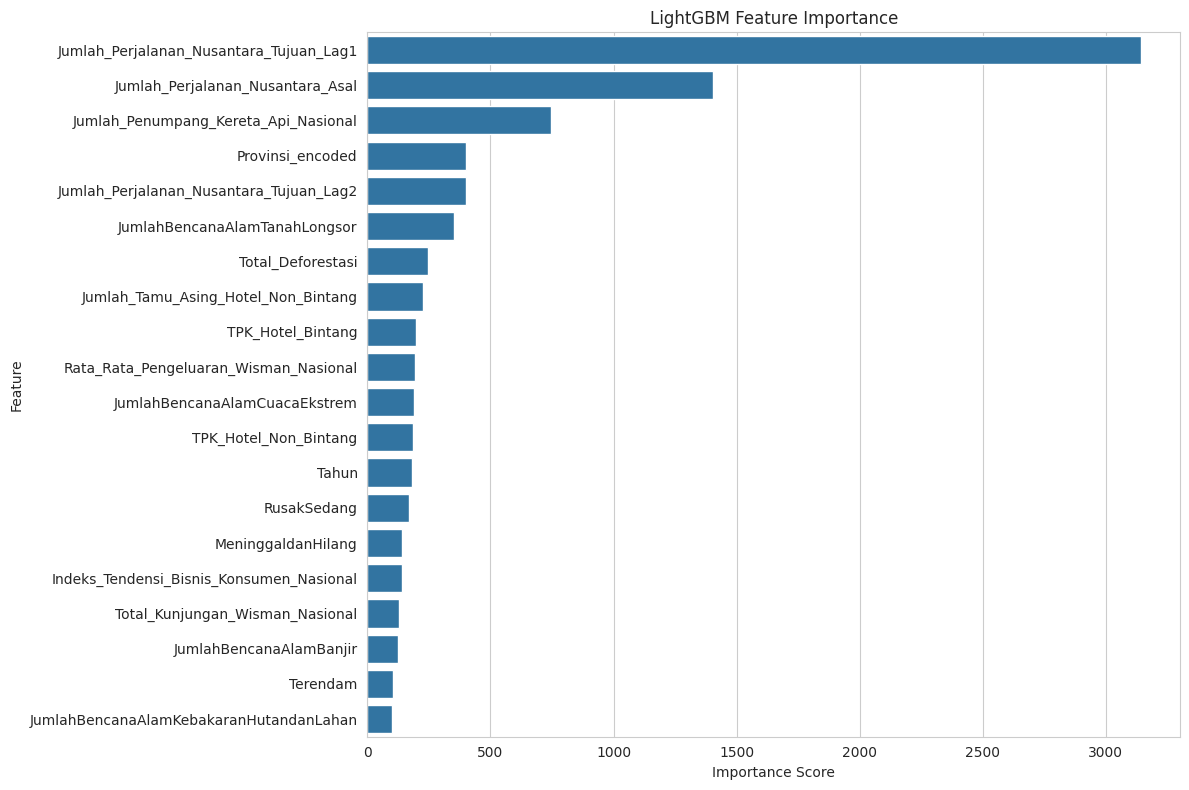

In [ ]:
print("--- Analisis Feature Importance LightGBM ---")

# Dapatkan feature importances dari model terbaik
feature_importances = best_lgbm_model.feature_importances_
feature_names = X_train.columns

# Buat DataFrame untuk visualisasi
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print("\nTop 10 Fitur Terpenting:")
print(importance_df.head(10))

# Visualisasi (opsional, tapi sangat direkomendasikan untuk laporan)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(20)) # Tampilkan 20 teratas
plt.title('LightGBM Feature Importance')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

print("\n" + "="*50 + "\n")

In [ ]:
sns.set_style("whitegrid")

print("--- Memulai Tahap Lanjutan: Deteksi Anomali & Multi-Task Learning ---")

# ==============================================================================
# 1. MUAT KEMBALI MASTER DATAFRAME FINAL & SIAPKAN DATA UNTUK PEMODELAN
#    (Ini adalah pengulangan dari bagian akhir kode sebelumnya untuk memastikan semua variabel ada)
# ==============================================================================

print("\nMemuat kembali Master DataFrame final dan mempersiapkan data...")
try:
    master_df_path = '/content/drive/MyDrive/JURNAL LISTY/master_dataset_provinsi_tahunan.csv'
    master_df = pd.read_csv(master_df_path)
    print("Master DataFrame berhasil dimuat.")
except FileNotFoundError:
    print(f"ERROR: Master DataFrame tidak ditemukan di jalur: {master_df_path}")
    exit()
except Exception as e:
    print(f"ERROR: Terjadi kesalahan saat memuat Master DataFrame: {e}")
    exit()

--- Memulai Tahap Lanjutan: Deteksi Anomali & Multi-Task Learning ---

Memuat kembali Master DataFrame final dan mempersiapkan data...
Master DataFrame berhasil dimuat.


In [ ]:
# ==============================================================================
# 2. PEMBENTUKAN MASTER DATAFRAME (REVISI FINAL: Tambahkan Provinsi_encoded ke master_df)
#    (Langkah 2 ini sebenarnya sudah digabungkan di kode yang saya berikan sebelumnya,
#     tapi saya akan menyertakan revisi untuk memastikan Provinsi_encoded ada di master_df)
# ==============================================================================

# Tentukan variabel target utama Anda
target_column_main = 'Jumlah_Perjalanan_Nusantara_Tujuan'

# Lakukan Label Encoding untuk 'Provinsi' langsung di master_df
print("Melakukan Label Encoding untuk kolom 'Provinsi' di master_df...")
le = LabelEncoder()
master_df['Provinsi_encoded'] = le.fit_transform(master_df['Provinsi'])
province_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(f"  Mapping Provinsi: {province_mapping}")

# Identifikasi kolom kategorikal untuk LightGBM (sekarang sudah di-encoded)
lgbm_categorical_features_encoded_names = ['Provinsi_encoded']

# Identifikasi fitur (X) dan target (y) dari master_df yang sudah di-encode
# Hapus kolom 'Provinsi' string aslinya
X = master_df.drop(columns=[target_column_main, 'Provinsi'])
y = master_df[target_column_main]

# Identifikasi kolom numerik (semua selain yang kategorikal sudah di-encoded dan target)
numeric_features_to_scale = [col for col in X.columns if col not in lgbm_categorical_features_encoded_names and col != 'Tahun']

# Skala Fitur Numerik
scaler = StandardScaler()
print(f"Melakukan Standard Scaling pada fitur numerik: {numeric_features_to_scale}")
if numeric_features_to_scale:
    X[numeric_features_to_scale] = scaler.fit_transform(X[numeric_features_to_scale])
else:
    print("Tidak ada fitur numerik untuk di-scaling.")

# Sekarang X sudah final
X_final = X.copy()

print("\nData berhasil disiapkan dan dibagi.")
print(f"Ukuran X_final: {X_final.shape}")
print(f"Ukuran y: {y.shape}")
print("Tipe data X_final setelah persiapan:\n", X_final.info())
print("\n" + "="*50 + "\n")

Melakukan Label Encoding untuk kolom 'Provinsi' di master_df...
  Mapping Provinsi: {'ACEH': np.int64(0), 'BALI': np.int64(1), 'BANTEN': np.int64(2), 'BENGKULU': np.int64(3), 'DI YOGYAKARTA': np.int64(4), 'DKI JAKARTA': np.int64(5), 'GORONTALO': np.int64(6), 'JAMBI': np.int64(7), 'JAWA BARAT': np.int64(8), 'JAWA TENGAH': np.int64(9), 'JAWA TIMUR': np.int64(10), 'KALIMANTAN BARAT': np.int64(11), 'KALIMANTAN SELATAN': np.int64(12), 'KALIMANTAN TENGAH': np.int64(13), 'KALIMANTAN TIMUR': np.int64(14), 'KALIMANTAN TIMUR DAN KALIMANTAN UTARA': np.int64(15), 'KALIMANTAN UTARA': np.int64(16), 'KEP. BANGKA BELITUNG': np.int64(17), 'KEP. RIAU': np.int64(18), 'KEPULAUAN BANGKA BELITUNG': np.int64(19), 'KEPULAUAN RIAU': np.int64(20), 'LAMPUNG': np.int64(21), 'MALUKU': np.int64(22), 'MALUKU UTARA': np.int64(23), 'NUSA TENGGARA BARAT': np.int64(24), 'NUSA TENGGARA TIMUR': np.int64(25), 'PAPUA': np.int64(26), 'PAPUA BARAT': np.int64(27), 'PAPUA BARAT DAYA': np.int64(28), 'PAPUA PEGUNUNGAN': np.int64(

In [ ]:
# ==============================================================================
# 3. PEMBAGIAN DATA (TRAINING, VALIDATION, TEST SET)
# ==============================================================================
print("--- Membagi data ke Training, Validasi, dan Testing Set ---")

train_year_end = 2022
val_year_end = 2023

print(f"Pembagian data: Training (hingga {train_year_end}), Validasi ({train_year_end+1}-{val_year_end}), Testing (setelah {val_year_end})")

train_idx = X_final[X_final['Tahun'] <= train_year_end].index
val_idx = X_final[(X_final['Tahun'] > train_year_end) & (X_final['Tahun'] <= val_year_end)].index
test_idx = X_final[X_final['Tahun'] > val_year_end].index

X_train, y_train = X_final.loc[train_idx], y.loc[train_idx]
X_val, y_val = X_final.loc[val_idx], y.loc[val_idx]
X_test, y_test = X_final.loc[test_idx], y.loc[test_idx]

print(f"Ukuran Data Training: X={X_train.shape}, y={y_train.shape}")
print(f"Ukuran Data Validasi: X={X_val.shape}, y={y_val.shape}")
print(f"Ukuran Data Testing: X={X_test.shape}, y={y_test.shape}")
print("\n" + "="*50 + "\n")

--- Membagi data ke Training, Validasi, dan Testing Set ---
Pembagian data: Training (hingga 2022), Validasi (2023-2023), Testing (setelah 2023)
Ukuran Data Training: X=(9184, 85), y=(9184,)
Ukuran Data Validasi: X=(656, 85), y=(656,)
Ukuran Data Testing: X=(656, 85), y=(656,)




In [ ]:
# ==============================================================================
# 4. MUAT MODEL LIGHTGBM TERBAIK DARI HYPERPARAMETER TUNING
#    (Kita akan definisikan ulang berdasarkan best_params yang Anda dapatkan)
# ==============================================================================
print("--- Menginisialisasi Model LightGBM Terbaik dari Tuning ---")

# Parameter terbaik yang Anda dapatkan dari Grid Search:
best_params = {'learning_rate': 0.01, 'n_estimators': 500, 'num_leaves': 20, 'reg_alpha': 0.5, 'reg_lambda': 0.1}

# Inisialisasi model LightGBM dengan parameter terbaik
best_lgbm_model = lgb.LGBMRegressor(objective='regression_l2',
                                    random_state=42,
                                    n_jobs=-1,
                                    **best_params)

# Latih ulang model terbaik pada data training
print("\nMelatih ulang model LightGBM terbaik...")
best_lgbm_model.fit(X_train, y_train,
                    eval_set=[(X_val, y_val)],
                    eval_metric='l1',
                    callbacks=[lgb.early_stopping(100, verbose=False)],
                    categorical_feature=lgbm_categorical_features_encoded_names
                    )
print("\nModel LightGBM terbaik selesai dilatih ulang.")
print("\n" + "="*50 + "\n")

--- Menginisialisasi Model LightGBM Terbaik dari Tuning ---

Melatih ulang model LightGBM terbaik...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003287 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4452
[LightGBM] [Info] Number of data points in the train set: 9184, number of used features: 80
[LightGBM] [Info] Start training from score 9265392.547038

Model LightGBM terbaik selesai dilatih ulang.




In [ ]:
# ==============================================================================
# 5. PENGEMBANGAN MODUL DETEKSI ANOMALI ADAPTIF (AD)
# ==============================================================================
print("--- Pengembangan Modul Deteksi Anomali Adaptif (AD) ---")

# Prediksi pada seluruh data (X_final) menggunakan model terbaik
y_pred_all = best_lgbm_model.predict(X_final)
y_pred_all[y_pred_all < 0] = 0 # Pastikan prediksi tidak negatif

# Hitung Residual (Aktual - Prediksi)
master_df['Predicted_Y_Tuned'] = y_pred_all
master_df['Residual_Tuned'] = master_df[target_column_main] - master_df['Predicted_Y_Tuned']

print("\nMaster DataFrame dengan Prediksi dan Residual (contoh 5 baris):\n", master_df[['Tahun', 'Provinsi', target_column_main, 'Predicted_Y_Tuned', 'Residual_Tuned']].head())

# --- Pendekatan 1: Deteksi Anomali Berbasis Ambang Batas Residual Adaptif (Z-score) ---
print("\nDeteksi Anomali Berbasis Ambang Batas Residual (Z-score Adaptif):")

# Hitung Z-score untuk Residual_Tuned.
# Aspek 'adaptif' dapat berupa penghitungan rata-rata dan standar deviasi Z-score
# dari jendela waktu bergerak atau dari data training/validasi saja.
residual_stats_for_zscore = master_df[master_df['Tahun'] <= val_year_end]['Residual_Tuned']
mean_residual = residual_stats_for_zscore.mean()
std_residual = residual_stats_for_zscore.std()

# Hitung Residual Z-Score
master_df['Residual_ZScore'] = (master_df['Residual_Tuned'] - mean_residual) / std_residual

# Definisikan ambang batas anomali (misalnya 2.5 atau 3 standar deviasi)
zscore_threshold = 2.5

master_df['Is_Anomaly_ZScore'] = ((master_df['Residual_ZScore'].abs() > zscore_threshold))

print(f"Ambang Batas Z-Score: {zscore_threshold}")
print(f"Jumlah Potensi Anomali (Berdasarkan Z-Score): {master_df['Is_Anomaly_ZScore'].sum()} dari {len(master_df)} data.")
print("Contoh Anomali Berdasarkan Z-Score (5 baris):\n", master_df[master_df['Is_Anomaly_ZScore']].head())

# --- Pendekatan 2: Deteksi Anomali Menggunakan Model Unsupervised (Isolation Forest) ---
print("\nDeteksi Anomali Menggunakan Isolation Forest:")

# Pastikan tidak ada NaN di kolom Residual_ZScore sebelum melatih IsolationForest
# Karena sudah fillna(0) di master_df dan Residual_ZScore dihitung dari itu, seharusnya tidak ada NaN.
# Namun, double check:
if master_df['Residual_ZScore'].isnull().any():
    print("Warning: Ada NaN di Residual_ZScore. Mengisi dengan 0 sebelum IsolationForest.")
    master_df['Residual_ZScore'].fillna(0, inplace=True) # Pastikan tidak ada NaN

residual_for_if = master_df['Residual_ZScore'].values.reshape(-1, 1)

# Inisialisasi IsolationForest
iso_forest = IsolationForest(random_state=42, contamination=0.05) # Contoh: perkiraan 5% anomali

# Prediksi anomali pada seluruh data (fit_predict)
master_df['Anomaly_Score_IF_Residual'] = iso_forest.fit_predict(residual_for_if)

# Ubah output (-1, 1) menjadi True/False untuk 'Is_Anomaly'
master_df['Is_Anomaly_IF_Residual'] = master_df['Anomaly_Score_IF_Residual'] == -1

print(f"Jumlah Potensi Anomali (Berdasarkan Isolation Forest): {master_df['Is_Anomaly_IF_Residual'].sum()} dari {len(master_df)} data.")
print("Contoh Anomali Berdasarkan Isolation Forest (5 baris):\n", master_df[master_df['Is_Anomaly_IF_Residual']].head())

print("\n--- Catatan Deteksi Anomali ---")
print("Anda dapat memilih salah satu metode deteksi anomali (Z-score atau Isolation Forest) atau menggabungkannya.")
print("Aspek 'adaptif' dapat berupa: retraining model AD secara berkala, atau ambang batas yang dihitung ulang.")
print("Sinyal anomali ini ('Is_Anomaly_ZScore' atau 'Is_Anomaly_IF_Residual') dapat menjadi fitur baru untuk prediksi di masa depan.")
print("\n" + "="*50 + "\n")

--- Pengembangan Modul Deteksi Anomali Adaptif (AD) ---

Master DataFrame dengan Prediksi dan Residual (contoh 5 baris):
    Tahun Provinsi  Jumlah_Perjalanan_Nusantara_Tujuan  Predicted_Y_Tuned  \
0   2009     ACEH                           8260342.0       6.399900e+05   
1   2009     ACEH                           8260342.0       8.188747e+06   
2   2009     ACEH                           8260342.0       8.192601e+06   
3   2009     ACEH                           8260342.0       8.192601e+06   
4   2009     ACEH                           8260342.0       8.192601e+06   

   Residual_Tuned  
0    7.620352e+06  
1    7.159541e+04  
2    6.774111e+04  
3    6.774111e+04  
4    6.774111e+04  

Deteksi Anomali Berbasis Ambang Batas Residual (Z-score Adaptif):
Ambang Batas Z-Score: 2.5
Jumlah Potensi Anomali (Berdasarkan Z-Score): 210 dari 10496 data.
Contoh Anomali Berdasarkan Z-Score (5 baris):
     Provinsi  Tahun  Jumlah_Perjalanan_Nusantara_Tujuan  \
0       ACEH   2009                

In [ ]:
# ==============================================================================
# 6. IMPLEMENTASI MULTI-TASK LEARNING (MTL) - Simulasi dengan LightGBM
# ==============================================================================
print("--- Implementasi Multi-Task Learning (MTL) - Simulasi dengan LightGBM ---")

# Definisikan daftar target Anda (tugas-tugas MTL)
mtl_targets = {
    'Jumlah_Perjalanan_Nusantara_Tujuan': 'regression_l2',          # Tugas Utama
    'TPK_Hotel_Bintang': 'regression_l2',                           # Tugas Tambahan 1 (Hotel Occupancy)
    'Jumlah_Tamu_Asing_Hotel_Bintang': 'regression_l2',             # Tugas Tambahan 2 (Foreign Hotel Guests)
    'Rata_Rata_Pengeluaran_Wisman_Nasional': 'regression_l2'        # Tugas Tambahan 3 (Foreigner Spending)
}

# Verifikasi keberadaan kolom target MTL di master_df
for target in mtl_targets.keys():
    if target not in master_df.columns:
        print(f"ERROR: Kolom target MTL '{target}' tidak ditemukan di Master DataFrame.")
        print("Mohon periksa kembali nama kolom target atau sesuaikan daftar mtl_targets.")
        exit()

mtl_models = {}
mtl_predictions_test = pd.DataFrame(index=X_test.index)
mtl_eval_results = {}

# Gunakan X_final yang sudah diproses (encoded dan scaled) sebagai fitur bersama
X_mtl_train, X_mtl_val, X_mtl_test = X_train, X_val, X_test

print("\nMemulai pelatihan model LightGBM terpisah untuk setiap tugas (MTL Simulasi)...")
for task_name, objective_type in mtl_targets.items():
    print(f"\nMelatih model untuk Tugas: '{task_name}'")

    y_task = master_df[task_name]

    # Pembagian data (training, validation, test) untuk tugas ini
    y_train_task = y_task.loc[train_idx]
    y_val_task = y_task.loc[val_idx]
    y_test_task = y_task.loc[test_idx]

    lgbm_task_model = lgb.LGBMRegressor(objective=objective_type,
                                        random_state=42,
                                        n_jobs=-1,
                                        **best_params)

    lgbm_task_model.fit(X_mtl_train, y_train_task,
                        eval_set=[(X_mtl_val, y_val_task)],
                        eval_metric='l1',
                        callbacks=[lgb.early_stopping(100, verbose=False)],
                        categorical_feature=lgbm_categorical_features_encoded_names)

    mtl_models[task_name] = lgbm_task_model

    # Prediksi untuk tugas ini pada testing set
    y_pred_test_task = lgbm_task_model.predict(X_mtl_test)
    y_pred_test_task[y_pred_test_task < 0] = 0

    mtl_predictions_test[f'Predicted_{task_name}'] = y_pred_test_task

    # Evaluasi Tugas ini
    def evaluate_model(y_true, y_pred, set_name): # Definisi ulang untuk scope lokal
        mae = mean_absolute_error(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        r2 = r2_score(y_true, y_pred)
        print(f"Metrik pada {set_name} Set:")
        print(f"  MAE: {mae:.2f}")
        print(f"  RMSE: {rmse:.2f}")
        print(f"  R-squared: {r2:.4f}")

    evaluate_model(y_test_task, y_pred_test_task, "Testing")
    mtl_eval_results[task_name] = {
        'MAE': mean_absolute_error(y_test_task, y_pred_test_task),
        'RMSE': np.sqrt(mean_squared_error(y_test_task, y_pred_test_task)),
        'R2': r2_score(y_test_task, y_pred_test_task)
    }
    print("-" * 30)

print("\nMulti-Task Learning (Simulasi) Selesai.")
print("Ringkasan Hasil Evaluasi MTL pada Testing Set:")
for task, metrics in mtl_eval_results.items():
    print(f"  {task}: MAE={metrics['MAE']:.2f}, RMSE={metrics['RMSE']:.2f}, R2={metrics['R2']:.4f}")

# Simpan prediksi MTL untuk analisis lebih lanjut
for task_name in mtl_targets.keys():
    mtl_predictions_test[f'Actual_{task_name}'] = master_df.loc[X_test.index, task_name]

print("\nContoh Prediksi MTL pada Testing Set (Head):")
print(mtl_predictions_test.head())
print("\n" + "="*50 + "\n")

--- Implementasi Multi-Task Learning (MTL) - Simulasi dengan LightGBM ---

Memulai pelatihan model LightGBM terpisah untuk setiap tugas (MTL Simulasi)...

Melatih model untuk Tugas: 'Jumlah_Perjalanan_Nusantara_Tujuan'
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003147 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4452
[LightGBM] [Info] Number of data points in the train set: 9184, number of used features: 80
[LightGBM] [Info] Start training from score 9265392.547038
Metrik pada Testing Set:
  MAE: 2111471.18
  RMSE: 8969437.43
  R-squared: 0.9632
------------------------------

Melatih model untuk Tugas: 'TPK_Hotel_Bintang'
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003403 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force

--- EVALUASI KOMPREHENSIF DAN INTERPRETASI ---

Top 15 Fitur Terpenting untuk Prediksi Kunjungan Wisatawan Nusantara (Tugas Utama):
                                    Feature  Importance
0   Jumlah_Perjalanan_Nusantara_Tujuan_Lag1        3016
1          Jumlah_Perjalanan_Nusantara_Asal        1258
2      Jumlah_Penumpang_Kereta_Api_Nasional         578
3             JumlahBencanaAlamTanahLongsor         349
4                          Provinsi_encoded         309
5   Jumlah_Perjalanan_Nusantara_Tujuan_Lag2         303
6                         Total_Deforestasi         220
7       Jumlah_Tamu_Asing_Hotel_Non_Bintang         204
8                         TPK_Hotel_Bintang         197
9     Rata_Rata_Pengeluaran_Wisman_Nasional         181
10                    TPK_Hotel_Non_Bintang         168
11            JumlahBencanaAlamCuacaEkstrem         155
12                                    Tahun         146
13                              RusakSedang         142
14                       Men

<ipython-input-24-0deaa90a783d>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df.head(15), palette='viridis')


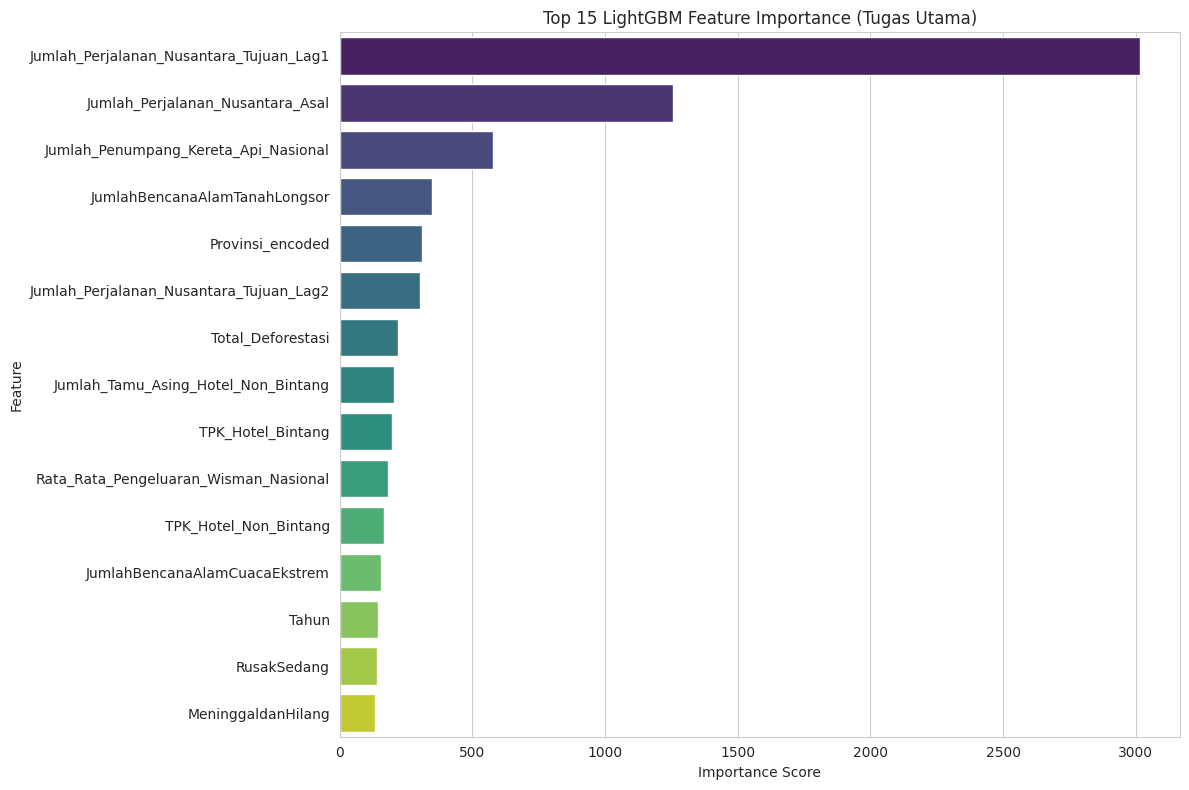


Analisis Residual Z-Score (untuk Anomali):


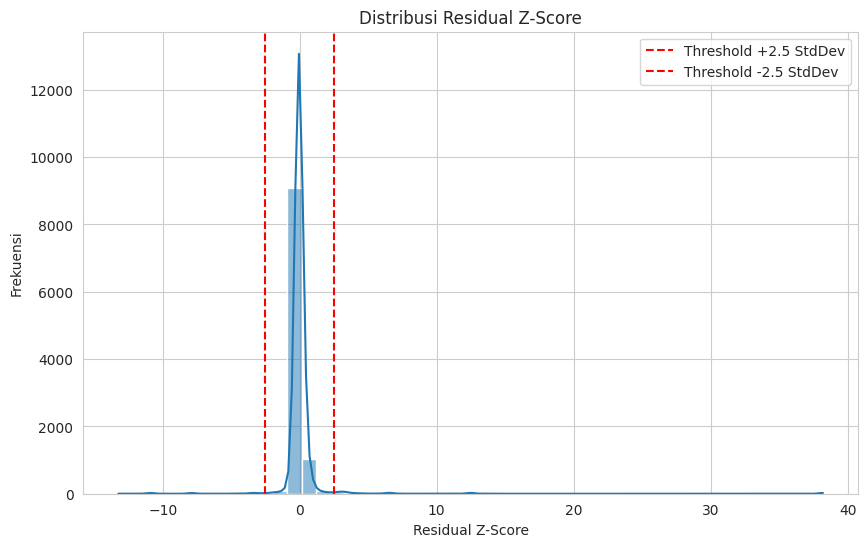


Detail Anomali Kunjungan Wisatawan (Berdasarkan Z-Score):
      Tahun Provinsi_Name  Jumlah_Perjalanan_Nusantara_Tujuan  \
2814   2024    JAWA TIMUR                         218711818.0   
2815   2024    JAWA TIMUR                         218711818.0   
2804   2024    JAWA TIMUR                         218711818.0   
2803   2024    JAWA TIMUR                         218711818.0   
2813   2024    JAWA TIMUR                         218711818.0   
2807   2024    JAWA TIMUR                         218711818.0   
2806   2024    JAWA TIMUR                         218711818.0   
2805   2024    JAWA TIMUR                         218711818.0   
2811   2024    JAWA TIMUR                         218711818.0   
2812   2024    JAWA TIMUR                         218711818.0   

      Predicted_Y_Tuned  Residual_Tuned  Residual_ZScore  
2814       1.625423e+08    5.616957e+07        38.199743  
2815       1.625423e+08    5.616957e+07        38.199743  
2804       1.625423e+08    5.616957e+07        3

In [ ]:
# ==============================================================================
# 7. EVALUASI KOMPREHENSIF DAN INTERPRETASI
# ==============================================================================
print("--- EVALUASI KOMPREHENSIF DAN INTERPRETASI ---")

# --- 7.1 Interpretasi Feature Importance untuk Tugas Utama ---
feature_importances = best_lgbm_model.feature_importances_
feature_names = X_train.columns

importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)

print("\nTop 15 Fitur Terpenting untuk Prediksi Kunjungan Wisatawan Nusantara (Tugas Utama):")
print(importance_df.head(15))

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(15), palette='viridis')
plt.title('Top 15 LightGBM Feature Importance (Tugas Utama)')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# --- 7.2 Analisis Z-Score Residual ---
print("\nAnalisis Residual Z-Score (untuk Anomali):")
plt.figure(figsize=(10, 6))
sns.histplot(master_df['Residual_ZScore'], bins=50, kde=True)
plt.axvline(x=zscore_threshold, color='r', linestyle='--', label=f'Threshold +{zscore_threshold} StdDev')
plt.axvline(x=-zscore_threshold, color='r', linestyle='--', label=f'Threshold -{zscore_threshold} StdDev')
plt.title('Distribusi Residual Z-Score')
plt.xlabel('Residual Z-Score')
plt.ylabel('Frekuensi')
plt.legend()
plt.show()

print("\nDetail Anomali Kunjungan Wisatawan (Berdasarkan Z-Score):")
# Gunakan master_df, karena sudah memiliki Provinsi_encoded dan Residual_ZScore
anomalies_zscore_detail = master_df[master_df['Is_Anomaly_ZScore']].sort_values(by='Residual_ZScore', ascending=False)
# Gunakan mapping untuk mendapatkan nama Provinsi asli
anomalies_zscore_detail['Provinsi_Name'] = anomalies_zscore_detail['Provinsi_encoded'].map({v: k for k, v in province_mapping.items()})
print(anomalies_zscore_detail[['Tahun', 'Provinsi_Name', target_column_main, 'Predicted_Y_Tuned', 'Residual_Tuned', 'Residual_ZScore']].head(10))

# --- 7.3 Analisis Hasil Multi-Task Learning ---
print("\nAnalisis Hasil Multi-Task Learning (Simulasi):")
print("Ringkasan Hasil Evaluasi MTL pada Testing Set (sudah dicetak di atas):")
for task, metrics in mtl_eval_results.items():
    print(f"  {task}: MAE={metrics['MAE']:.2f}, RMSE={metrics['RMSE']:.2f}, R2={metrics['R2']:.4f}")

# Contoh visualisasi prediksi vs aktual untuk salah satu tugas tambahan
task_to_visualize = 'TPK_Hotel_Bintang'
if task_to_visualize in mtl_predictions_test.columns: # Pastikan task_to_visualize ada di hasil prediksi
    plt.figure(figsize=(15, 7))
    # Ambil data aktual dari master_df berdasarkan indeks X_test
    actual_data_for_viz = master_df.loc[X_test.index, task_to_visualize]
    # Ambil tahun dan provinsi untuk plotting
    tahun_for_viz = master_df.loc[X_test.index, 'Tahun']
    provinsi_encoded_for_viz = master_df.loc[X_test.index, 'Provinsi_encoded']
    provinsi_name_for_viz = provinsi_encoded_for_viz.map({v: k for k, v in province_mapping.items()})

    # Gabungkan untuk plotting
    plot_df = pd.DataFrame({
        'Tahun': tahun_for_viz,
        'Provinsi': provinsi_name_for_viz,
        'Aktual': actual_data_for_viz,
        'Prediksi': mtl_predictions_test[f'Predicted_{task_to_visualize}']
    })
    # Contoh visualisasi untuk 5 provinsi teratas atau provinsi tertentu
    # (Anda bisa memilih provinsi yang relevan untuk visualisasi)
    selected_provinces = plot_df['Provinsi'].value_counts().head(5).index.tolist()
    plot_df_filtered = plot_df[plot_df['Provinsi'].isin(selected_provinces)]

    sns.lineplot(x='Tahun', y='Aktual', hue='Provinsi', data=plot_df_filtered, marker='o', label='Aktual')
    sns.lineplot(x='Tahun', y='Prediksi', hue='Provinsi', data=plot_df_filtered, linestyle='--', marker='x', legend=False, label='Prediksi')
    plt.title(f'Prediksi {task_to_visualize} vs Aktual per Provinsi (Testing Set)')
    plt.xlabel('Tahun')
    plt.ylabel(task_to_visualize)
    plt.legend(title='Provinsi')
    plt.tight_layout()
    plt.show()

In [ ]:
# --- Hitung MAPE untuk Setiap Tugas MTL (Testing Set) ---
print("\n--- Menghitung MAPE untuk Setiap Tugas MTL (Testing Set) ---")

# mtL_predictions_test sudah berisi 'Actual_TaskName' dan 'Predicted_TaskName'
# mtl_targets sudah berisi nama tugas
# Contoh Loop
for task_name in mtl_targets.keys():
    actual_col = f'Actual_{task_name}'
    predicted_col = f'Predicted_{task_name}'

    if actual_col in mtl_predictions_test.columns and predicted_col in mtl_predictions_test.columns:
        mape_mtl_task = calculate_mape(mtl_predictions_test[actual_col], mtl_predictions_test[predicted_col])
        print(f"MAPE Tugas '{task_name}' (Testing Set): {mape_mtl_task:.2f}%")
    else:
        print(f"Data untuk tugas '{task_name}' tidak lengkap di mtl_predictions_test.")

print("\n" + "="*50 + "\n")


--- Menghitung MAPE untuk Setiap Tugas MTL (Testing Set) ---
MAPE Tugas 'Jumlah_Perjalanan_Nusantara_Tujuan' (Testing Set): 8.14%
MAPE Tugas 'TPK_Hotel_Bintang' (Testing Set): 1.29%
MAPE Tugas 'Jumlah_Tamu_Asing_Hotel_Bintang' (Testing Set): 464.50%
MAPE Tugas 'Rata_Rata_Pengeluaran_Wisman_Nasional' (Testing Set): 39.75%




# **Investigasi Anomali Kunjungan Wisatawan Jawa Timur 2024**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

--- A. Melanjutkan Investigasi Kuantitatif ---

2. Perbandingan Fitur Kunci untuk Jawa Timur (2024 vs Tahun Sebelumnya):

Data Fitur Kunci Jawa Timur (2022-2024) - Provinsi: JAWA TIMUR:

--- Jumlah_Perjalanan_Nusantara_Tujuan ---
      Tahun  Jumlah_Perjalanan_Nusantara_Tujuan
2768   2022                         200548137.0
2769   2022                         200548137.0
2770   2022                         200548137.0
2771   2022                         200548137.0
2772   2022                         200548137.0
2773   2022                         200548137.0
2774   2022                         200548137.0
2775   2022                         200548137.0
2776   2022                         200548137.0
2777   2022                         200548137.0
2778   2022                         200548137.0
2779   2022                         200548137.0
2780   2022                         200548137.0
2781   2022                         200548137.0
2782   2022                         200548137.0
27

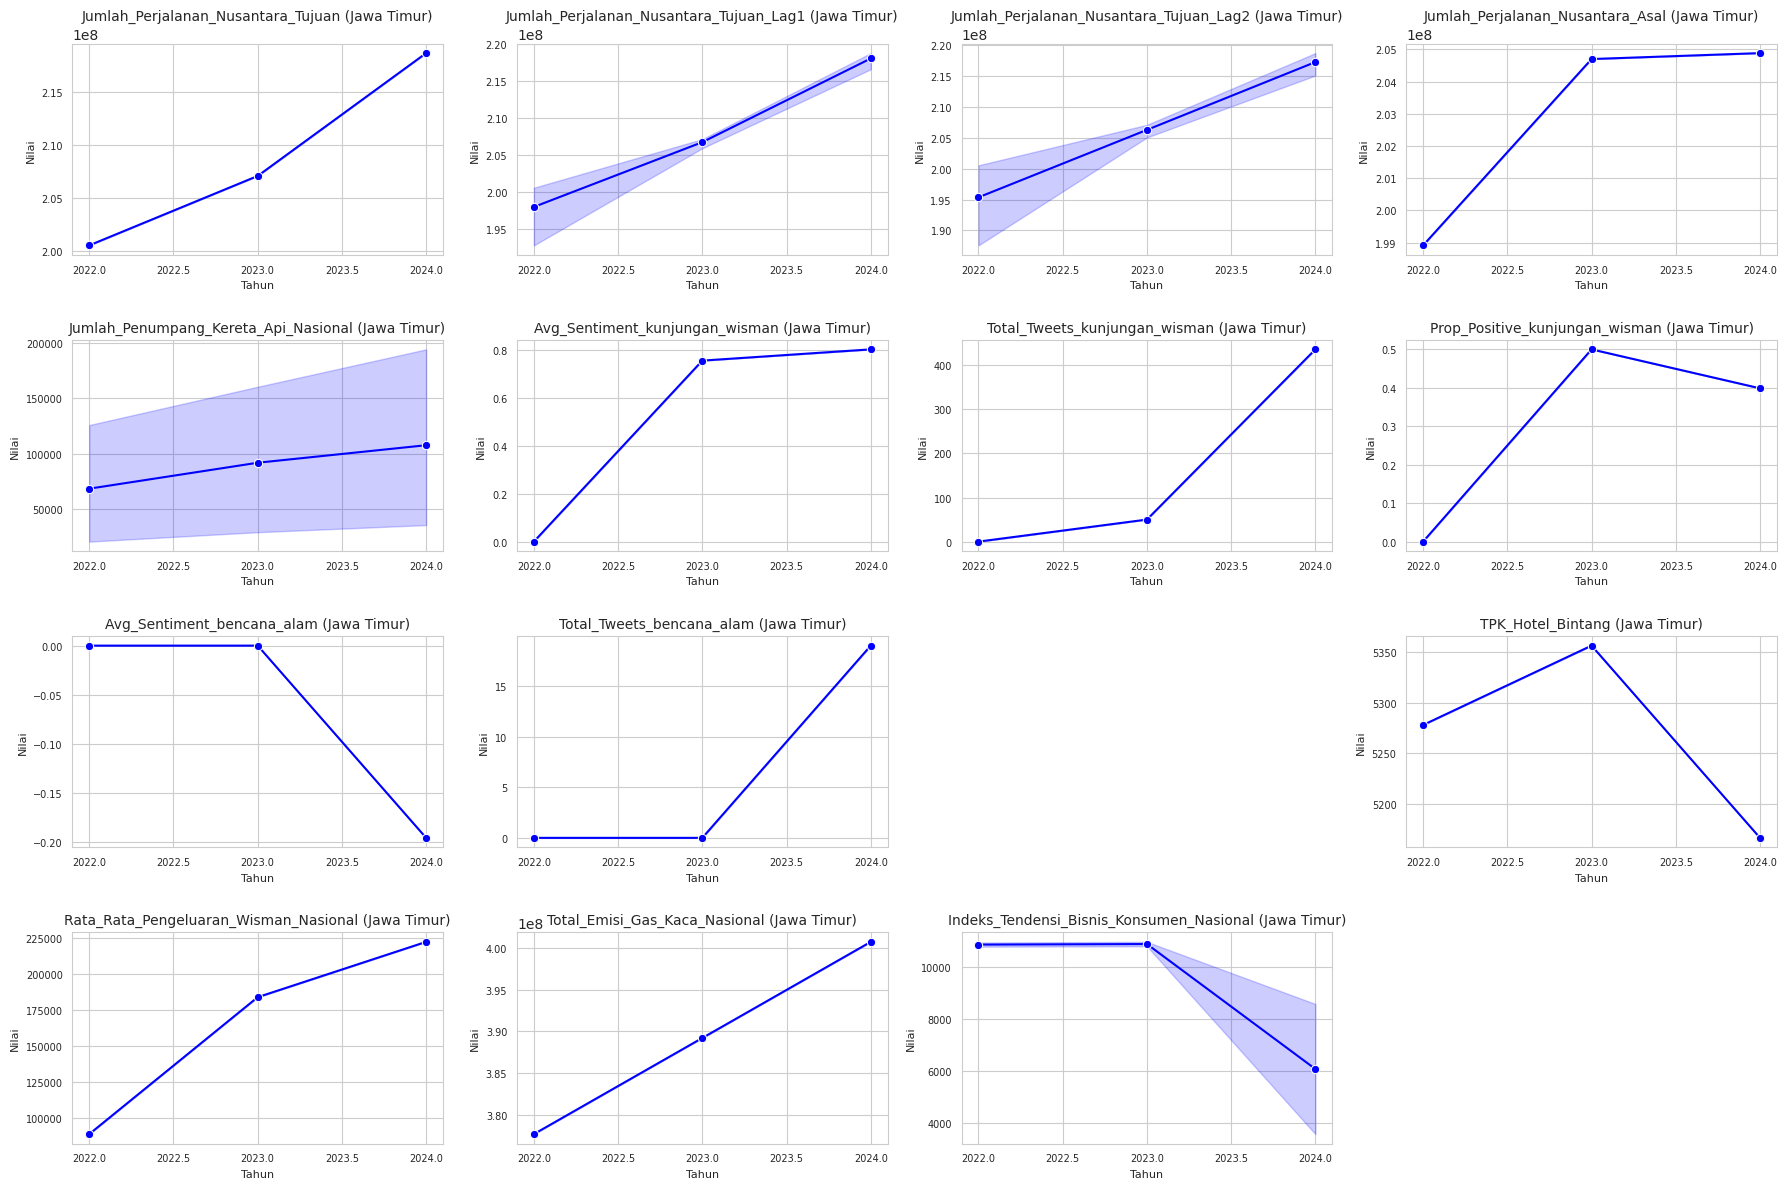




3. Perbandingan Fitur Kunci Jawa Timur (2024) vs Provinsi Lain (2024):

Data Fitur Kunci Tahun 2024 untuk Provinsi: ['JAWA TIMUR', 'JAMBI', 'BALI', 'JAWA TENGAH', 'JAWA BARAT']:

--- Jumlah_Perjalanan_Nusantara_Tujuan (Tahun 2024) ---
        Provinsi  Jumlah_Perjalanan_Nusantara_Tujuan
496         BALI                          22644939.0
497         BALI                          22644939.0
498         BALI                          22644939.0
499         BALI                          22644939.0
500         BALI                          22644939.0
...          ...                                 ...
2811  JAWA TIMUR                         218711818.0
2812  JAWA TIMUR                         218711818.0
2813  JAWA TIMUR                         218711818.0
2814  JAWA TIMUR                         218711818.0
2815  JAWA TIMUR                         218711818.0

[80 rows x 2 columns]
--- Jumlah_Perjalanan_Nusantara_Tujuan_Lag1 (Tahun 2024) ---
        Provinsi  Jumlah_Perjalanan_Nusant

<ipython-input-68-a994d36e663a>:112: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Provinsi', y=feature, data=data_2024_comparison_filtered, palette='coolwarm')
<ipython-input-68-a994d36e663a>:112: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Provinsi', y=feature, data=data_2024_comparison_filtered, palette='coolwarm')
<ipython-input-68-a994d36e663a>:112: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Provinsi', y=feature, data=data_2024_comparison_filtered, palette='coolwarm')
<ipython-input-68-a994d36e663a>:112: FutureWarning: 

P

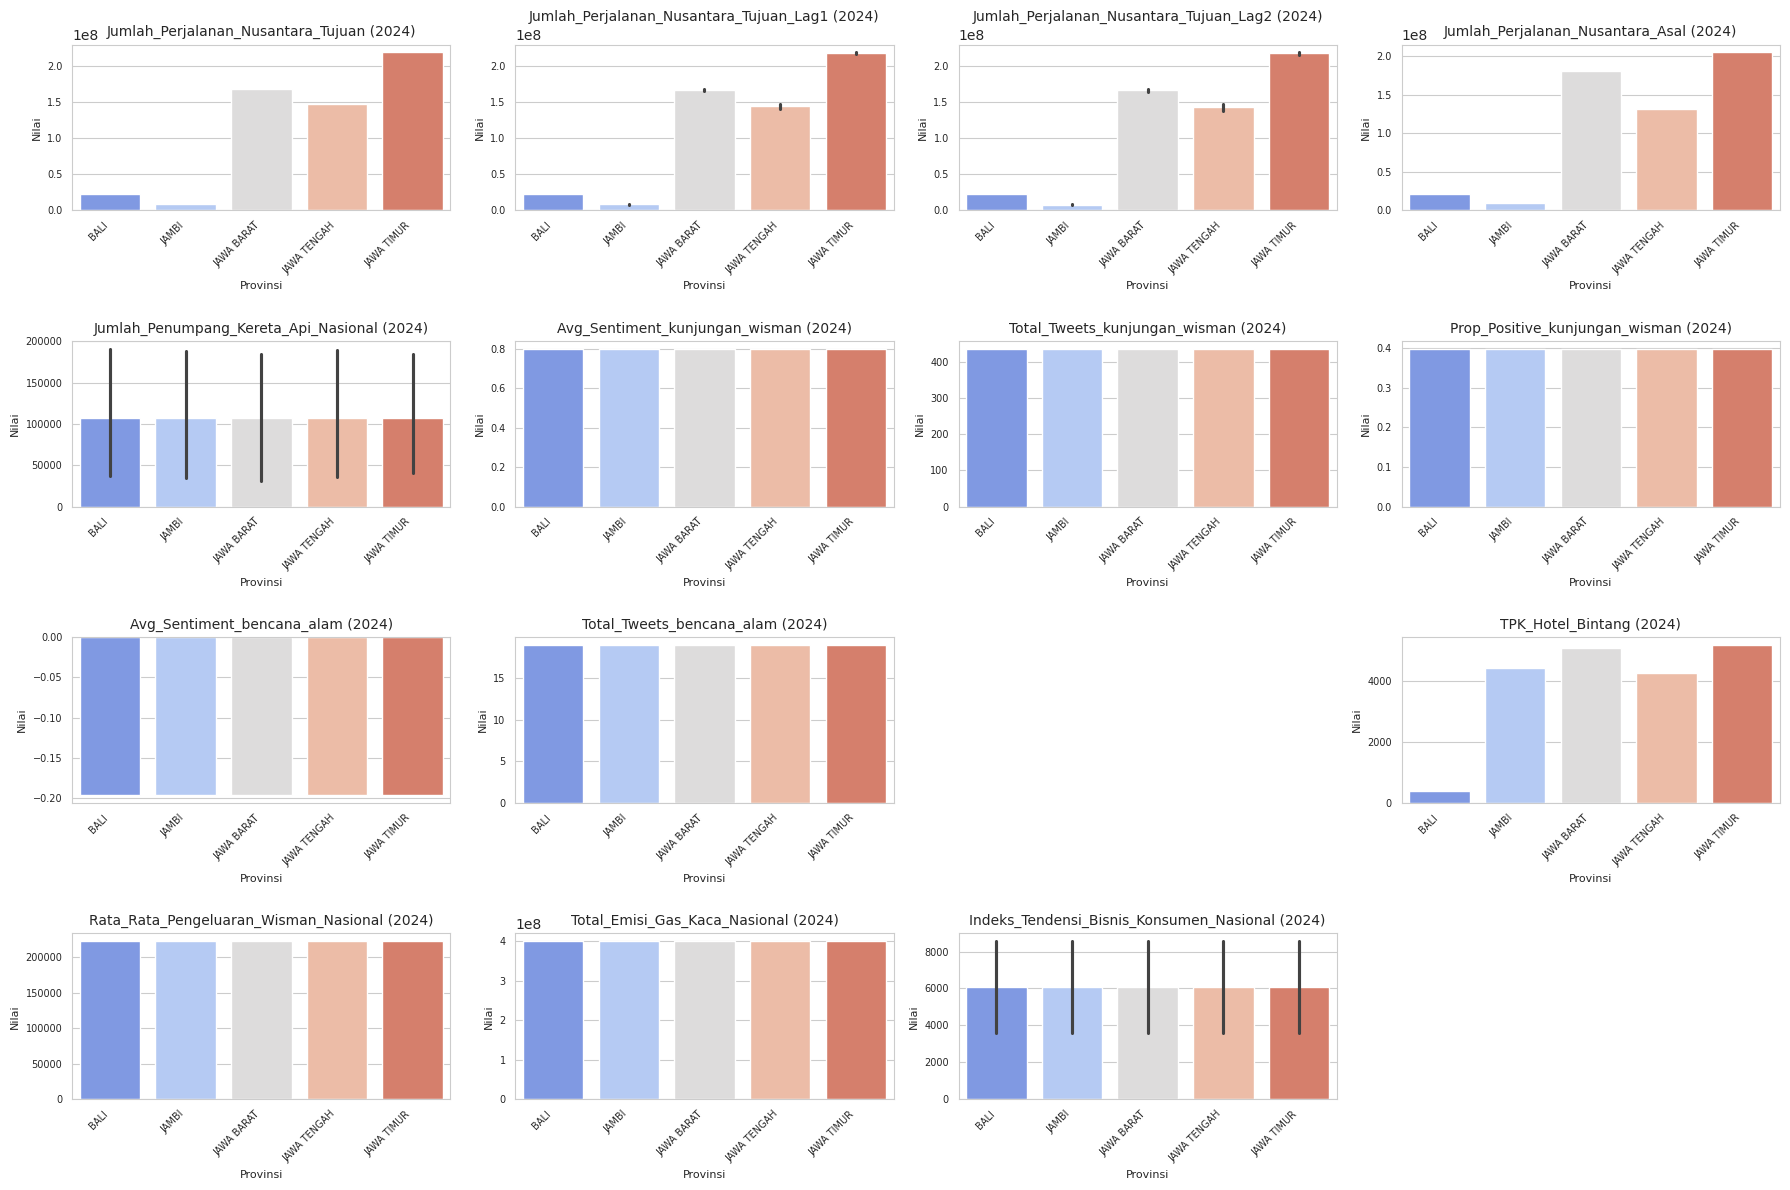

In [ ]:
# Asumsi master_df sudah ada di memori dari eksekusi sebelumnya yang lengkap
# Jika Anda menjalankan ini di sel baru tanpa menjalankan seluruh kode di atasnya,
# Anda mungkin perlu memuat ulang master_df dari file CSV yang sudah disimpan.
# master_df_path = '/content/drive/MyDrive/JURNAL LISTY/master_dataset_provinsi_tahunan_final_version.csv'
# try:
#     master_df = pd.read_csv(master_df_path)
#     print("Master DataFrame berhasil dimuat dari file.")
# except FileNotFoundError:
#     print("ERROR: Master DataFrame tidak ditemukan. Pastikan Anda sudah menyimpannya.")
#     exit()
# except Exception as e:
#     print(f"ERROR: Terjadi kesalahan saat memuat Master DataFrame: {e}")
#     exit()

# Dapatkan mapping provinsi untuk interpretasi (ini harus konsisten)
# Re-fit LabelEncoder untuk mendapatkan mapping yang benar dari master_df yang dimuat/ada di memori
le = LabelEncoder()
master_df['Provinsi_encoded_temp'] = le.fit_transform(master_df['Provinsi']) # Gunakan kolom temp
province_mapping_reversed = {v: k for k, v in dict(zip(le.classes_, le.transform(le.classes_))).items()}
master_df = master_df.drop(columns=['Provinsi_encoded_temp']) # Hapus kolom temp

# ID encoded untuk Jawa Timur (verifikasi jika perlu)
jatim_encoded = 10 # Berdasarkan hasil Anda sebelumnya, Jawa Timur adalah 10

print("--- A. Melanjutkan Investigasi Kuantitatif ---")

# --- 2. Perbandingan Fitur Kunci untuk Jawa Timur (2024 vs Tahun Sebelumnya) ---
print("\n2. Perbandingan Fitur Kunci untuk Jawa Timur (2024 vs Tahun Sebelumnya):\n")

# Pilih fitur-fitur yang paling penting dari analisis feature importance Anda
# dan juga fitur-fitur yang Anda duga relevan (sentimen, transportasi, bencana)
key_features_to_compare = [
    'Jumlah_Perjalanan_Nusantara_Tujuan',
    'Jumlah_Perjalanan_Nusantara_Tujuan_Lag1',
    'Jumlah_Perjalanan_Nusantara_Tujuan_Lag2',
    'Jumlah_Perjalanan_Nusantara_Asal',
    'Jumlah_Penumpang_Kereta_Api_Nasional',
    'Avg_Sentiment_kunjungan_wisman',
    'Total_Tweets_kunjungan_wisman',
    'Prop_Positive_kunjungan_wisman',
    'Avg_Sentiment_bencana_alam',
    'Total_Tweets_bencana_alam',
    'Jumlah_Bencana_Alam__Tanah_Longsor',
    'TPK_Hotel_Bintang',
    'Rata_Rata_Pengeluaran_Wisman_Nasional',
    'Total_Emisi_Gas_Kaca_Nasional',
    'Indeks_Tendensi_Bisnis_Konsumen_Nasional'
]

# Filter data Jawa Timur untuk tahun-tahun relevan (2022, 2023, 2024)
jatim_data = master_df[master_df['Provinsi_encoded'] == jatim_encoded]
jatim_data_comparison = jatim_data[jatim_data['Tahun'].isin([2022, 2023, 2024])].sort_values('Tahun')

print(f"Data Fitur Kunci Jawa Timur (2022-2024) - Provinsi: {province_mapping_reversed.get(jatim_encoded, 'N/A')}:\n")
for feature in key_features_to_compare:
    if feature in jatim_data_comparison.columns:
        print(f"--- {feature} ---")
        print(jatim_data_comparison[['Tahun', feature]])
    else:
        print(f"Kolom '{feature}' tidak ditemukan di DataFrame.")
print("\n" + "="*50 + "\n")

# Visualisasi perbandingan fitur kunci Jawa Timur (2022-2024)
print("\nVisualisasi Perbandingan Fitur Kunci Jawa Timur (2022-2024):\n")
plt.figure(figsize=(18, 12))
# Perbaikan di sini: Konversi hasil np.ceil ke integer
num_rows_plot = int(np.ceil(len(key_features_to_compare)/4))
for i, feature in enumerate(key_features_to_compare):
    if feature in jatim_data_comparison.columns:
        plt.subplot(num_rows_plot, 4, i+1) # Gunakan num_rows_plot yang sudah di-integer
        sns.lineplot(x='Tahun', y=feature, data=jatim_data_comparison, marker='o', color='blue')
        plt.title(f'{feature} (Jawa Timur)', fontsize=10)
        plt.xlabel('Tahun', fontsize=8)
        plt.ylabel('Nilai', fontsize=8)
        plt.xticks(fontsize=7)
        plt.yticks(fontsize=7)
plt.tight_layout()
plt.show()
print("\n" + "="*50 + "\n")


# --- 3. Perbandingan Fitur Kunci Jawa Timur (2024) vs Provinsi Lain (2024) ---
print("\n3. Perbandingan Fitur Kunci Jawa Timur (2024) vs Provinsi Lain (2024):\n")

# Pilih beberapa provinsi lain sebagai pembanding (misalnya provinsi dengan kunjungan tinggi atau tetangga)
# Anda bisa menyesuaikan daftar encoded ID provinsi di sini.
# Contoh: DKI Jakarta (id 7), Bali (id 1), Jawa Barat (id 9), Jawa Tengah (id 8)
compare_provinces_encoded = [jatim_encoded, 7, 1, 9, 8]
compare_provinces_names = [province_mapping_reversed.get(id, 'N/A') for id in compare_provinces_encoded]


data_2024_comparison = master_df[master_df['Tahun'] == 2024]
data_2024_comparison_filtered = data_2024_comparison[data_2024_comparison['Provinsi_encoded'].isin(compare_provinces_encoded)]

print(f"Data Fitur Kunci Tahun 2024 untuk Provinsi: {compare_provinces_names}:\n")
for feature in key_features_to_compare:
    if feature in data_2024_comparison_filtered.columns:
        print(f"--- {feature} (Tahun 2024) ---")
        print(data_2024_comparison_filtered[['Provinsi', feature]])
    else:
        print(f"Kolom '{feature}' tidak ditemukan di DataFrame.")
print("\n" + "="*50 + "\n")

# Visualisasi perbandingan lintas provinsi (Tahun 2024)
print("\nVisualisasi Perbandingan Fitur Kunci Lintas Provinsi (Tahun 2024):\n")
plt.figure(figsize=(18, 12))
# Perbaikan di sini: Konversi hasil np.ceil ke integer
num_rows_plot_cross_province = int(np.ceil(len(key_features_to_compare)/4))
for i, feature in enumerate(key_features_to_compare):
    if feature in data_2024_comparison_filtered.columns:
        plt.subplot(num_rows_plot_cross_province, 4, i+1) # Gunakan num_rows_plot_cross_province yang sudah di-integer
        sns.barplot(x='Provinsi', y=feature, data=data_2024_comparison_filtered, palette='coolwarm')
        plt.title(f'{feature} (2024)', fontsize=10)
        plt.xlabel('Provinsi', fontsize=8)
        plt.ylabel('Nilai', fontsize=8)
        plt.xticks(rotation=45, ha='right', fontsize=7)
        plt.yticks(fontsize=7)
plt.tight_layout()
plt.show()
print("\n" + "="*50 + "\n")

# **KORELASI SKOR SENTIMEN TWITTER DAN JUMLAH KUNJUNGAN WISATAWAN**

In [ ]:
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/JURNAL LISTY/master_dataset_provinsi_tahunan_with_anomaly_features.csv')
df.head()

Provinsi  Tahun  Jumlah_Perjalanan_Nusantara_Tujuan  \
0     ACEH   2009                           8260342.0   
1     ACEH   2009                           8260342.0   
2     ACEH   2009                           8260342.0   
3     ACEH   2009                           8260342.0   
4     ACEH   2009                           8260342.0   

   Jumlah_Perjalanan_Nusantara_Asal  TPK_Hotel_Bintang  TPK_Hotel_Non_Bintang  \
0                         1043445.0             5118.0                 3863.0   
1                         1043445.0             5118.0                 3863.0   
2                         1043445.0             5118.0                 3863.0   
3                         1043445.0             5118.0                 3863.0   
4                         1043445.0             5118.0                 3863.0   

   Jumlah_Tamu_Asing_Hotel_Bintang  Jumlah_Tamu_Asing_Hotel_Non_Bintang  \
0                             92.0                                204.0   
1                             92.0                                204.0   
2                             92.0                                204.0   
3                             92.0                                204.0   
4                             92.0                                204.0   

   Total_Deforestasi  JumlahBencanaAlamGempaBumi  ...  \
0          1058429.0                        20.0  ...   
1          1058429.0                        20.0  ...   
2          1058429.0                        20.0  ...   
3          1058429.0                        20.0  ...   
4          1058429.0                        20.0  ...   

   Prop_Positive_tingkat_penghunian_hotel  \
0                                     0.0   
1                                     0.0   
2                                     0.0   
3                                     0.0   
4                                     0.0   

   Prop_Negative_tingkat_penghunian_hotel  Avg_Sentiment_transportasi_udara  \
0                                     0.0                               0.0   
1                                     0.0                               0.0   
2                                     0.0                               0.0   
3                                     0.0                               0.0   
4                                     0.0                               0.0   

   Total_Tweets_transportasi_udara  Prop_Positive_transportasi_udara  \
0                              0.0                               0.0   
1                              0.0                               0.0   
2                              0.0                               0.0   
3                              0.0                               0.0   
4                              0.0                               0.0   

   Prop_Negative_transportasi_udara  Jumlah_Perjalanan_Nusantara_Tujuan_Lag1  \
0                               0.0                                      0.0   
1                               0.0                                8260342.0   
2                               0.0                                8260342.0   
3                               0.0                                8260342.0   
4                               0.0                                8260342.0   

   Jumlah_Perjalanan_Nusantara_Tujuan_Lag2  Avg_Sentiment_bencana_alam_Lag1  \
0                                      0.0                              0.0   
1                                      0.0                              0.0   
2                                8260342.0                              0.0   
3                                8260342.0                              0.0   
4                                8260342.0                              0.0   

   Total_Tweets_bencana_alam_Lag1  
0                             0.0  
1                             0.0  
2                             0.0  
3                             0.0  
4                             0.0  

[5 rows x 86 columns]

In [ ]:
korelasi = df['Jumlah_Perjalanan_Nusantara_Tujuan'].corr(df['Avg_Sentiment_kunjungan_wisman'])
print(f"Koefisien Korelasi Pearson: {korelasi:.4f}")

Koefisien Korelasi Pearson: 0.0987


In [ ]:
import pandas as pd
from scipy.stats import pearsonr

# Asumsi Anda sudah memuat data Anda ke dalam DataFrame bernama 'df'
# df = pd.read_csv('nama_file_anda.csv')

# Ambil dua kolom yang akan dianalisis
kolom_kunjungan = df['Jumlah_Perjalanan_Nusantara_Tujuan']
kolom_sentimen = df['Avg_Sentiment_kunjungan_wisman']

# Hitung koefisien korelasi dan p-value
korelasi, p_value = pearsonr(kolom_kunjungan, kolom_sentimen)

# Cetak hasilnya
print(f"Koefisien Korelasi Pearson: {korelasi:.4f}")
print(f"P-value: {p_value:.4f}")

Koefisien Korelasi Pearson: 0.0987
P-value: 0.0000
